In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy
import pandas
from PIL import Image
import random
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Data/Output_Files_V6/'
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/RCP_Figs/Analysis_Figs_V6.8.3/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_SubsetC_Output_V6.csv')
    ET_DF = Open_File(Diri+Model+'_ET_SubsetC_Output_V6.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V6.csv')
    Time, Begin_Time, Compl_Time, Peak_Time = [], [], [], []
# Edit Time Format
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Begin_Time.append(Datetime(ET_DF["ET Begin Time"][j]))
        Compl_Time.append(Datetime(ET_DF["ET Complete Time"][j]))
        Peak_Time.append(Datetime(ET_DF["Peak Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["ET Begin Time"] = Begin_Time
    ET_DF["ET Complete Time"] = Compl_Time
    ET_DF["Peak Time"] = Peak_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    return (New_Time)

In [6]:
# Find a Specific Storm Within the DataFrame
def Find_Storm(DF, Code):
    DF_Storm = DF[DF["Code"] == Code].reset_index()
    return (DF_Storm)

In [7]:
# Create Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)

In [8]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [9]:
# Function to Find Distance Between Two Points
def Find_Distance(y1, y2, x1, x2):
    Start_Lat = y1 * numpy.pi / 180
    End_Lat = y2 * numpy.pi / 180
    Start_Lon = x1 * numpy.pi / 180
    End_Lon = x2 * numpy.pi / 180
    Lat_Diff = End_Lat - Start_Lat
    Lon_Diff = End_Lon - Start_Lon
    Earth_Rad = 6378
    Distance = 2 * Earth_Rad * numpy.sqrt((numpy.sin(Lat_Diff/2))**2 + \
    numpy.cos(Start_Lat) * numpy.cos(End_Lat) * (numpy.sin(Lon_Diff/2))**2)
    return (Distance)

In [10]:
# Create Function to Open Storm Composite Files
def Composite_File(File):
    Diri = '/glade/campaign/univ/upsu0032/Hyperion_ET/composites/'
    Compo_File = xr.open_dataset(Diri + File)
    return (Compo_File)

In [11]:
# Open Storm Composite Files
Control_A_Compo_nc = Composite_File('composite_h3_CHEY.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.002.nc')
Control_B_Compo_nc = Composite_File('composite_h3_CORI.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.003.nc')
Control_C_Compo_nc = Composite_File('composite_h3_CHEY.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.nc')

In [12]:
# Open Storm Composite Files
RCP45_A_Compo_nc = Composite_File('composite_h3_CHEY.RCP45.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.nc')
RCP45_B_Compo_nc = Composite_File('composite_h3_CHEY.RCP45.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.002.nc')
RCP45_C_Compo_nc = Composite_File('composite_h3_CHEY.RCP45.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.003.nc')

In [13]:
# Open Storm Composite Files
RCP85_A_Compo_nc = Composite_File('composite_h3_CHEY.RCP85.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.nc')
RCP85_B_Compo_nc = Composite_File('composite_h3_CHEY.RCP85.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.003.nc')
RCP85_C_Compo_nc = Composite_File('composite_h3_CHEY.RCP85.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.004.nc')

In [14]:
# Create DataFrame With Lat Lon Time Data of the Composite Files
def Composite_DF(Compo_nc, ABC):
    Snap_Time = pandas.Series(Compo_nc.snap_time)
    Snap_Lon = pandas.Series(Compo_nc.snap_lon)
    Snap_Lat = pandas.Series(Compo_nc.snap_lat)
    Snap_PathID = pandas.Series(Compo_nc.snap_pathid)
    Index = numpy.arange(0,len(Snap_Time),1)
    ABC_List = []
    for m in range(len(Index)):
        ABC_List.append(ABC)
    Compo_DF = pandas.DataFrame({"Orig Index": Index, "ABC": ABC_List, \
    "Time": Snap_Time, "Lon": Snap_Lon, "Lat": Snap_Lat, "PathID": Snap_PathID})
    return (Compo_DF)

In [15]:
# Combine Composite DFs
def Combine_Compo_DF(Compo_A, Compo_B, Compo_C):
    Compo_DF_A = Composite_DF(Compo_A, "A")
    Compo_DF_B = Composite_DF(Compo_B, "B")
    Compo_DF_C = Composite_DF(Compo_C, "C")
    Compo_DF = pandas.concat([Compo_DF_A, Compo_DF_B, Compo_DF_C]).reset_index()
    Compo_DF = Compo_DF.drop("index", axis=1)
    return (Compo_DF)

In [16]:
Control_Compo = Combine_Compo_DF(Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc)

In [17]:
RCP45_Compo = Combine_Compo_DF(RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc)

In [18]:
RCP85_Compo = Combine_Compo_DF(RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc)

In [19]:
RCP85_A_Compo_nc

<xarray.Dataset>
Dimensions:        (x: 80, y: 80, snapshot: 6331)
Coordinates:
  * x              (x) float64 -11.85 -11.55 -11.25 -10.95 ... 11.25 11.55 11.85
  * y              (y) float64 -11.85 -11.55 -11.25 -10.95 ... 11.25 11.55 11.85
Dimensions without coordinates: snapshot
Data variables: (12/62)
    snap_pathid    (snapshot) int32 0 0 0 0 0 0 0 ... 209 209 209 209 209 209
    snap_lon       (snapshot) float64 -36.2 -36.05 -36.82 ... -38.5 -36.25
    snap_lat       (snapshot) float64 31.52 31.78 30.79 ... 35.5 36.75 38.25
    snap_time      (snapshot) datetime64[ns] 2070-02-02T18:00:00 ... 2100-11-...
    snap_U850      (snapshot, y, x) float32 ...
    snap_U500      (snapshot, y, x) float32 ...
    ...             ...
    PRECL          (y, x) float32 ...
    FLUT           (y, x) float32 ...
    CLDTOT         (y, x) float32 ...
    TMQ            (y, x) float32 ...
    OMEGA850       (y, x) float32 ...
    OMEGA500       (y, x) float32 ...

In [20]:
# Change Year of Data
def Reverse_Update_Year(New_Time, Year_Diff):
    Year_Orig = New_Time.year + Year_Diff
    Orig_Time = New_Time.replace(year=Year_Orig)
    return (Orig_Time)

In [21]:
# Create Function to Find Year Diff
def Year_Diff_Find(New_Time):
    Years = [1900,1930,1960,2000,2031,2062,2100,2131,2162,2193]
    New_Time_Index = -728
    for i in range(len(Years)):
        if i < 3:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 1985 - Years[i]
                New_Time_Index = i
        elif i < 6:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 2070 - Years[i]
                New_Time_Index = i
        else:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 2070 - Years[i]
                New_Time_Index = i
    if New_Time_Index % 3 == 0:
        ABC = "A"
    elif New_Time_Index % 3 == 1:
        ABC = "B"
    elif New_Time_Index % 3 == 2:
        ABC = "C"
    return (int(Year_Diff), ABC)

In [22]:
# Create Function to Find Indexes of Composite Data For Selected Storm
def Find_Composite_Data(Code, Data_DF, Compo_DF):
    DF_Storm = Find_Storm(Data_DF, Code)
    New_Time = DF_Storm["Time(Z)"]
    Lat = DF_Storm["Lat"]
    Lon = DF_Storm["Lon"]
    SLP = DF_Storm["SLP(hPa)"]
    Windspeed = DF_Storm["Winds(m/s)"]
    Storm_Phase = DF_Storm["Storm Phase"]
    Compo_Indexes = numpy.zeros(len(New_Time))
    for i in range(len(New_Time)):
        Year_Diff, ABC = Year_Diff_Find(New_Time[0])
        Orig_Time = Reverse_Update_Year(New_Time[i], Year_Diff)
# Find Possible Storms that Occur at the Same Time
        Compo_Storm = Compo_DF[(Compo_DF["ABC"] == ABC) & (Compo_DF["Time"] == Orig_Time)].reset_index()
# If No Storm Found:
        if len(Compo_Storm) == 0:
            Compo_Indexes[i] = -728
# Storms Found:
        else:
            Dist_Min = [7428,-728]
            for c in range(len(Compo_Storm)):
                Dist = Find_Distance(Lat[i], Compo_Storm["Lat"][c], Lon[i], Compo_Storm["Lon"][c])
# Find Storm Closest to Storm Center
                if Dist < Dist_Min[0]:
# At Most 300km of Error in Location Permitted
                    if Dist < 300:
                        Dist_Min = [Dist, Compo_Storm["Orig Index"][c]]
                    else:
                        Dist_Min = [Dist, -728]
            Compo_Indexes[i] = Dist_Min[1]
    DF_Storm_Compo_Init = pandas.DataFrame({"Compo Index": Compo_Indexes, "Time": New_Time, \
    "Lon": Lon, "Lat": Lat, "SLP(hPa)": SLP, "Sfc Winds(m/s)": Windspeed, "Storm Phase": Storm_Phase})
# Remove Datapoints With Missing Compo Index
    DF_Storm_Compo = DF_Storm_Compo_Init[DF_Storm_Compo_Init["Compo Index"] >= 0].reset_index()
    DF_Storm_Compo = DF_Storm_Compo.drop("index", axis=1)
    return (DF_Storm_Compo)

In [23]:
def Windspeed_850hPa(Compo_nc, Compo_Index):
    U850 = numpy.array(Compo_nc.snap_U850[int(Compo_Index)])
    V850 = numpy.array(Compo_nc.snap_V850[int(Compo_Index)])
    Snap_850 = numpy.sqrt(U850 **2 + V850 **2)
    return (Snap_850)

In [24]:
# Find Precip Rate From Compo File
def Precip_Rate(Compo_nc, Compo_Index):
    Precip_ms = numpy.array(Compo_nc.snap_PRECT[int(Compo_Index)])
    Precip_mmhr = Precip_ms * 3600 * 1000
    return (Precip_mmhr)

In [25]:
# Find Precipitable Water From Compo File
def Precip_Water(Compo_nc, Compo_Index):
    Precipitable_Water = numpy.array(Compo_nc.snap_TMQ[int(Compo_Index)])
    return (Precipitable_Water)

In [26]:
# Find Outgoing Longwave Radiation and Cloud Top Temperature From Compo File
def Cloud_Temp(Compo_nc, Compo_Index):
    Outgoing_Longwave = numpy.array(Compo_nc.snap_FLUT[int(Compo_Index)])
    Sigma = 5.67 * 10**-8
    Cloud_Temp_K = (Outgoing_Longwave / (0.95 * Sigma)) ** 0.25
    Cloud_Temp_C = Cloud_Temp_K - 273.15
    return (Cloud_Temp_C)

In [27]:
# Find Surface Temperature From Compo File
def Temp_Surface(Compo_nc, Compo_Index):
    Temp_K = numpy.array(Compo_nc.snap_TS[int(Compo_Index)])
    Temp_C = Temp_K - 273.15
    return (Temp_C)

In [28]:
# Find 850hPa Temperature From Compo File
def Temp_850hPa(Compo_nc, Compo_Index):
    Temp_K = numpy.array(Compo_nc.snap_T850[int(Compo_Index)])
    Temp_C = Temp_K - 273.15
    return (Temp_C)

In [29]:
# Find 500hPa Temperature From Compo File
def Temp_500hPa(Compo_nc, Compo_Index):
    Temp_K = numpy.array(Compo_nc.snap_T500[int(Compo_Index)])
    Temp_C = Temp_K - 273.15
    return (Temp_C)

In [30]:
# Find 200hPa Temperature From Compo File
def Temp_200hPa(Compo_nc, Compo_Index):
    Temp_K = numpy.array(Compo_nc.snap_T200[int(Compo_Index)])
    Temp_C = Temp_K - 273.15
    return (Temp_C)

In [31]:
# Find 500hPa Vertical Velocity From Compo File
def Omega_500hPa(Compo_nc, Compo_Index):
    Vert_Velo = numpy.array(Compo_nc.snap_OMEGA500[int(Compo_Index)])
    return (Vert_Velo)

In [32]:
# Find 200hPa Zonal Wind From Compo File
def U_200hPa(Compo_nc, Compo_Index):
    Zonal_Wind = numpy.array(Compo_nc.snap_U200[int(Compo_Index)])
    return (Zonal_Wind)

In [33]:
# Find 850hPa Max Windspeed and Wind Field Size at Each 6 Hourly Data Point
def Wind_Field_Find(DF_Storm_Compo, Compo_nc):
    Compo_Index = DF_Storm_Compo["Compo Index"]
    SLP = DF_Storm_Compo["SLP(hPa)"]
#
# Create Array to Store Data
    Wind_Field_Info = numpy.zeros((2,len(Compo_Index)))
    Wind_Field_Info[0] = SLP
#
# At Each 6 Hourly Data Point
    for k in range(len(Compo_Index)):
# Find 850hPa Windspeed Snap From Compo_nc
        Snap_850 = Windspeed_850hPa(Compo_nc, Compo_Index[k])
# Find Maximum 850hPa Windspeed
        Windspeed_850 = numpy.max(Snap_850)
        Wind_Field_Info[1][k] = Windspeed_850
#
# Add Wind Field Info Into DF Storm Compo
    DF_Storm_Compo["850hPa Winds"] = Wind_Field_Info[1]
    return (DF_Storm_Compo)

In [34]:
# Create Function to Find Compo Info
def Find_Compo_Info(Code, Data_DF, ET_DF, Compo_DF, Compo_nc):
    DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
    DF_Storm_Compo = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
#
# Seperate Into Tropical, Transitioning, and Extratropical Portions
    DF_Storm_Compo_TC = DF_Storm_Compo[DF_Storm_Compo["Storm Phase"] == "Tropical"]
    DF_Storm_Compo_Trans = DF_Storm_Compo[DF_Storm_Compo["Storm Phase"] == "Transition"].reset_index()
    DF_Storm_Compo_ExTC = DF_Storm_Compo[DF_Storm_Compo["Storm Phase"] == "Extratropical"].reset_index()
# Find Compo Index of Tropical Peak
    if len(DF_Storm_Compo_ExTC) > 0:
        Min_SLP = numpy.min(numpy.array(DF_Storm_Compo_TC["SLP(hPa)"]))
        Trop_Peak_Index = DF_Storm_Compo_TC[DF_Storm_Compo_TC["SLP(hPa)"] == Min_SLP].reset_index()["Compo Index"][0]
# Find Compo Index of ET Begin
        if len(DF_Storm_Compo_Trans) > 0:
            ET_Begin_Index = DF_Storm_Compo_Trans["Compo Index"][0]
        else:
            ET_Begin_Index = DF_Storm_Compo_ExTC["Compo Index"][0]
# Find Compo Index of ET Complete
        ET_Compl_Index = DF_Storm_Compo_ExTC["Compo Index"][0]
        Time_Indexes = [Trop_Peak_Index, ET_Begin_Index, ET_Compl_Index]
#
# If Incomplete Data
    else:
        print ("NAN", Code)
        Time_Indexes = [numpy.nan, numpy.nan, numpy.nan]
    return (Time_Indexes)

In [35]:
# Create Function to Combine Snapshot Maps
def Snaps_Combine(Var, Subset_Codes, Data_DF, ET_DF, Compo_DF, Compo_nc_A, Compo_nc_B, Compo_nc_C, Percentile):
    Snap_All = numpy.zeros((len(Subset_Codes),3,80,80))
    for n in range(len(Subset_Codes)):
        Code = Subset_Codes[n]
        ABC = ET_DF[ET_DF["Code"] == Code].reset_index()["ABC"][0]
        if ABC == "A":
            Compo_nc = Compo_nc_A
        elif ABC == "B":
            Compo_nc = Compo_nc_B
        elif ABC == "C":
            Compo_nc = Compo_nc_C
        Time_Indexes = Find_Compo_Info(Code, Data_DF, ET_DF, Compo_DF, Compo_nc)
        for t in range(len(Time_Indexes)):
            try:
                Snap = Snap_Var(Compo_nc, Time_Indexes[t], Var)
                Snap_All[n][t] = Snap
            except:
                Snap_All[n][t] = numpy.nan
    if Percentile == False:
        Snap_Mean = numpy.nanmean(Snap_All, axis=0)
        return (Snap_Mean)
    elif Percentile == 50:
        Snap_Median = numpy.nanmedian(Snap_All, axis=0)
        return (Snap_Median)
    elif Percentile > 50:
        Snap_Percentile = numpy.nanpercentile(Snap_All, Percentile, axis=0)
        return (Snap_Percentile)

In [36]:
def Snap_Var(Compo_nc, Index, Var):
    if Var == "850hPa Windspeed":
        Snap = numpy.array(Windspeed_850hPa(Compo_nc, Index))
    elif Var == "Precip Rate":
        Snap = numpy.array(Precip_Rate(Compo_nc, Index))
    elif Var == "Precipitable Water":
        Snap = numpy.array(Precip_Water(Compo_nc, Index))
    elif Var == "Cloud Top Temperature":
        Snap = numpy.array(Cloud_Temp(Compo_nc, Index))
    elif Var == "Surface Temperature":
        Snap = numpy.array(Temp_Surface(Compo_nc, Index))
    elif Var == "850hPa Temperature":
        Snap = numpy.array(Temp_850hPa(Compo_nc, Index))
    elif Var == "500hPa Temperature":
        Snap = numpy.array(Temp_500hPa(Compo_nc, Index))
    elif Var == "200hPa Temperature":
        Snap = numpy.array(Temp_200hPa(Compo_nc, Index))
    elif Var == "500hPa Vertical Velocity":
        Snap = numpy.array(Omega_500hPa(Compo_nc, Index))
    elif Var == "200hPa Zonal Wind":
        Snap = numpy.array(U_200hPa(Compo_nc, Index))
    return (Snap)

In [37]:
# Create Function to Plot Contour Maps
def Contour_Map(Axis, i, j, Snap, x_Snap, y_Snap, Bounds, Colours, Model, Time_Label, Var):
# Add Corrdinate Lines
    Axis.plot([-728,728], [0,0], c='black', linestyle='-', linewidth=0.8)
    Axis.plot([0,0], [-728,728], c='black', linestyle='-', linewidth=0.8)
# Initial Indexes
#    i_Init = 0
#    j_Init = 0
#    i_Fin = 80
#    j_Fin = 80
# Plot Contour Map
    Axis.contourf(x_Snap, y_Snap, Snap, levels=Bounds, colors=Colours, extend='both')
# Formatting
#    x_Min = float(x_Snap[i_Init])
#    x_Max = float(x_Snap[i_Fin-1])
#    y_Min = float(y_Snap[j_Init])
#    y_Max = float(y_Snap[j_Fin-1])
    if Var == "Precip Rate" or Var == "Precipitable Water" or Var == "Surface Temperature":
        Axis.set_xlim(-5,5)
        Axis.set_ylim(-5,5)
        Axis.set_xticks(Create_Bins(-5,5,1))
        Axis.set_yticks(Create_Bins(-5,5,1))
    else:
        Axis.set_xlim(-8,8)
        Axis.set_ylim(-8,8)
        Axis.set_xticks(Create_Bins(-8,8,2))
        Axis.set_yticks(Create_Bins(-8,8,2))
    if i == 2:
        Axis.set_xlabel('Lon Diff From Storm Center', fontsize=12)
    if j == 0:
        Axis.set_ylabel('Lat Diff From Storm Center', fontsize=12)
    Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    Title = str(Model + ': ' + Time_Label)
    Axis.set_title(Title, fontsize=20)
# Letter Labels
    Letter_Label(Axis, i*3+j)

In [38]:
# Plot Four Snap Plots
def Snap_Plots(Var, Models_Snaps, Compo_nc, Time_Labels, Bounds, Colours, Savefig, Figname):
# x and y Values
    x_Snap = Compo_nc.x
    y_Snap = Compo_nc.y
#
# Create Fig
    Fig = pyplot.figure(figsize=(16,16))
    Axes = Fig.subplots(3,3, sharex=True, sharey=True)
    Models = ["Control", "RCP4.5", "RCP8.5"]
#
# Plotting
    for i in range(3):
        for j in range(3):
            Contour_Map(Axes[i][j], i, j, Models_Snaps[i][j], x_Snap, y_Snap, Bounds, Colours, \
            Models[i], Time_Labels[j], Var)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list(Var, Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axes[1][1].inset_axes([0.02, 0.95, 0.96, 0.02], transform=Axes[1][1].transAxes)
    Unit = Var_Unit(Var)
    Cbar_Label = Var + ' (' + Unit + ')'
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', \
    cax=Cax, label=Cbar_Label, shrink=0.7)
#
# Save Fig
    Fig.tight_layout()
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [39]:
def Var_Unit(Var):
    if Var == "850hPa Windspeed" or Var == "200hPa Zonal Wind":
        Unit = "m/s"
    elif Var == "Precip Rate":
        Unit = "mm/hr"
    elif Var == "Precipitable Water":
        Unit = "mm"
    elif Var == "500hPa Vertical Velocity":
        Unit = "Pa/s"
    else:
        Unit = "$^\circ$C"
    return (Unit)

In [40]:
# Create Function to Plot Contour Maps
def Contour_Map_Diff(Axis, i, j, Snap_1, Snap_2, x_Snap, y_Snap, Bounds, Colours, Model_1, Model_2, Time_Label, Var):
# Add Corrdinate Lines
    Axis.plot([-728,728], [0,0], c='black', linestyle='-', linewidth=0.8)
    Axis.plot([0,0], [-728,728], c='black', linestyle='-', linewidth=0.8)
# Calculate Difference
    Snap_Diff = Snap_1 - Snap_2
# Plot Contour Map
    Axis.contourf(x_Snap, y_Snap, Snap_Diff, levels=Bounds, colors=Colours, extend='both')
# Formatting
    if Var == "Wind":
        Axis.set_xlim(-8,8)
        Axis.set_ylim(-8,8)
        Axis.set_xticks(Create_Bins(-8,8,2))
        Axis.set_yticks(Create_Bins(-8,8,2))
    elif Var == "Precip":
        Axis.set_xlim(-5,5)
        Axis.set_ylim(-5,5)
        Axis.set_xticks(Create_Bins(-5,5,1))
        Axis.set_yticks(Create_Bins(-5,5,1))
    if i == 2:
        Axis.set_xlabel('Lon Diff From Storm Center', fontsize=12)
    if j == 0:
        Axis.set_ylabel('Lat Diff From Storm Center', fontsize=12)
    Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    Title = str(Model_1 + (' - ') + Model_2 + (': Diff at ') + Time_Label)
    Axis.set_title(Title, fontsize=16)
# Letter Labels
    Letter_Label(Axis, i*3+j)

In [41]:
# Plot Windspeed Snap Diff Plots
def Snap_Diff_Plots(Var, Models_Snaps, Compo_nc, Time_Labels, Bounds, Colours, Diff_Bounds, Diff_Colours, \
Savefig, Figname):
# x and y Values
    x_Snap = Compo_nc.x
    y_Snap = Compo_nc.y
#
# Create Fig
    Fig = pyplot.figure(figsize=(16,16))
    Axes = Fig.subplots(3,3, sharex=True, sharey=True)
    Models = ["Control", "RCP4.5", "RCP8.5"]
#
# Plotting
    for j in range(3):
        Contour_Map(Axes[0][j], 0, j, Models_Snaps[0][j], x_Snap, y_Snap, Bounds, Colours, \
        Models[0], Time_Labels[j], Var)
        Contour_Map_Diff(Axes[1][j], 1, j, Models_Snaps[1][j], Models_Snaps[0][j], \
        x_Snap, y_Snap, Diff_Bounds, Diff_Colours, Models[1], Models[0], Time_Labels[j], Var)
        Contour_Map_Diff(Axes[2][j], 2, j, Models_Snaps[2][j], Models_Snaps[0][j], \
        x_Snap, y_Snap, Diff_Bounds, Diff_Colours, Models[2], Models[0], Time_Labels[j], Var)
#
# Colour Bar For Control
    C_Map = mcolors.LinearSegmentedColormap.from_list(Var, Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axes[0][1].inset_axes([0.02, 0.95, 0.96, 0.02], transform=Axes[0][1].transAxes)
    Unit = Var_Unit(Var)
    Cbar_Label = Var + ' (' + Unit + ')'
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', \
    cax=Cax, label=Cbar_Label, shrink=0.7)
#
# Colour Bar For Difference Plots
    C_Map = mcolors.LinearSegmentedColormap.from_list(Var+' Diff', Diff_Colours, N=len(Diff_Colours))
    Norm = mcolors.BoundaryNorm(Diff_Bounds, C_Map.N, extend='both')
    Cax = Axes[1][1].inset_axes([0.02, 0.95, 0.96, 0.02], transform=Axes[1][1].transAxes)
    Cbar_Label = Var + ' Difference (' + Unit + ')'
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', \
    cax=Cax, label=Cbar_Label, shrink=0.7)
#
# Colour Bar For Difference Plots
    C_Map = mcolors.LinearSegmentedColormap.from_list(Var+' Diff', Diff_Colours, N=len(Diff_Colours))
    Norm = mcolors.BoundaryNorm(Diff_Bounds, C_Map.N, extend='both')
    Cax = Axes[2][1].inset_axes([0.02, 0.95, 0.96, 0.02], transform=Axes[2][1].transAxes)
    Cbar_Label = Var + ' Difference (' + Unit + ')'
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', \
    cax=Cax, label=Cbar_Label, shrink=0.7)
#
# Save Fig
    Fig.tight_layout()
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [113]:
# Create Function to Plot Contour Maps
def Contour_Map_Lines(Axis, i, j, k, Snaps, x_Snap, y_Snap, Bound, Line_Colour, Time_Label, Var):
# Add Corrdinate Lines
    Axis.plot([-728,728], [0,0], c='black', linestyle='-', linewidth=0.8)
    Axis.plot([0,0], [-728,728], c='black', linestyle='-', linewidth=0.8)
# Plot Contour Map
    Line_Colours = ['limegreen', 'darkorange', 'red']
    Contours = Axis.contour(x_Snap, y_Snap, Snaps, levels=Bound, colors=Line_Colour)
    FMT = "%3.0f"
    Axis.clabel(Contours, fmt=FMT, fontsize=10)
# Formatting
    if k == 0:
        if Var == "Precip Rate" or Var == "Precipitable Water" or Var == "Surface Temperature":
            Axis.set_xlim(-5,5)
            Axis.set_ylim(-5,5)
            Axis.set_xticks(Create_Bins(-5,5,1))
            Axis.set_yticks(Create_Bins(-5,5,1))
        else:
            Axis.set_xlim(-8,8)
            Axis.set_ylim(-8,8)
            Axis.set_xticks(Create_Bins(-8,8,2))
            Axis.set_yticks(Create_Bins(-8,8,2))
        if i == 2:
            Axis.set_xlabel('Lon Diff From Storm Center', fontsize=12)
        if j == 0:
            Axis.set_ylabel('Lat Diff From Storm Center', fontsize=12)
        Axis.grid(linewidth=0.3, color='silver', linestyle='-')
        Unit = Var_Unit(Var)
        Title = str(Bound[0]) + Unit + ': ' + Time_Label
        Axis.set_title(Title, fontsize=20)
# Add Legend
        if i == 2 and j == 2:
            Add_Legend(Axis)
# Letter Labels
        Letter_Label(Axis, i*3+j)

In [114]:
# Plot Four Snap Plots
def Snap_Line_Plots(Var, Models_Snaps, Compo_nc, Time_Labels, Bounds, Savefig, Figname):
# x and y Values
    x_Snap = Compo_nc.x
    y_Snap = Compo_nc.y
#
# Create Fig
    Fig = pyplot.figure(figsize=(16,16))
    Axes = Fig.subplots(3,3, sharex=True, sharey=True)
    Models = ["Control", "RCP4.5", "RCP8.5"]
    Colours = ['limegreen', 'darkorange', 'red']
#
# Plotting
    for i in range(3):
        for j in range(3):
            for k in range(3):
                Contour_Map_Lines(Axes[i][j], i, j, k, Models_Snaps[k][j], x_Snap, y_Snap, Bounds[i], Colours[k], \
                Time_Labels[j], Var)
#
# Save Fig
    Fig.tight_layout()
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [115]:
# Add Legend
def Add_Legend(Axis):
    pyplot.plot([-728,-728], [-728,-728], c='limegreen', label='Control')
    pyplot.plot([-728,-728], [-728,-728], c='darkorange', label='RCP4.5')
    pyplot.plot([-728,-728], [-728,-728], c='red', label='RCP8.5')
    pyplot.legend(loc=2, fontsize=15)

In [44]:
Control_Subset_Codes = list(Control_ET['Code'])
RCP45_Subset_Codes = list(RCP45_ET['Code'])
RCP85_Subset_Codes = list(RCP85_ET['Code'])

In [45]:
Time_Labels = ["Tropical Peak", "ET Begin", "ET Complete"]

In [127]:
# Define Colours and Bounds
# 850hPa Windspeed
Windspeed_Colours = ['white', 'cyan', 'lightseagreen', 'limegreen', 'gold', 'darkorange', 'red', 'darkviolet']
Windspeed_Bounds = numpy.array([13,18,25,33,41,50,60])
Windspeed_Diff_Colours = ['darkgreen', 'forestgreen', 'limegreen', 'lawngreen', 'white', \
'gold', 'orange', 'darkorange', 'red']
Windspeed_Diff_Bounds = numpy.array([-4,-3,-2,-1,1,2,3,4])
Windspeed_Line_Bounds = numpy.array([[13],[18],[33]])
#
# Precip Rate
Precip_Rate_Colours = ['white', 'cyan', 'deepskyblue', 'dodgerblue', 'lightseagreen', 'limegreen', \
'greenyellow', 'gold', 'darkorange']
Precip_Rate_Bounds = numpy.array([0.2,0.5,1,2,5,10,20,30])
Precip_Rate_Diff_Colours = ['saddlebrown', 'orange', 'gold', 'yellow', 'white', \
'cyan', 'deepskyblue', 'dodgerblue', 'mediumblue']
Precip_Rate_Diff_Bounds = numpy.array([-5,-3,-1,-0.5,0.5,1,3,5])
Precip_Rate_Line_Bounds = numpy.array([[1],[5],[10]])
#
# Precipitable Water
Precip_Water_Colours = ['white', 'aquamarine', 'springgreen', 'aqua', 'deepskyblue', 'dodgerblue', 'mediumblue']
Precip_Water_Bounds = numpy.array([30,40,50,60,70,80])
Precip_Water_Diff_Colours = ['saddlebrown', 'darkorange', 'orange', 'gold', 'white', \
'cyan', 'deepskyblue', 'dodgerblue', 'mediumblue']
Precip_Water_Diff_Bounds = numpy.array([-15,-10,-5,-2,2,5,10,15])
Precip_Water_Line_Bounds = numpy.array([[50],[60],[70]])
#
# Cloud Top Temperature
Temp_Cloud_Colours = ['red', 'forestgreen', 'limegreen', 'mediumblue', 'deepskyblue', \
'cyan', 'lightgrey', 'white']
Temp_Cloud_Bounds = numpy.array([-60,-50,-40,-30,-20,-10,0])
Temp_Cloud_Diff_Colours = ['mediumblue', 'dodgerblue', 'deepskyblue', 'cyan', 'white', \
'gold', 'orange', 'darkorange', 'red']
Temp_Cloud_Diff_Bounds = numpy.array([-8,-6,-4,-2,2,4,6,8])
Temp_Cloud_Line_Bounds = numpy.array([[-40],[-30],[-20]])
#
# Surface Temperature
Temp_Sfc_Colours = ['mediumblue', 'dodgerblue', 'deepskyblue', 'cyan', 'lightseagreen', 'limegreen', \
'greenyellow', 'yellow', 'gold', 'orange', 'darkorange', 'red']
Temp_Sfc_Bounds = numpy.array([20,21,22,23,24,25,26,27,28,29,30])
Temp_Sfc_Diff_Colours = ['mediumblue', 'dodgerblue', 'deepskyblue', 'cyan', 'white', \
'gold', 'orange', 'darkorange', 'red']
Temp_Sfc_Diff_Bounds = numpy.array([-2,-1.5,-1,-0.5,0.5,1,1.5,2])
Temp_Sfc_Line_Bounds = numpy.array([[24],[26],[28]])
#
# 850hPa Temperature
Temp_850hPa_Colours = ['mediumblue', 'dodgerblue', 'deepskyblue', 'cyan', 'lightseagreen', 'limegreen', \
'greenyellow', 'yellow', 'gold', 'orange', 'darkorange', 'red']
Temp_850hPa_Bounds = numpy.array([0,2.5,5,7.5,10,12.5,15,17.5,20,22.5,25])
Temp_850hPa_Diff_Colours = ['mediumblue', 'dodgerblue', 'deepskyblue', 'cyan', 'white', \
'gold', 'orange', 'darkorange', 'red']
Temp_850hPa_Diff_Bounds = numpy.array([-4,-3,-2,-1,1,2,3,4])
Temp_850hPa_Line_Bounds = numpy.array([[10],[15],[20]])
#
# 500hPa Temperature
Temp_500hPa_Colours = ['deepskyblue', 'cyan', 'lightseagreen', 'limegreen', \
'greenyellow', 'gold', 'darkorange', 'red']
Temp_500hPa_Bounds = numpy.array([-20,-15,-10,-5,0,5,10])
Temp_500hPa_Diff_Colours = ['mediumblue', 'dodgerblue', 'deepskyblue', 'cyan', 'white', \
'gold', 'orange', 'darkorange', 'red']
Temp_500hPa_Diff_Bounds = numpy.array([-4,-3,-2,-1,1,2,3,4])
Temp_500hPa_Line_Bounds = numpy.array([[-10],[-5],[0]])
#
# 200hPa Temperature
Temp_200hPa_Colours = ['deepskyblue', 'cyan', 'lightseagreen', 'limegreen', \
'greenyellow', 'gold', 'darkorange', 'red']
Temp_200hPa_Bounds = numpy.array([-60,-55,-50,-45,-40,-35,-30])
Temp_200hPa_Diff_Colours = ['mediumblue', 'dodgerblue', 'deepskyblue', 'cyan', 'white', \
'gold', 'orange', 'darkorange', 'red']
Temp_200hPa_Diff_Bounds = numpy.array([-4,-3,-2,-1,1,2,3,4])
Temp_200hPa_Line_Bounds = numpy.array([[-55],[-50],[-45]])
#
# 200hPa Zonal Wind
U_200hPa_Colours = ['darkorange', 'orange', 'gold', 'yellow', 'white', \
'greenyellow', 'limegreen', 'lightseagreen', 'deepskyblue', 'mediumblue']
U_200hPa_Bounds = numpy.array([-30,-20,-10,-2,2,10,20,30,40])
U_200hPa_Diff_Colours = ['red', 'darkorange', 'orange', 'gold', 'white', \
'lawngreen', 'limegreen', 'forestgreen', 'darkgreen']
U_200hPa_Diff_Bounds = numpy.array([-6,-4,-2,-1,1,2,4,6])
U_200hPa_Line_Bounds = numpy.array([[0],[10],[20]])

In [47]:
# Letter Labels
def Letter_Label(Axis, Plot):
    Fig_Labels = ['(a)','(b)','(c)','(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)']
    Axis.text(0.05, 0.05, str(Fig_Labels[int(Plot)]), ha='center', va='center', \
    transform=Axis.transAxes, fontdict={'size':24},color='black')

In [48]:
# Calculate Mean Windspeed Snapshots
Var = "850hPa Windspeed"
Percentile = False
Control_Wind_Snap_Mean = Snaps_Combine(Var, Control_Subset_Codes, Control_Data, Control_ET, \
Control_Compo, Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc, Percentile)
RCP45_Wind_Snap_Mean = Snaps_Combine(Var, RCP45_Subset_Codes, RCP45_Data, RCP45_ET, \
RCP45_Compo, RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc, Percentile)
RCP85_Wind_Snap_Mean = Snaps_Combine(Var, RCP85_Subset_Codes, RCP85_Data, RCP85_ET, \
RCP85_Compo, RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc, Percentile)

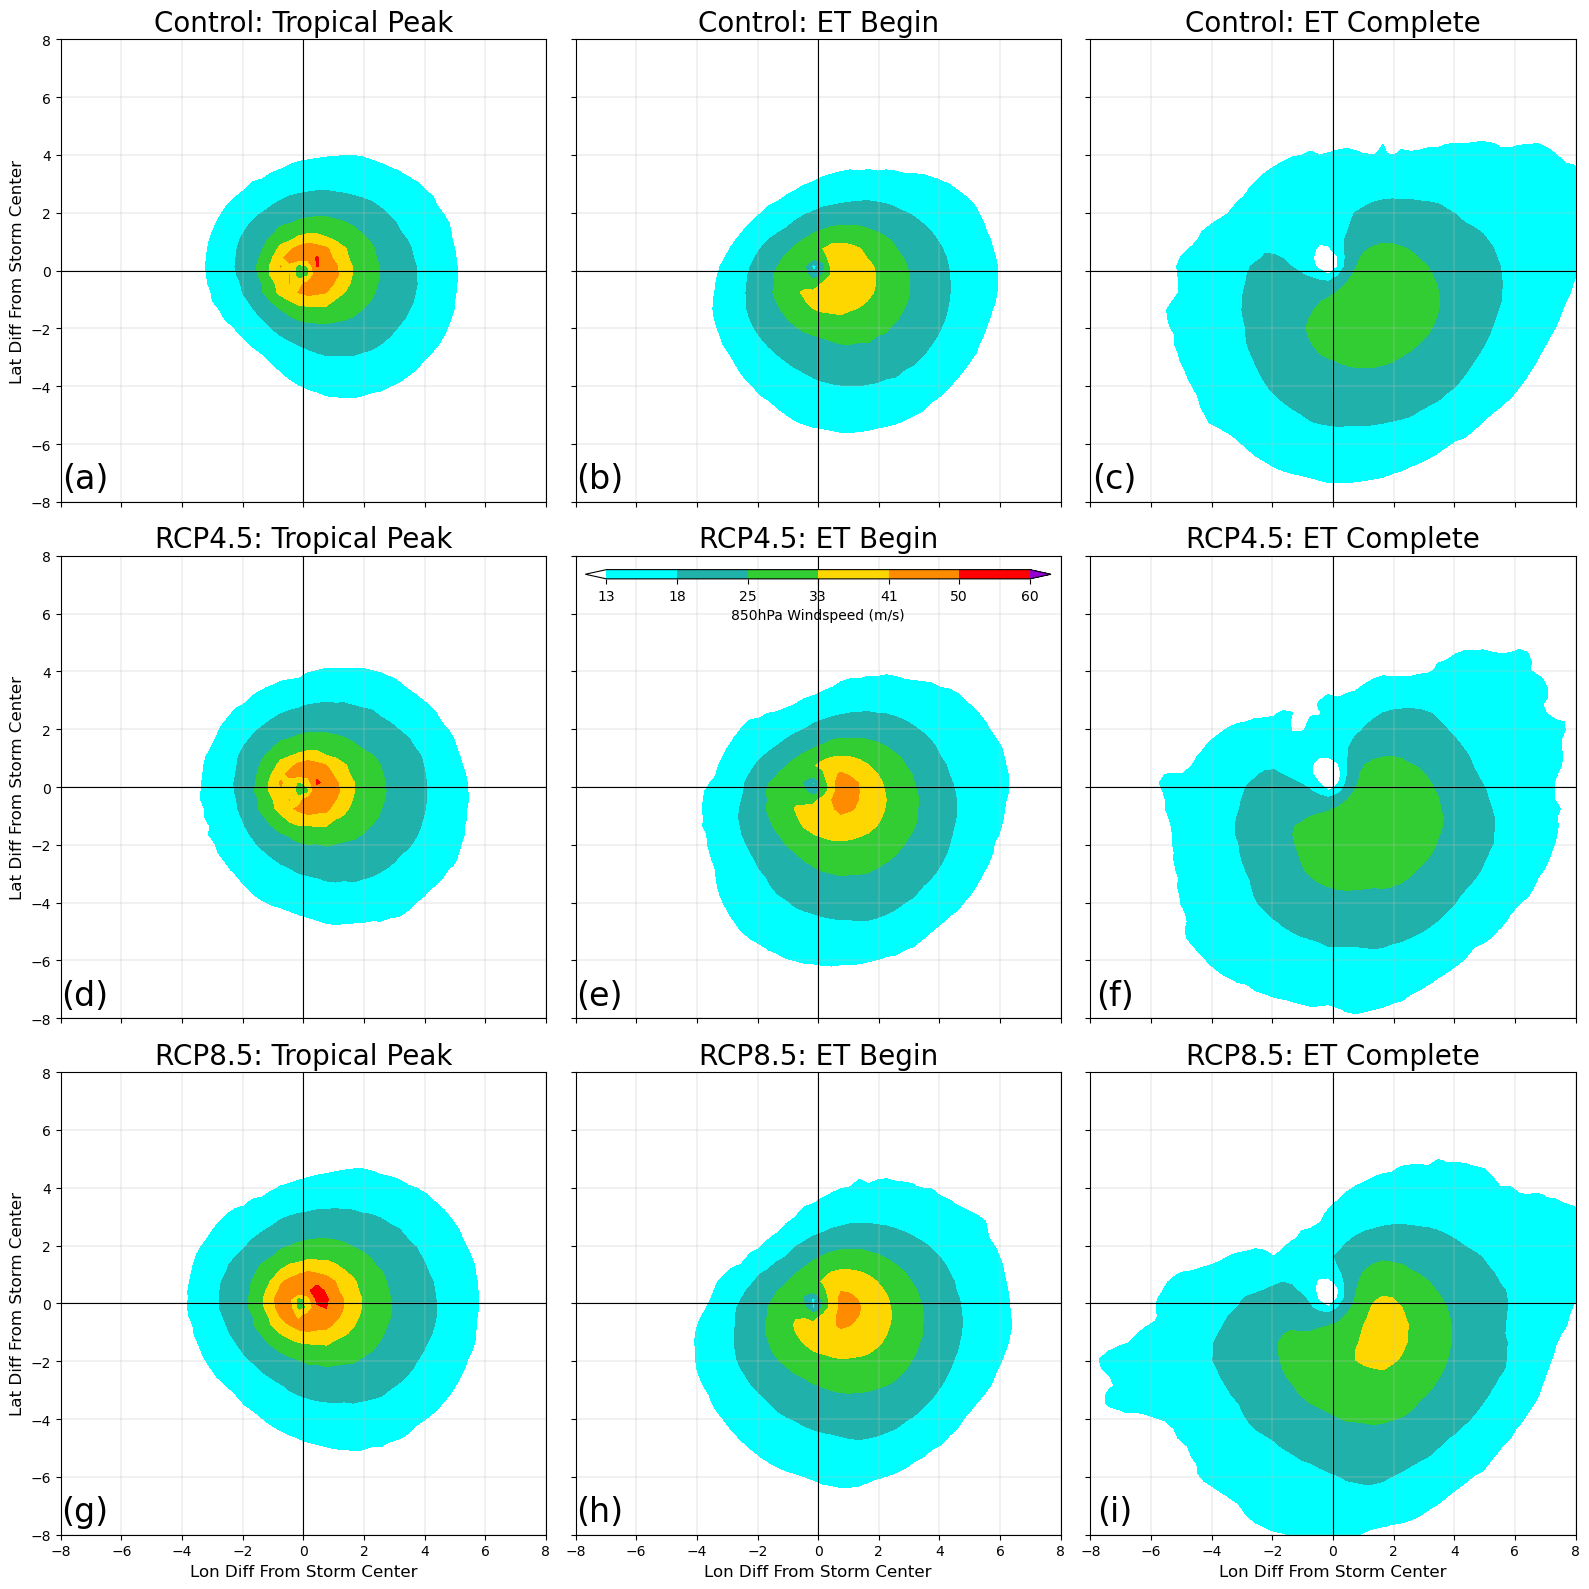

In [49]:
# Plot Mean 850hPa Windspeed Snapshots
Var = "850hPa Windspeed"
Values = [Control_Wind_Snap_Mean, RCP45_Wind_Snap_Mean, RCP85_Wind_Snap_Mean]
Bounds = Windspeed_Bounds
Colours = Windspeed_Colours
Savefig = True
Figname = 'Wind_850hPa_Snaps_Colours.png'
Snap_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Colours, Savefig, Figname)

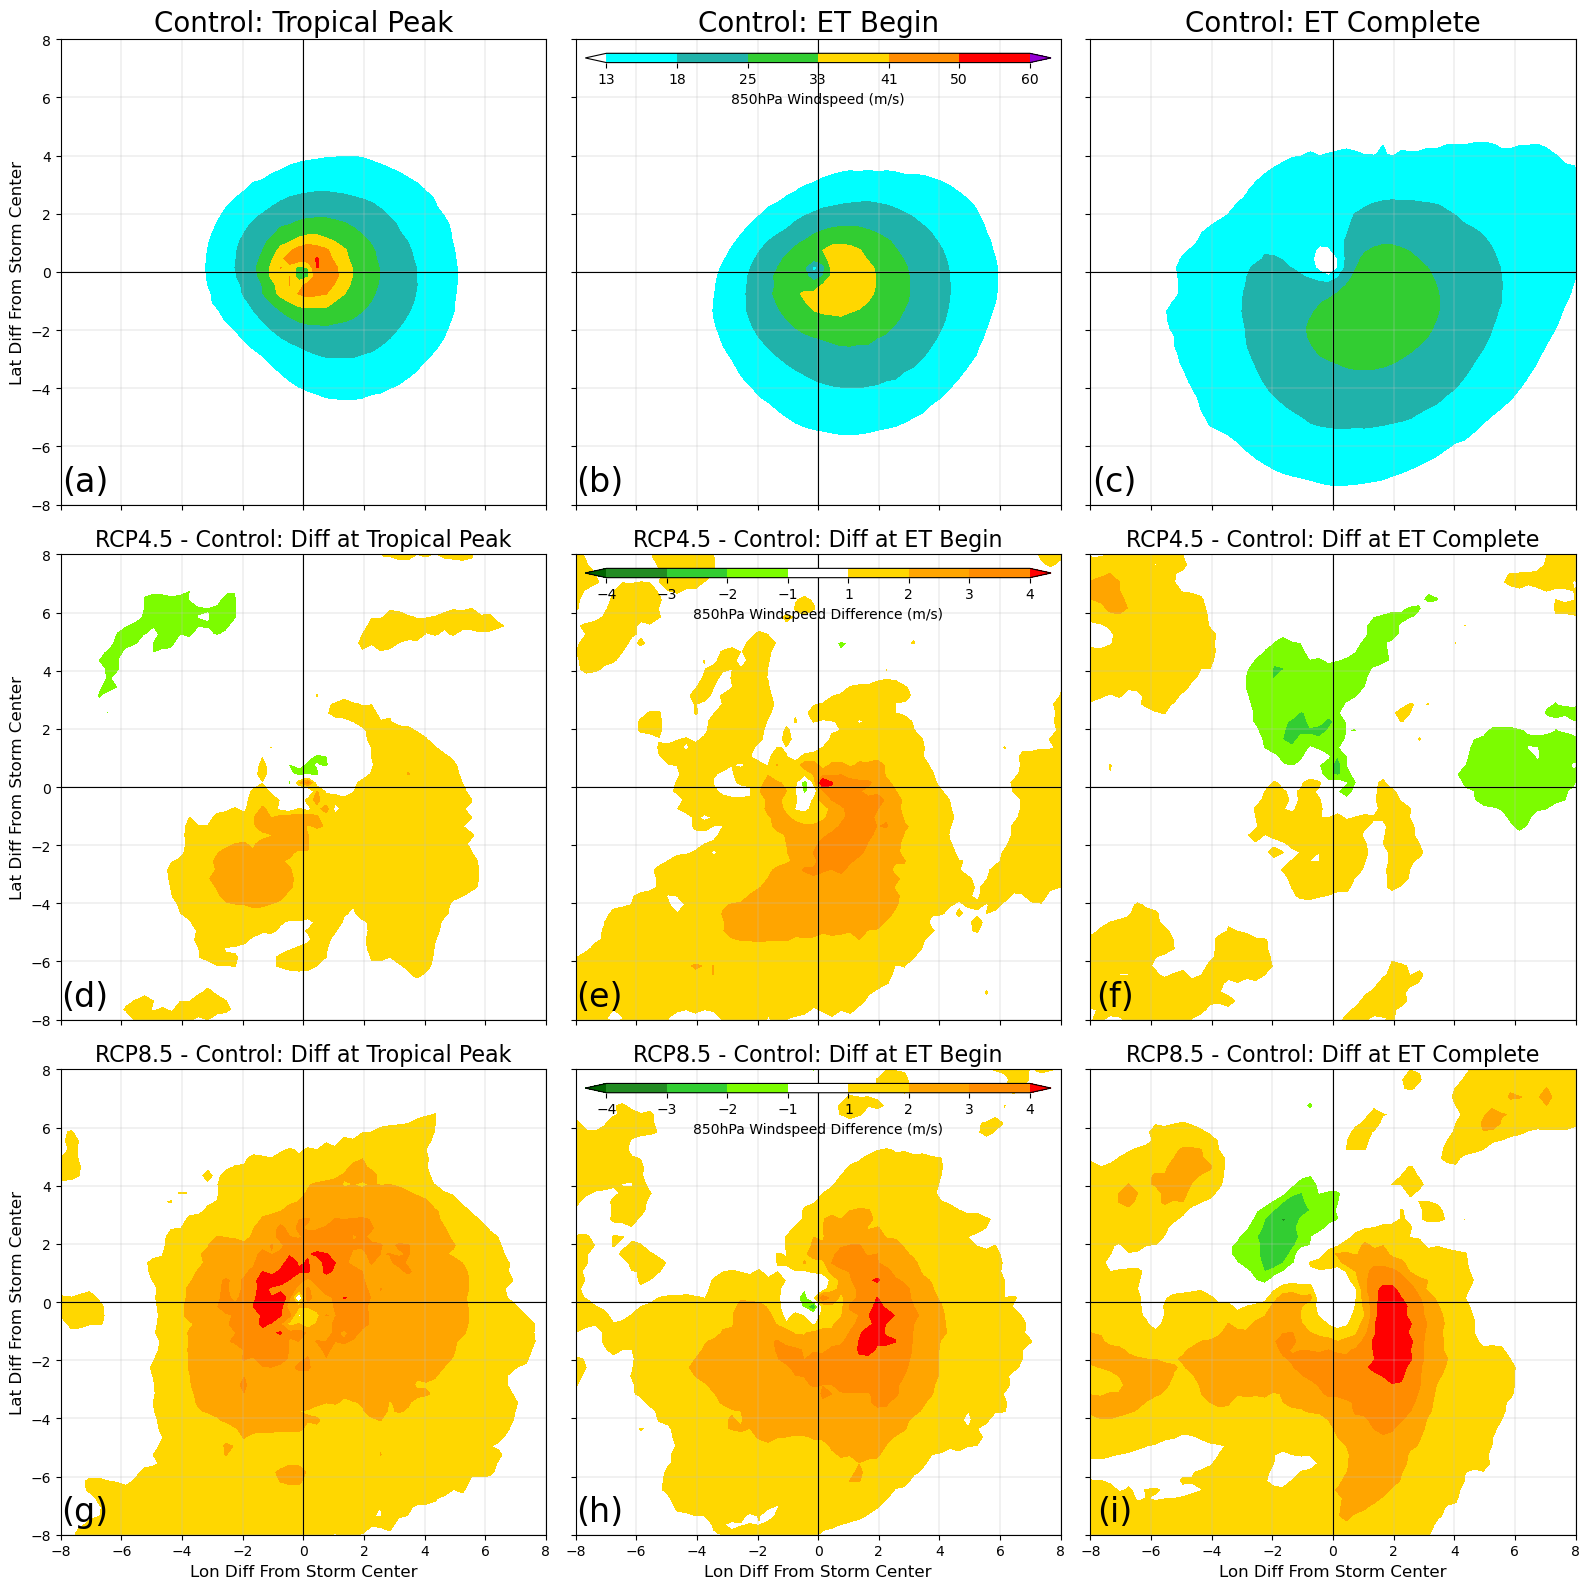

In [50]:
# Plot Mean 850hPa Windspeed Difference Snapshots
Var = "850hPa Windspeed"
Values = [Control_Wind_Snap_Mean, RCP45_Wind_Snap_Mean, RCP85_Wind_Snap_Mean]
Bounds = Windspeed_Bounds
Colours = Windspeed_Colours
Diff_Bounds = Windspeed_Diff_Bounds
Diff_Colours = Windspeed_Diff_Colours
Savefig = True
Figname = 'Wind_850hPa_Snaps_Diff.png'
Snap_Diff_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Colours, \
Diff_Bounds, Diff_Colours, Savefig, Figname)

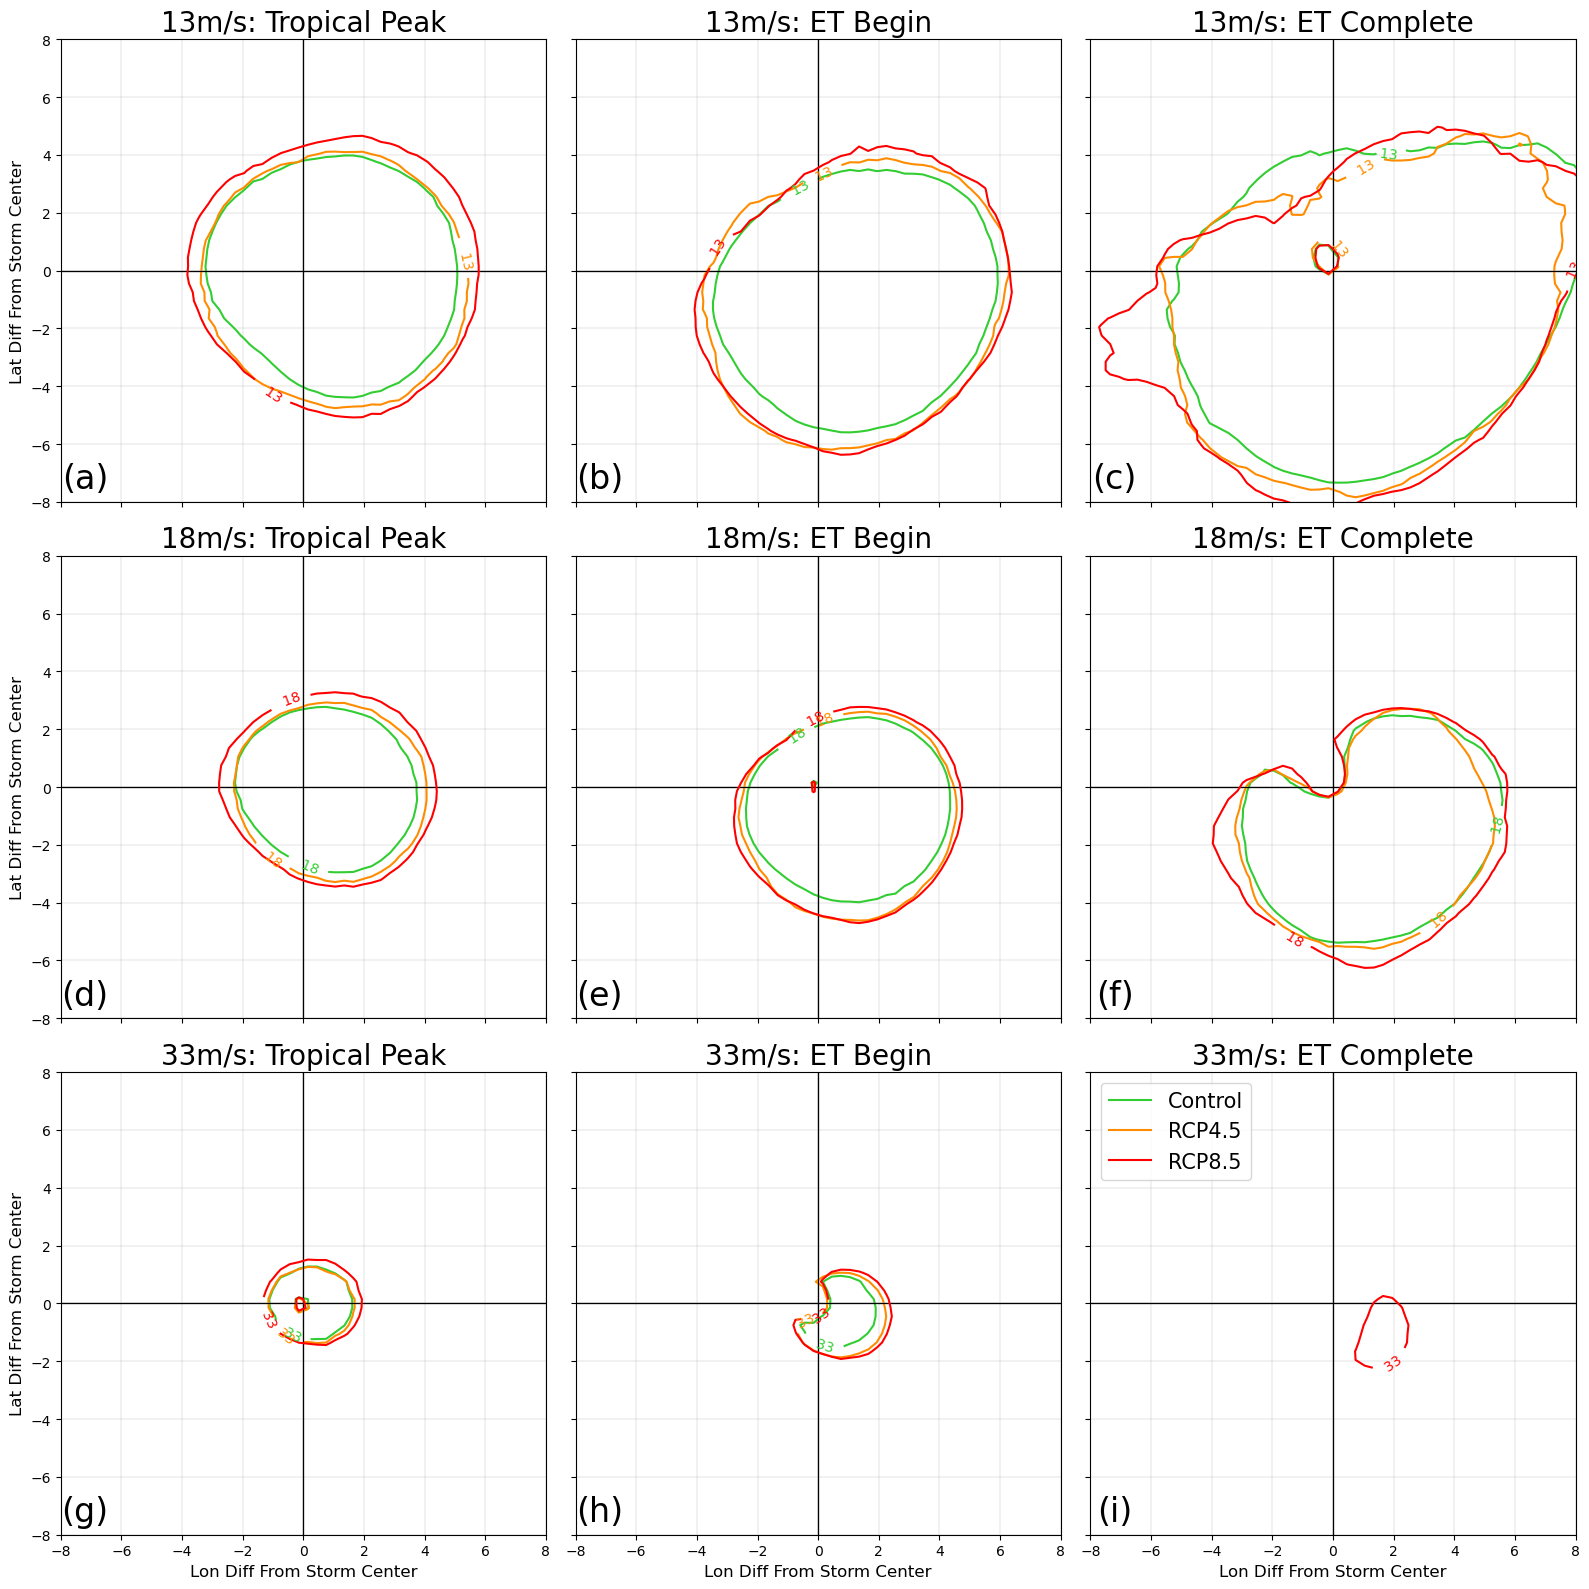

In [119]:
# Plot Mean 850hPa Windspeed Contour Line Snapshots
Var = "850hPa Windspeed"
Values = [Control_Wind_Snap_Mean, RCP45_Wind_Snap_Mean, RCP85_Wind_Snap_Mean]
Bounds = Windspeed_Line_Bounds
Savefig = True
Figname = 'Wind_850hPa_Snaps_Lines.png'
Snap_Line_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Savefig, Figname)

In [52]:
# Calculate Mean Precip Rate Snapshots
Var = "Precip Rate"
Percentile = False
Control_Precip_Rate_Snap_Mean = Snaps_Combine(Var, Control_Subset_Codes, Control_Data, Control_ET, \
Control_Compo, Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc, Percentile)
RCP45_Precip_Rate_Snap_Mean = Snaps_Combine(Var, RCP45_Subset_Codes, RCP45_Data, RCP45_ET, \
RCP45_Compo, RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc, Percentile)
RCP85_Precip_Rate_Snap_Mean = Snaps_Combine(Var, RCP85_Subset_Codes, RCP85_Data, RCP85_ET, \
RCP85_Compo, RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc, Percentile)

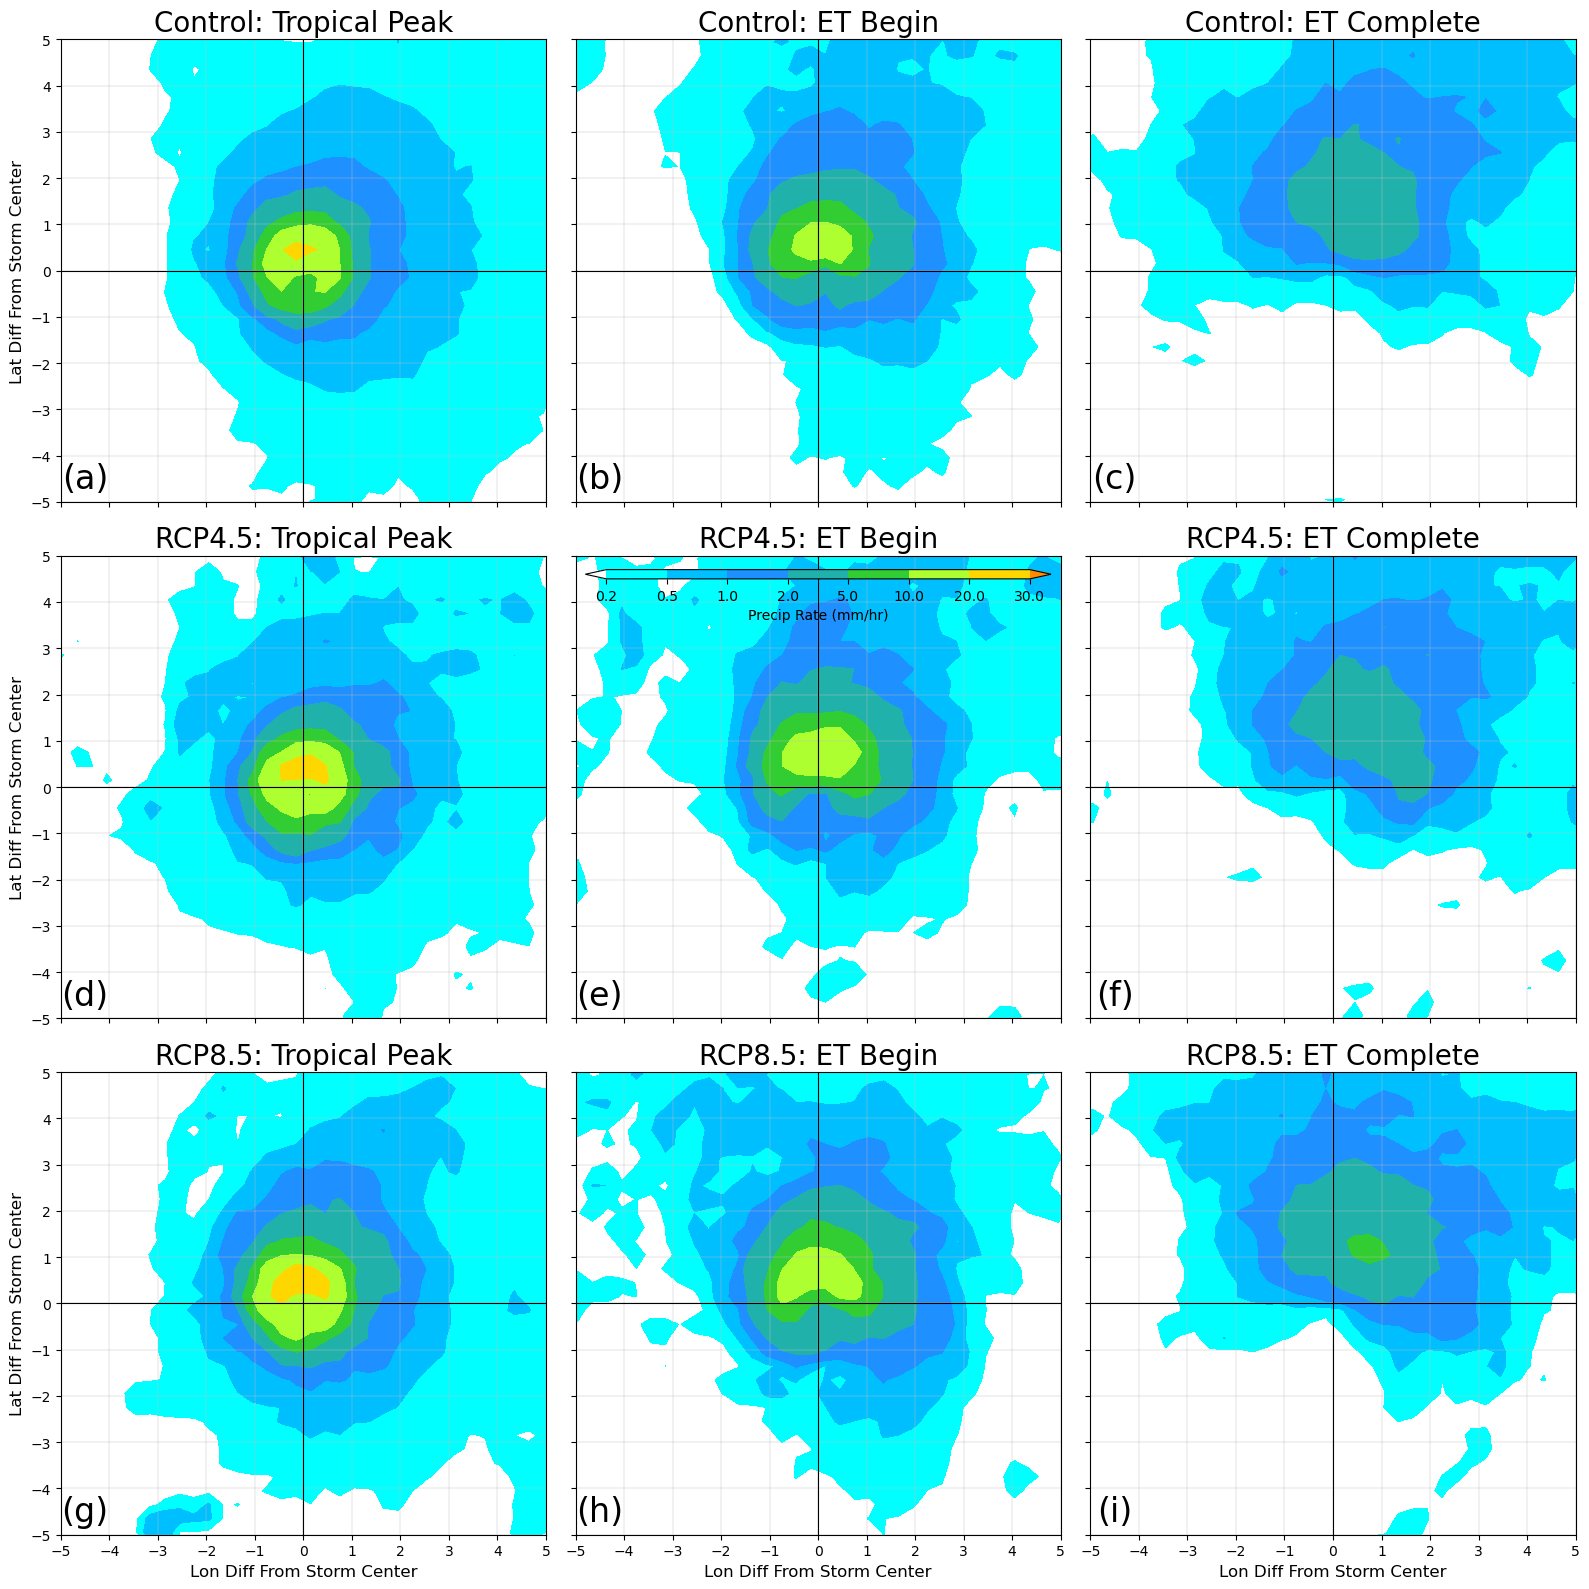

In [53]:
# Plot Mean Precip Rate Snapshots
Var = "Precip Rate"
Values = [Control_Precip_Rate_Snap_Mean, RCP45_Precip_Rate_Snap_Mean, RCP85_Precip_Rate_Snap_Mean]
Bounds = Precip_Rate_Bounds
Colours = Precip_Rate_Colours
Savefig = True
Figname = 'Precip_Rate_Snaps_Colours.png'
Snap_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Colours, Savefig, Figname)

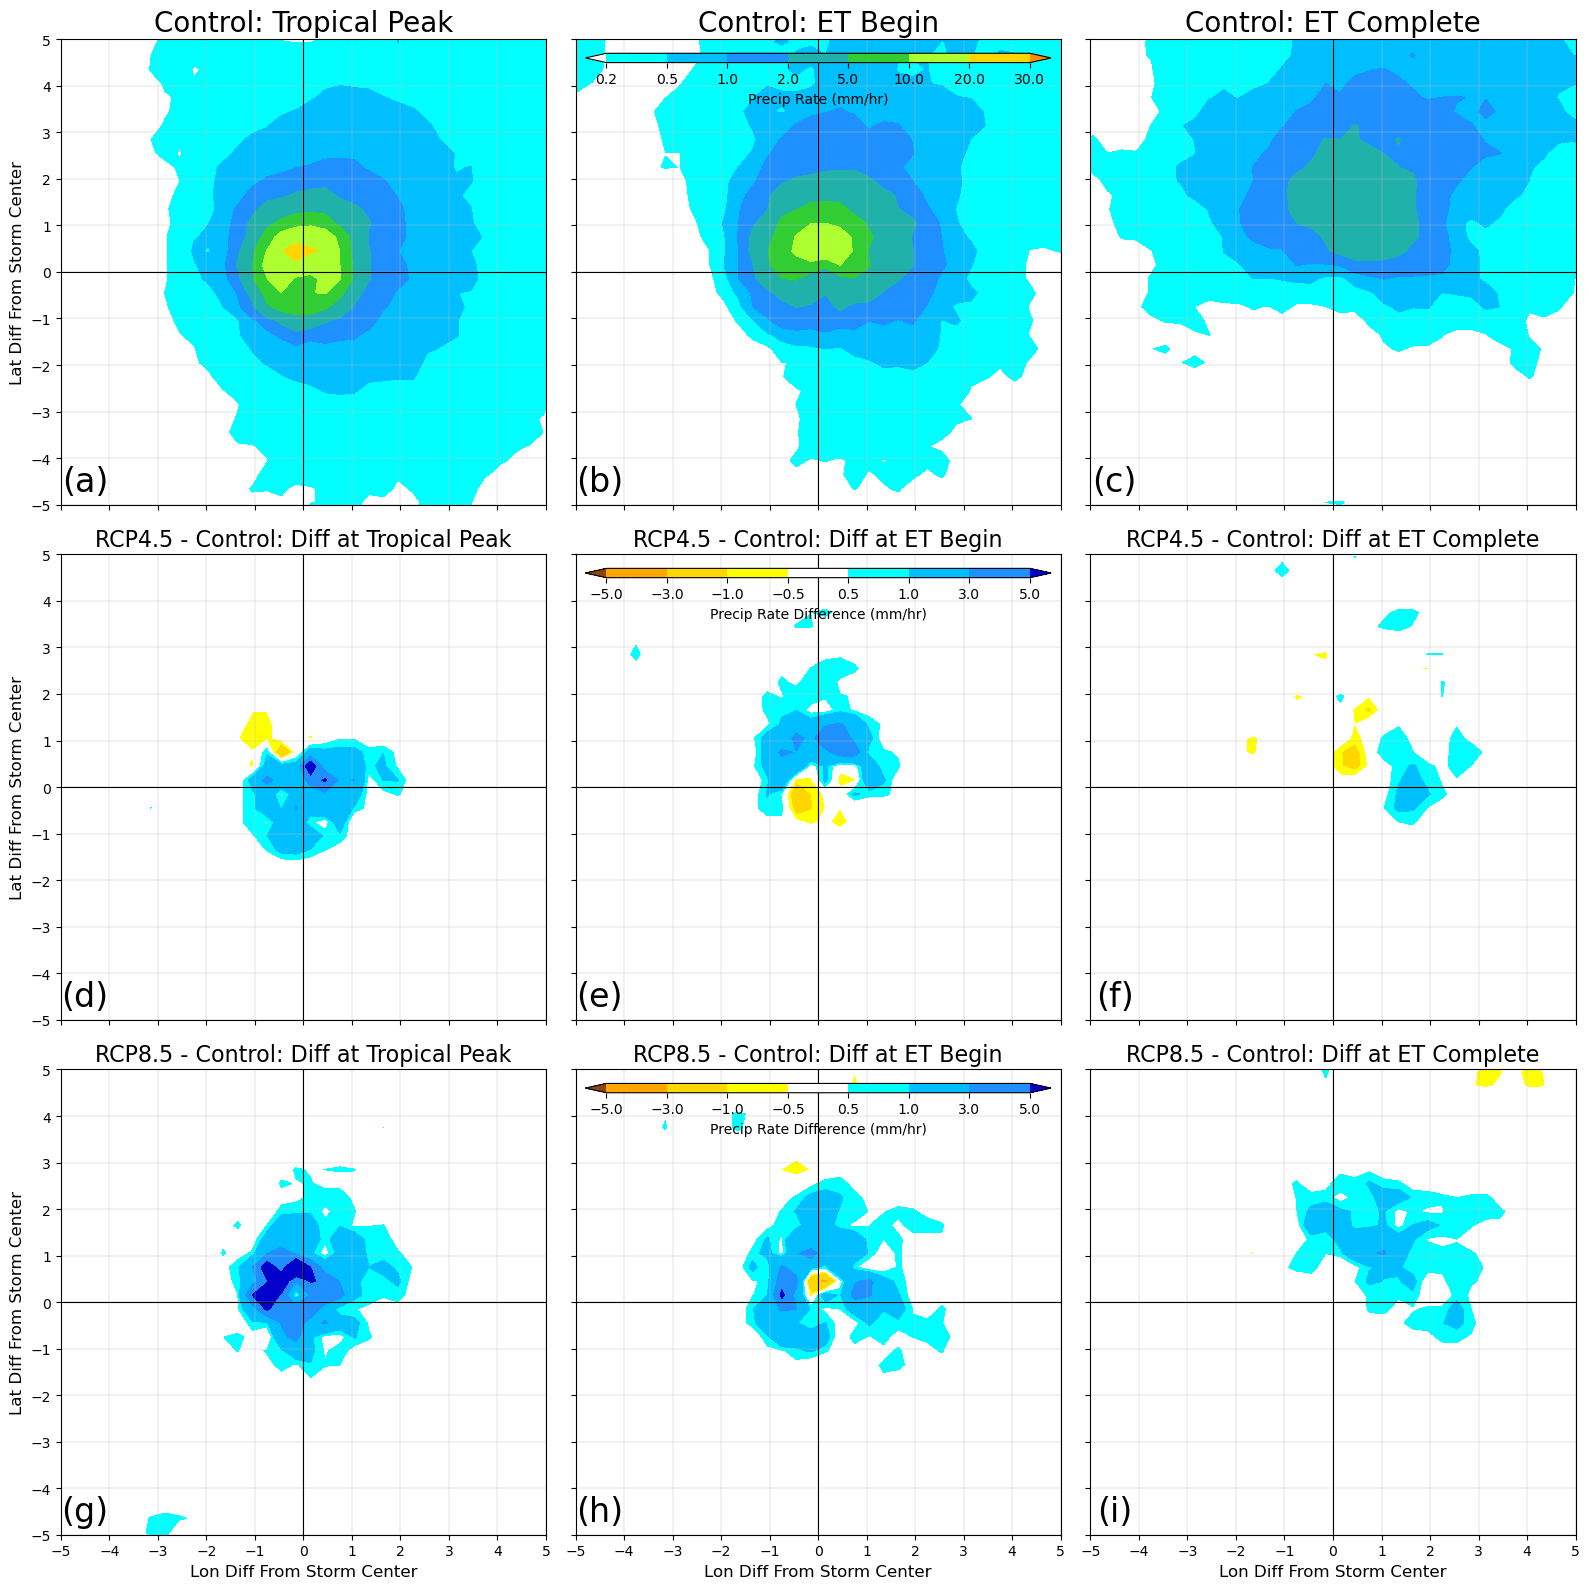

In [54]:
# Plot Mean Precip Rate Difference Snapshots
Var = "Precip Rate"
Values = [Control_Precip_Rate_Snap_Mean, RCP45_Precip_Rate_Snap_Mean, RCP85_Precip_Rate_Snap_Mean]
Bounds = Precip_Rate_Bounds
Colours = Precip_Rate_Colours
Diff_Bounds = Precip_Rate_Diff_Bounds
Diff_Colours = Precip_Rate_Diff_Colours
Savefig = True
Figname = 'Precip_Rate_Snaps_Diff.png'
Snap_Diff_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Colours, \
Diff_Bounds, Diff_Colours, Savefig, Figname)

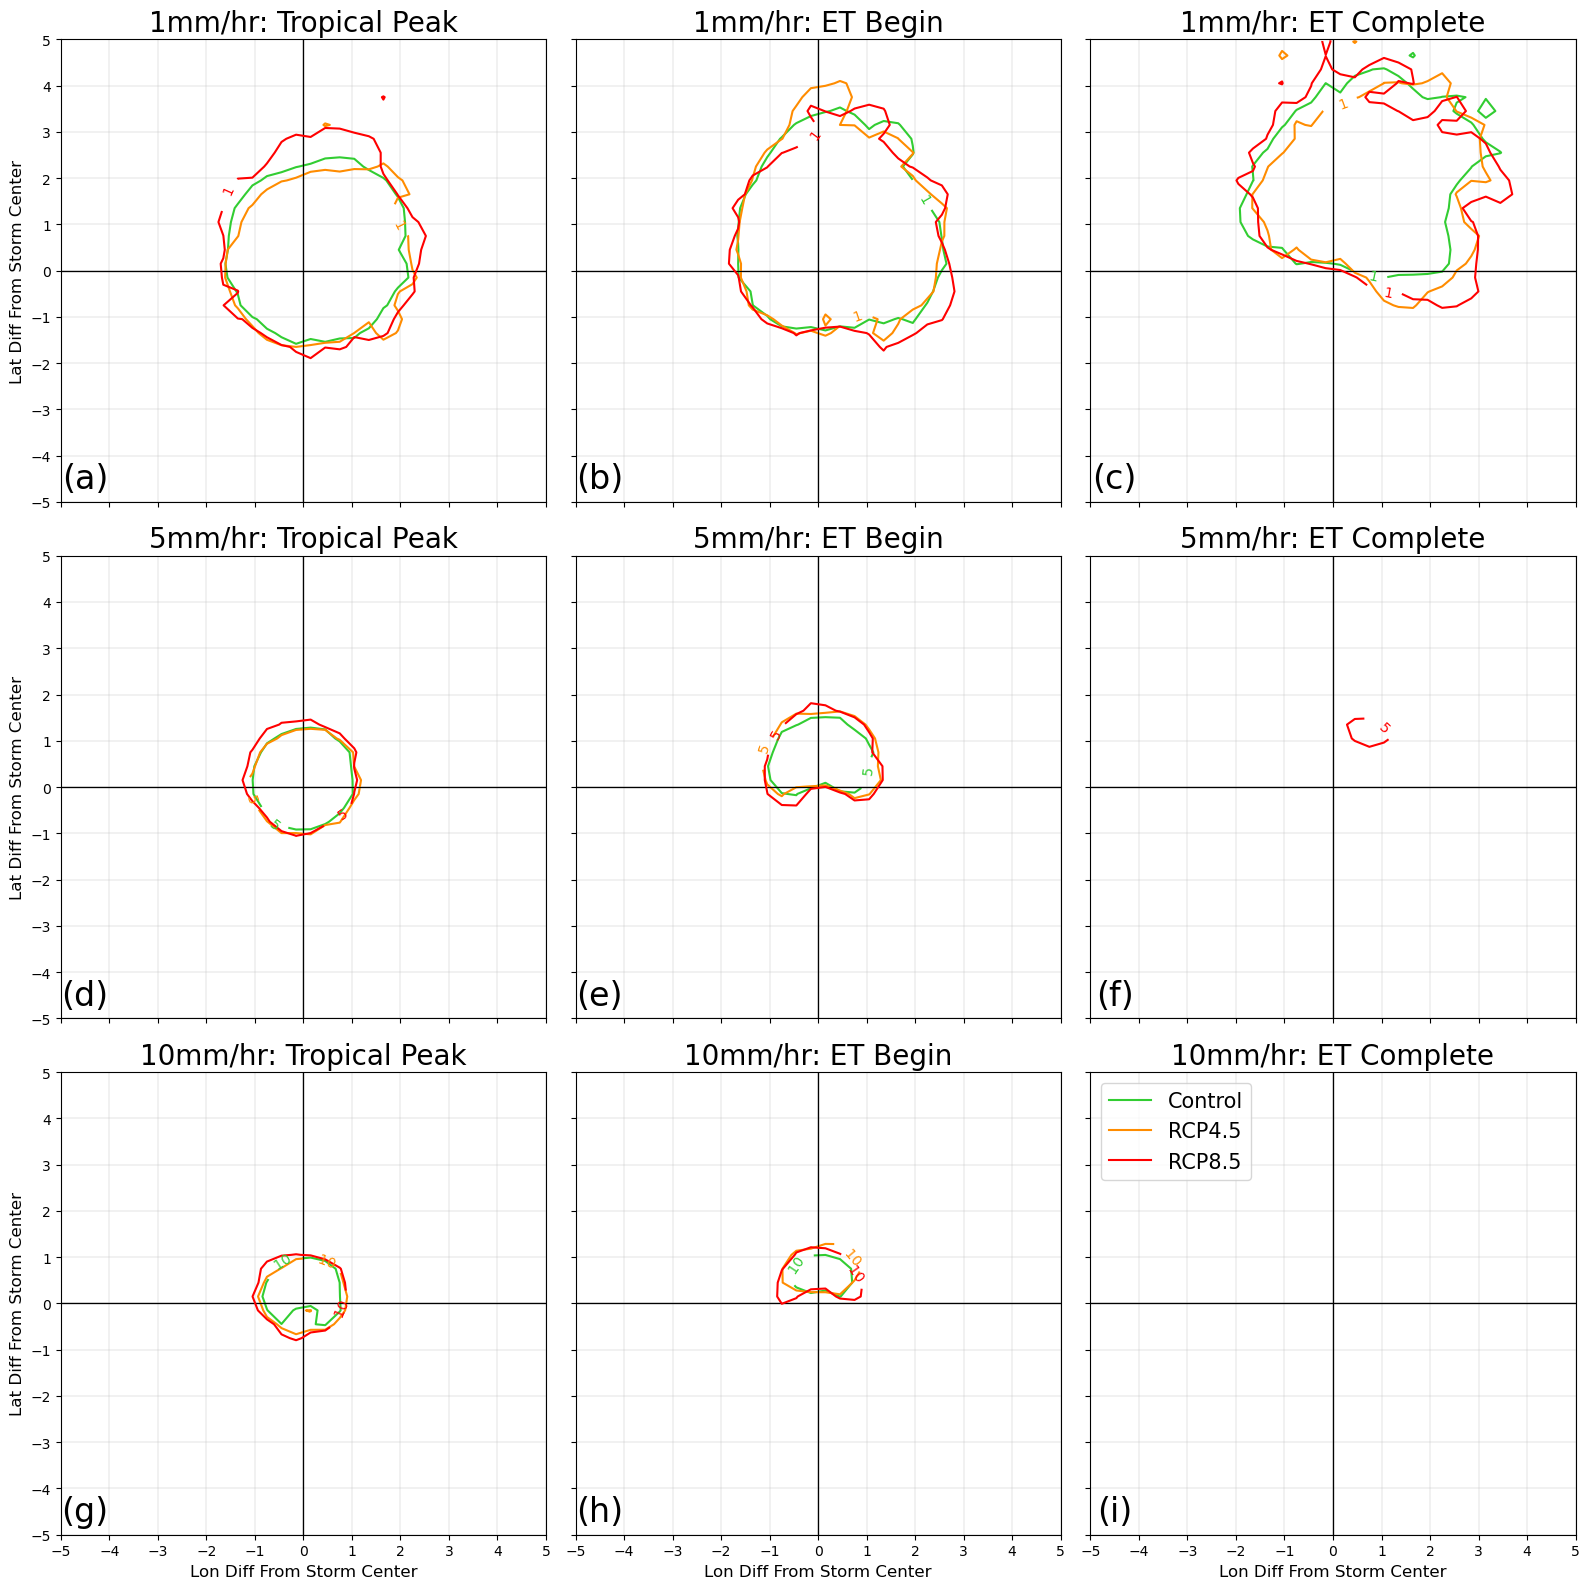

In [118]:
# Plot Mean Precip Rate Contour Line Snapshots
Var = "Precip Rate"
Values = [Control_Precip_Rate_Snap_Mean, RCP45_Precip_Rate_Snap_Mean, RCP85_Precip_Rate_Snap_Mean]
Bounds = Precip_Rate_Line_Bounds
Savefig = True
Figname = 'Precip_Rate_Snaps_Lines.png'
Snap_Line_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Savefig, Figname)

In [56]:
# Calculate Mean Precipitable Water Snapshots
Var = "Precipitable Water"
Percentile = False
Control_Precip_Water_Snap_Mean = Snaps_Combine(Var, Control_Subset_Codes, Control_Data, Control_ET, \
Control_Compo, Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc, Percentile)
RCP45_Precip_Water_Snap_Mean = Snaps_Combine(Var, RCP45_Subset_Codes, RCP45_Data, RCP45_ET, \
RCP45_Compo, RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc, Percentile)
RCP85_Precip_Water_Snap_Mean = Snaps_Combine(Var, RCP85_Subset_Codes, RCP85_Data, RCP85_ET, \
RCP85_Compo, RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc, Percentile)

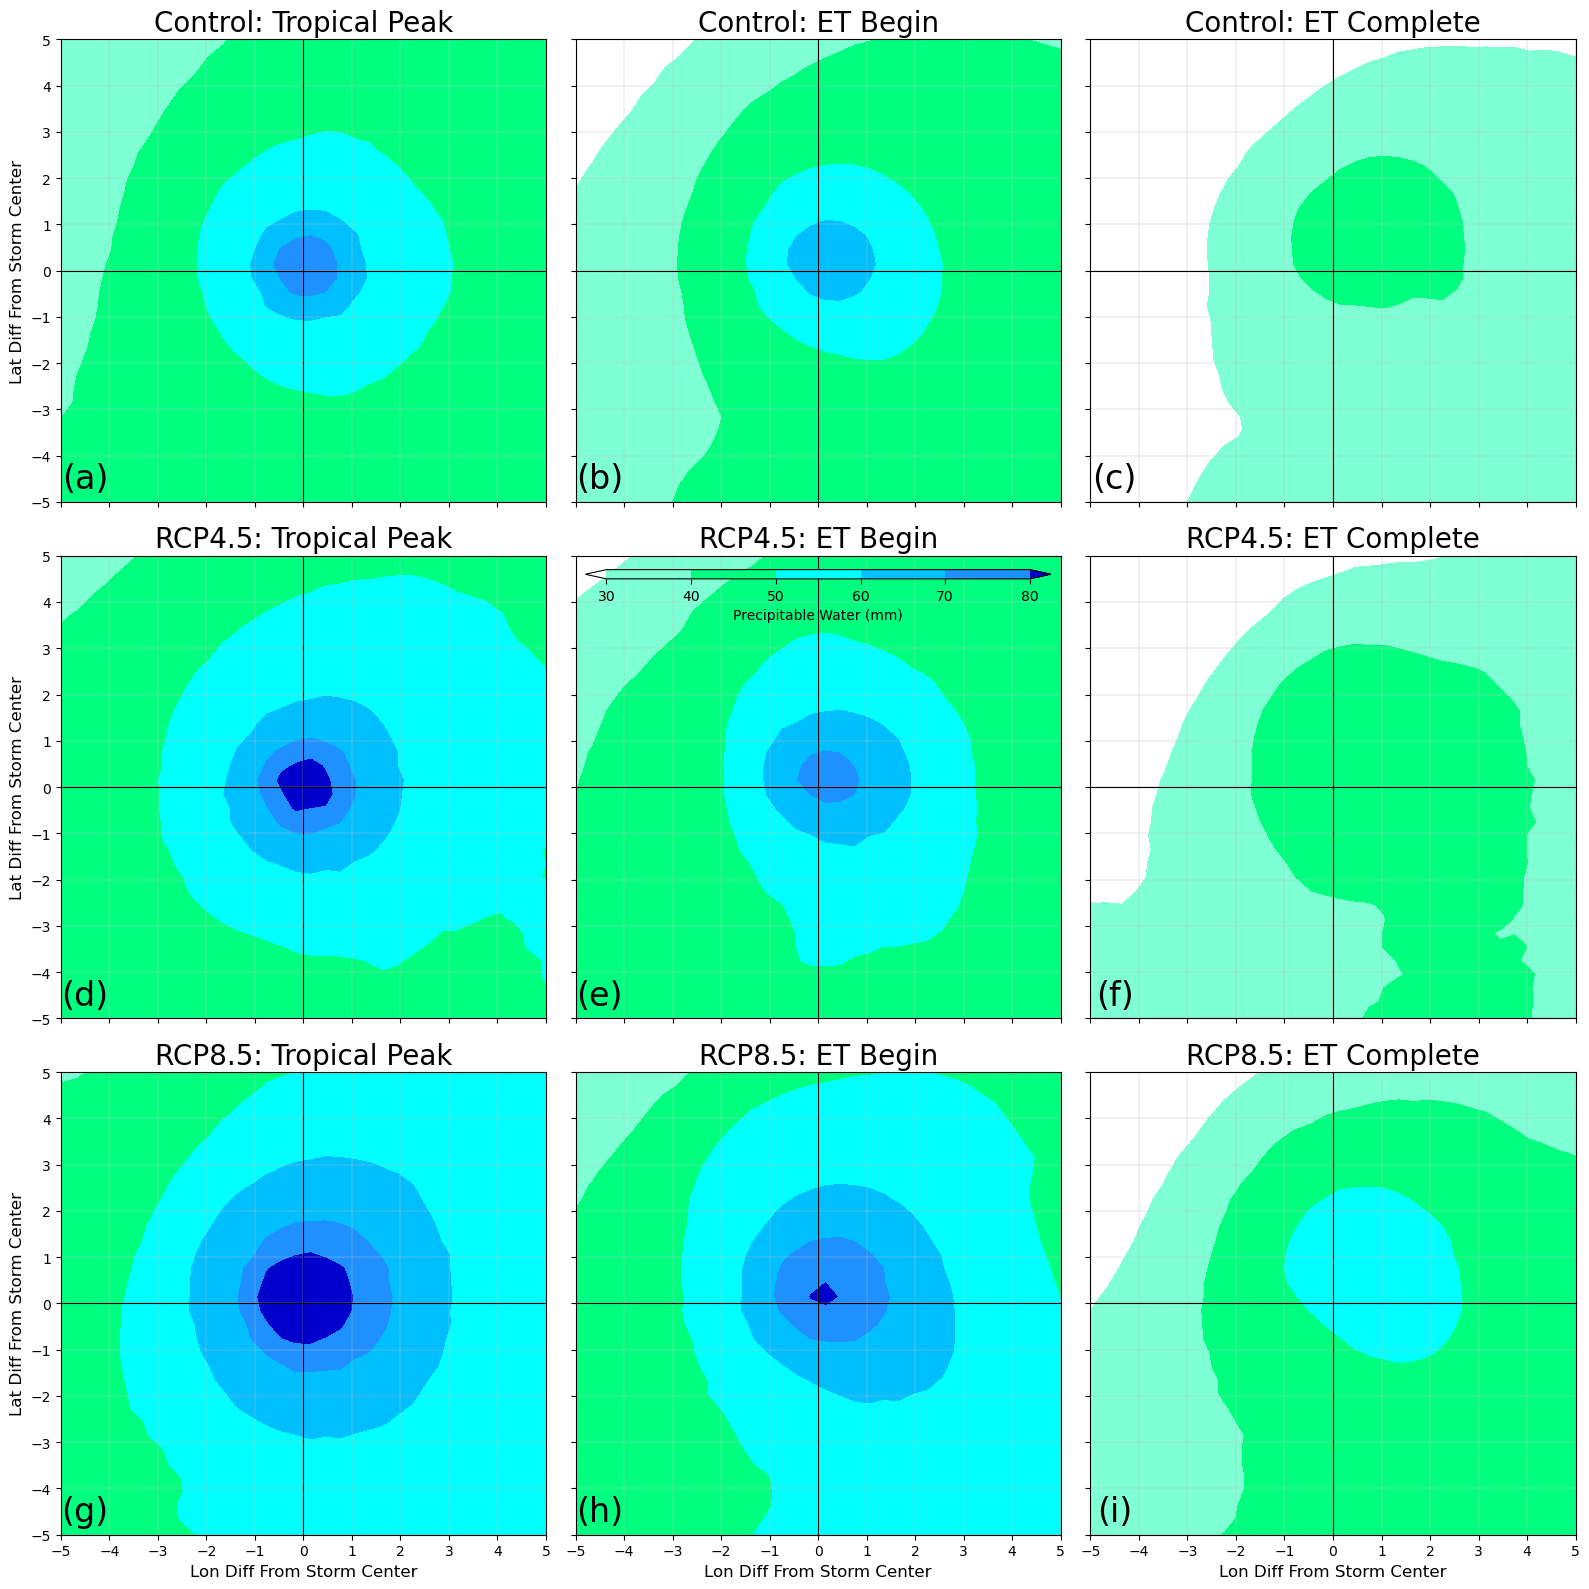

In [57]:
# Plot Mean Precipitable Water Snapshots
Var = "Precipitable Water"
Values = [Control_Precip_Water_Snap_Mean, RCP45_Precip_Water_Snap_Mean, RCP85_Precip_Water_Snap_Mean]
Bounds = Precip_Water_Bounds
Colours = Precip_Water_Colours
Savefig = True
Figname = 'Precip_Water_Snaps_Colours.png'
Snap_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Colours, Savefig, Figname)

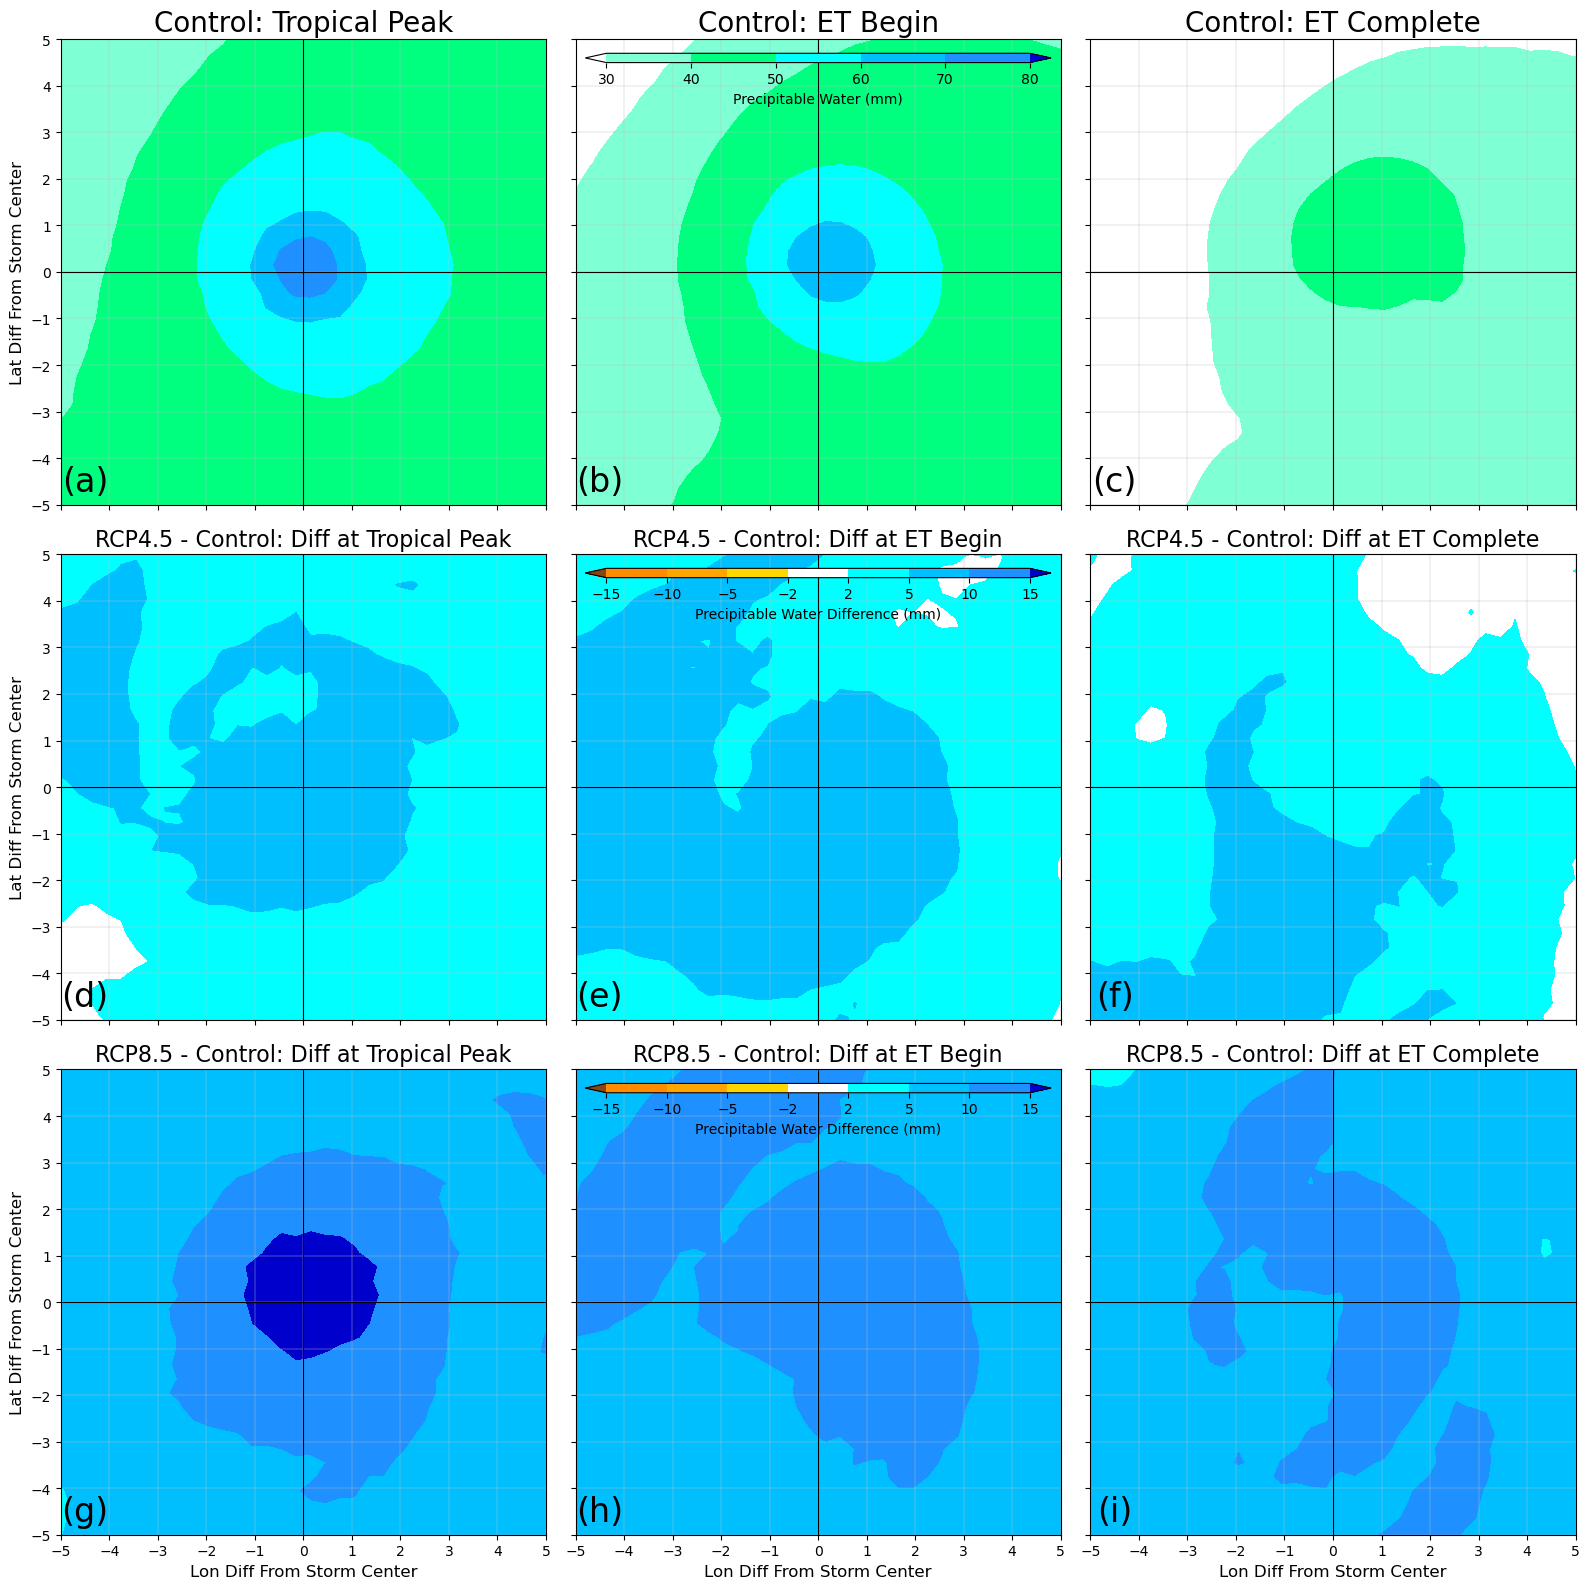

In [58]:
# Plot Mean Precipitable Water Difference Snapshots
Var = "Precipitable Water"
Values = [Control_Precip_Water_Snap_Mean, RCP45_Precip_Water_Snap_Mean, RCP85_Precip_Water_Snap_Mean]
Bounds = Precip_Water_Bounds
Colours = Precip_Water_Colours
Diff_Bounds = Precip_Water_Diff_Bounds
Diff_Colours = Precip_Water_Diff_Colours
Savefig = True
Figname = 'Precip_Water_Snaps_Diff.png'
Snap_Diff_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Colours, \
Diff_Bounds, Diff_Colours, Savefig, Figname)

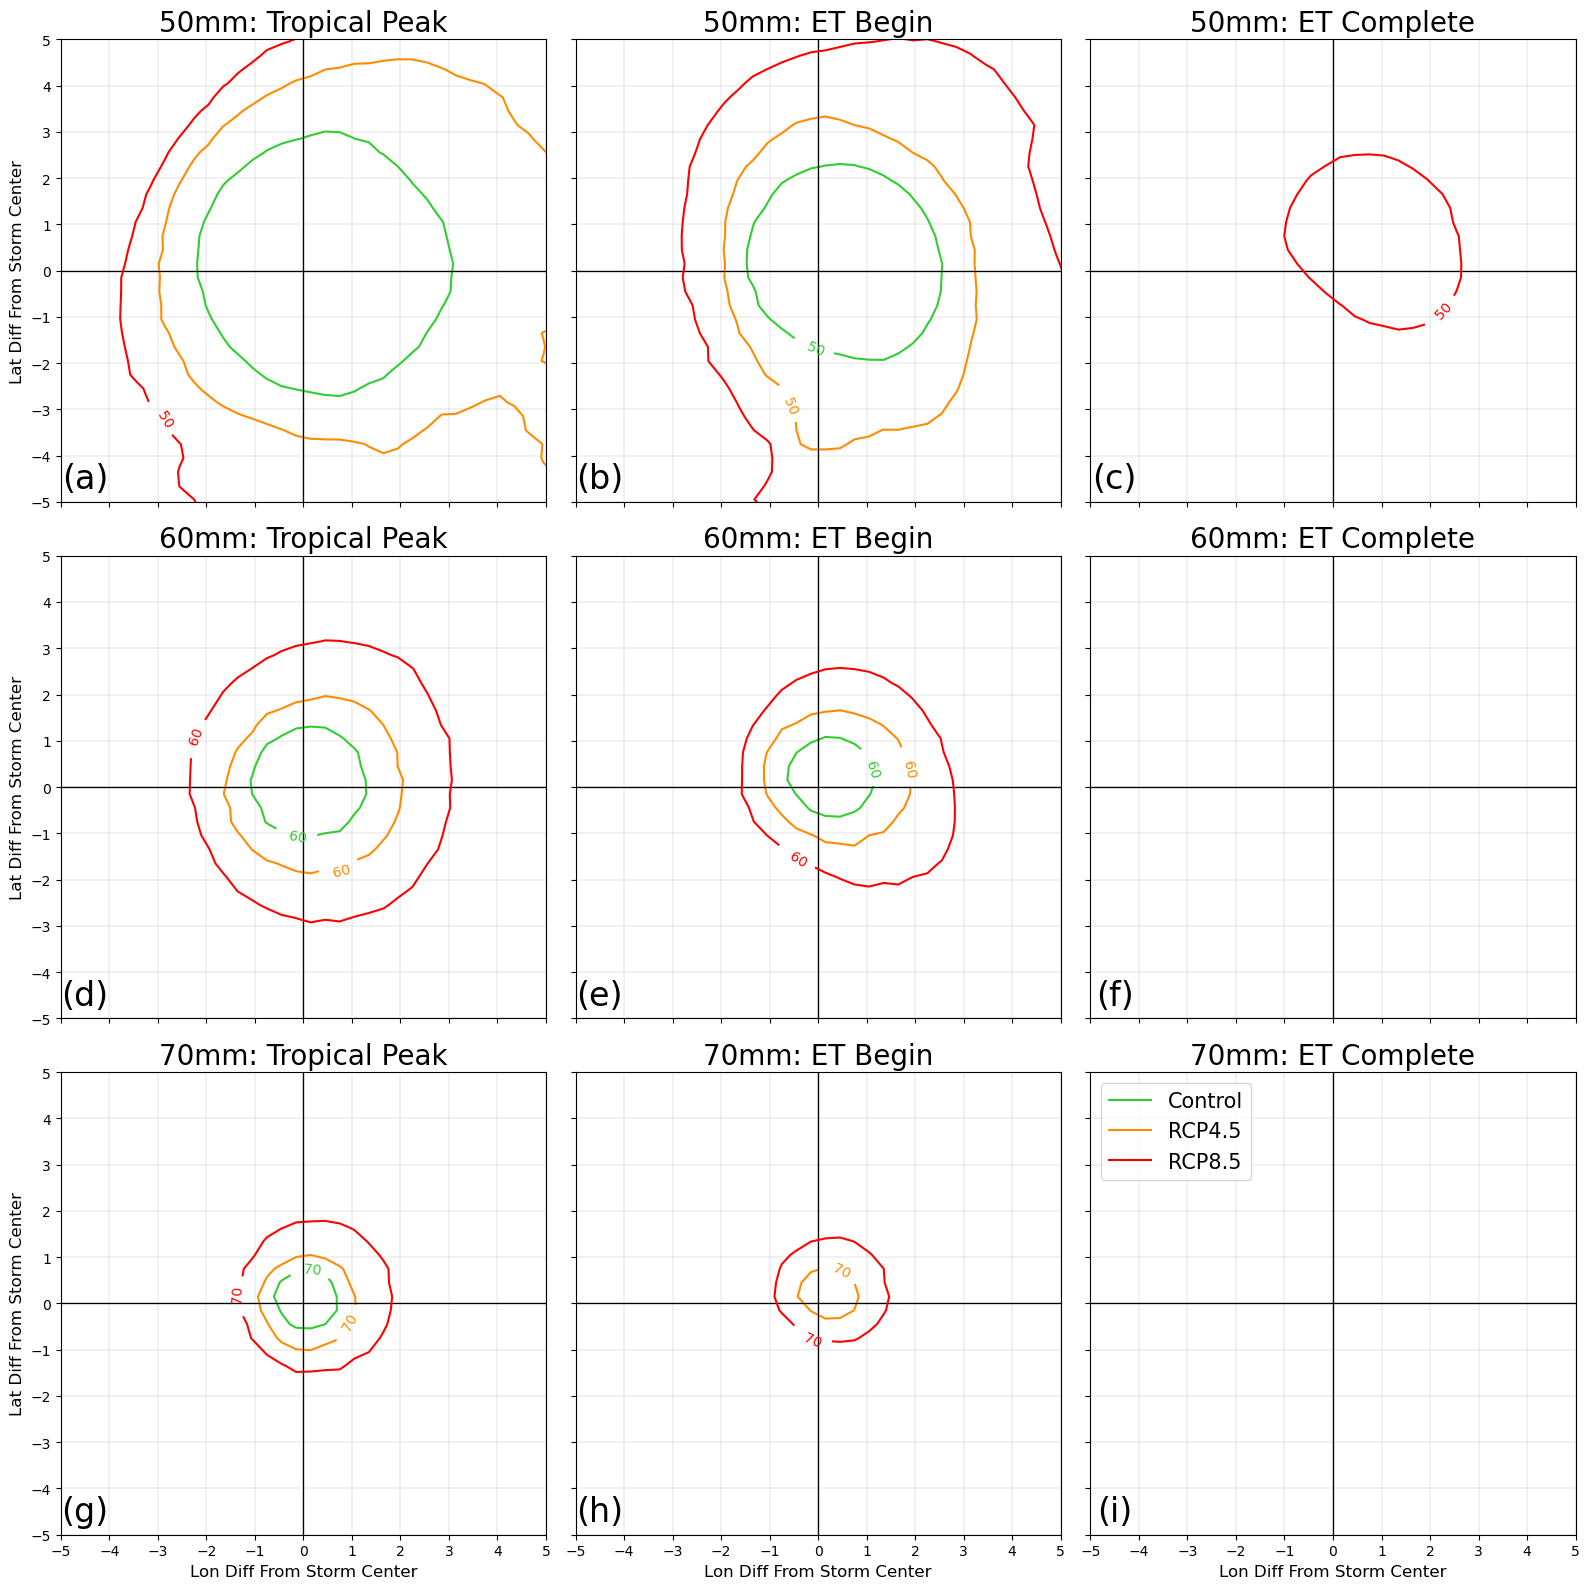

In [120]:
# Plot Mean Precipitable Water Contour Line Snapshots
Var = "Precipitable Water"
Values = [Control_Precip_Water_Snap_Mean, RCP45_Precip_Water_Snap_Mean, RCP85_Precip_Water_Snap_Mean]
Bounds = Precip_Water_Line_Bounds
Savefig = True
Figname = 'Precip_Water_Snaps_Lines.png'
Snap_Line_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Savefig, Figname)

In [60]:
# Calculate Mean Cloud Top Temperature Snapshots
Var = "Cloud Top Temperature"
Percentile = False
Control_Temp_Cloud_Snap_Mean = Snaps_Combine(Var, Control_Subset_Codes, Control_Data, Control_ET, \
Control_Compo, Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc, Percentile)
RCP45_Temp_Cloud_Snap_Mean = Snaps_Combine(Var, RCP45_Subset_Codes, RCP45_Data, RCP45_ET, \
RCP45_Compo, RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc, Percentile)
RCP85_Temp_Cloud_Snap_Mean = Snaps_Combine(Var, RCP85_Subset_Codes, RCP85_Data, RCP85_ET, \
RCP85_Compo, RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc, Percentile)

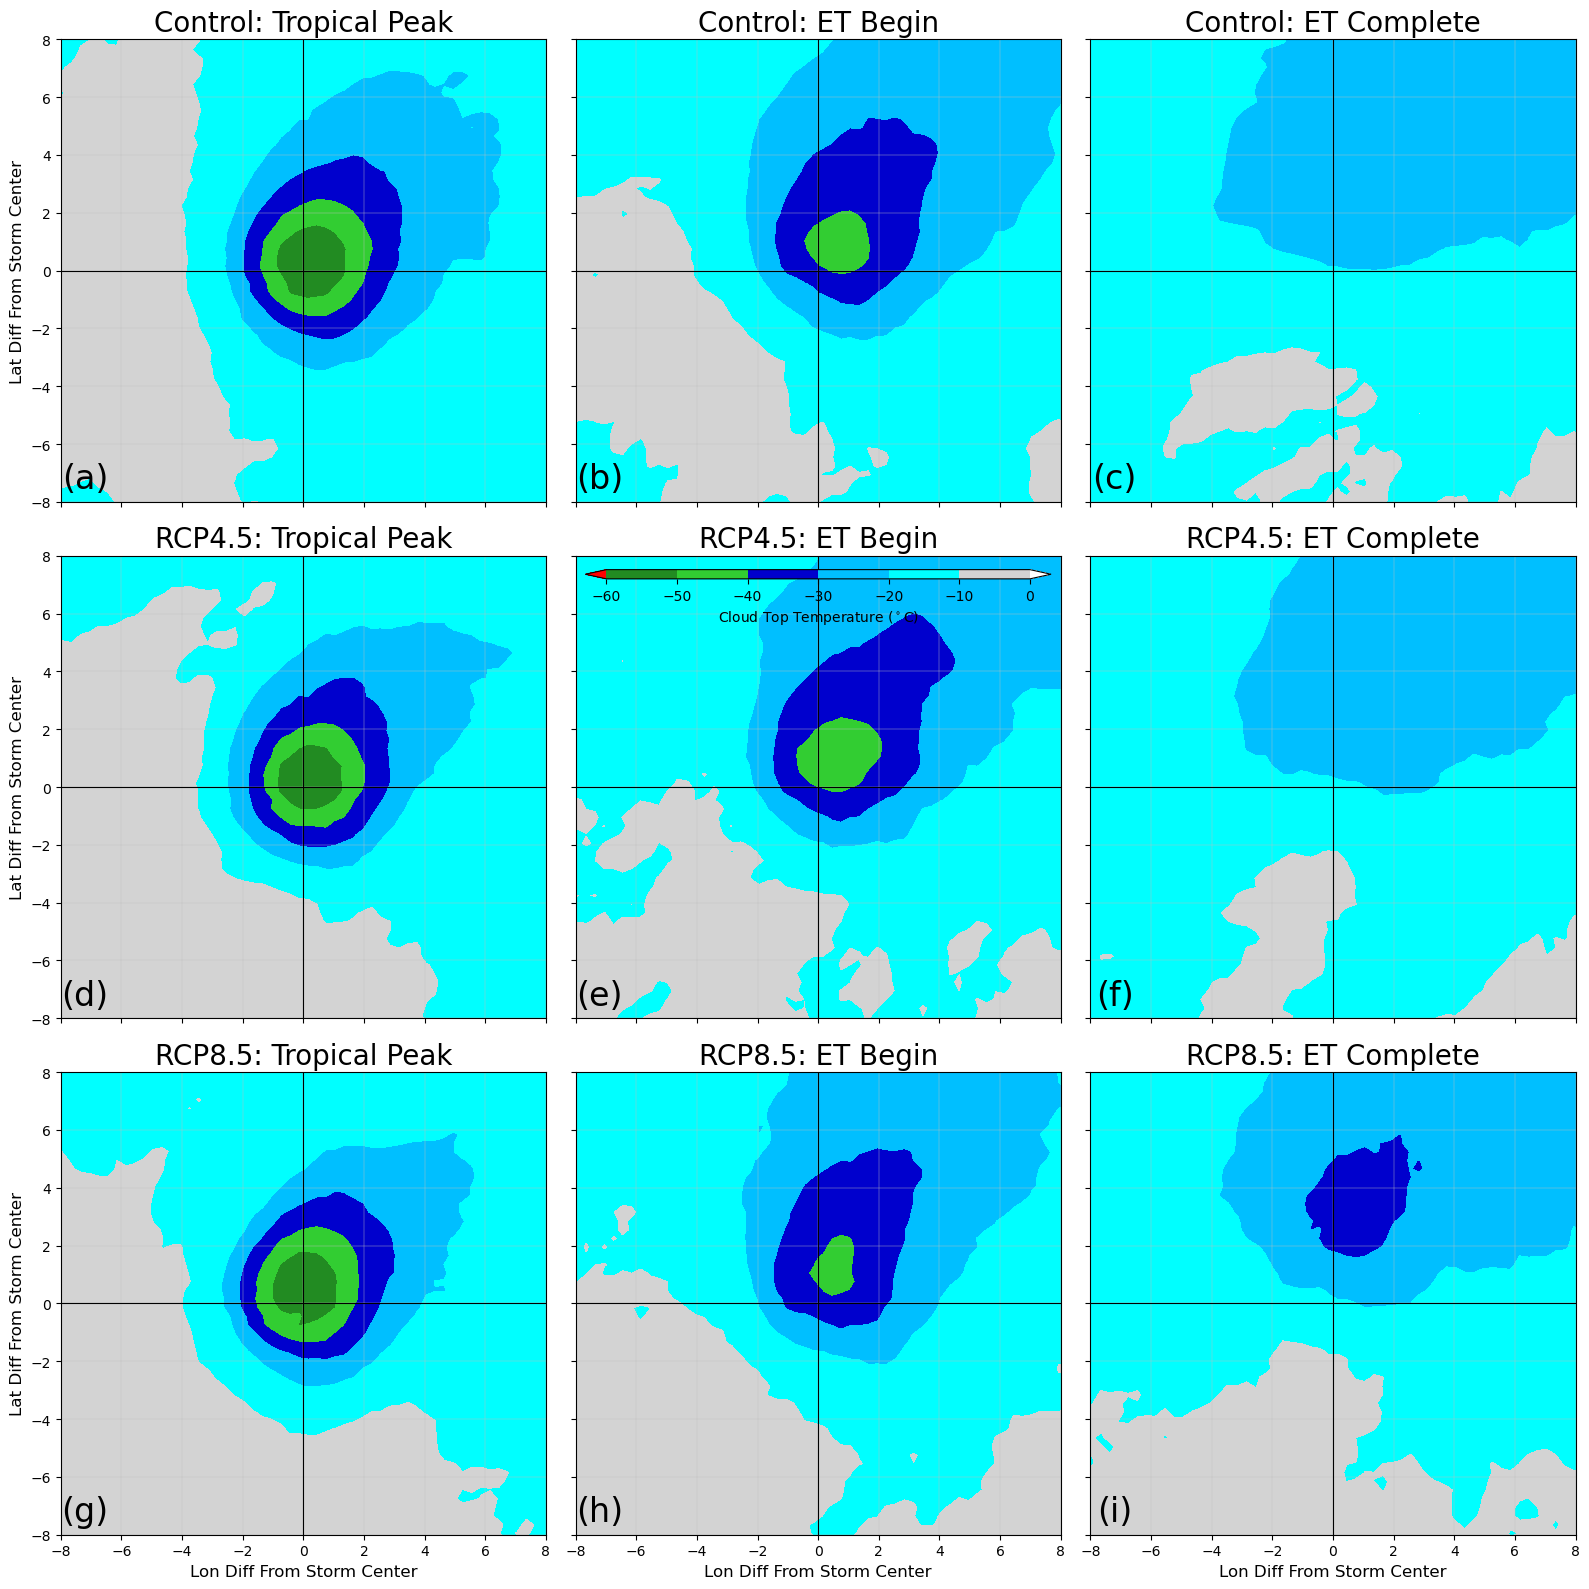

In [61]:
# Plot Mean Cloud Top Temperature Snapshots
Var = "Cloud Top Temperature"
Values = [Control_Temp_Cloud_Snap_Mean, RCP45_Temp_Cloud_Snap_Mean, RCP85_Temp_Cloud_Snap_Mean]
Bounds = Temp_Cloud_Bounds
Colours = Temp_Cloud_Colours
Savefig = True
Figname = 'Temp_Cloud_Snaps_Colours.png'
Snap_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Colours, Savefig, Figname)

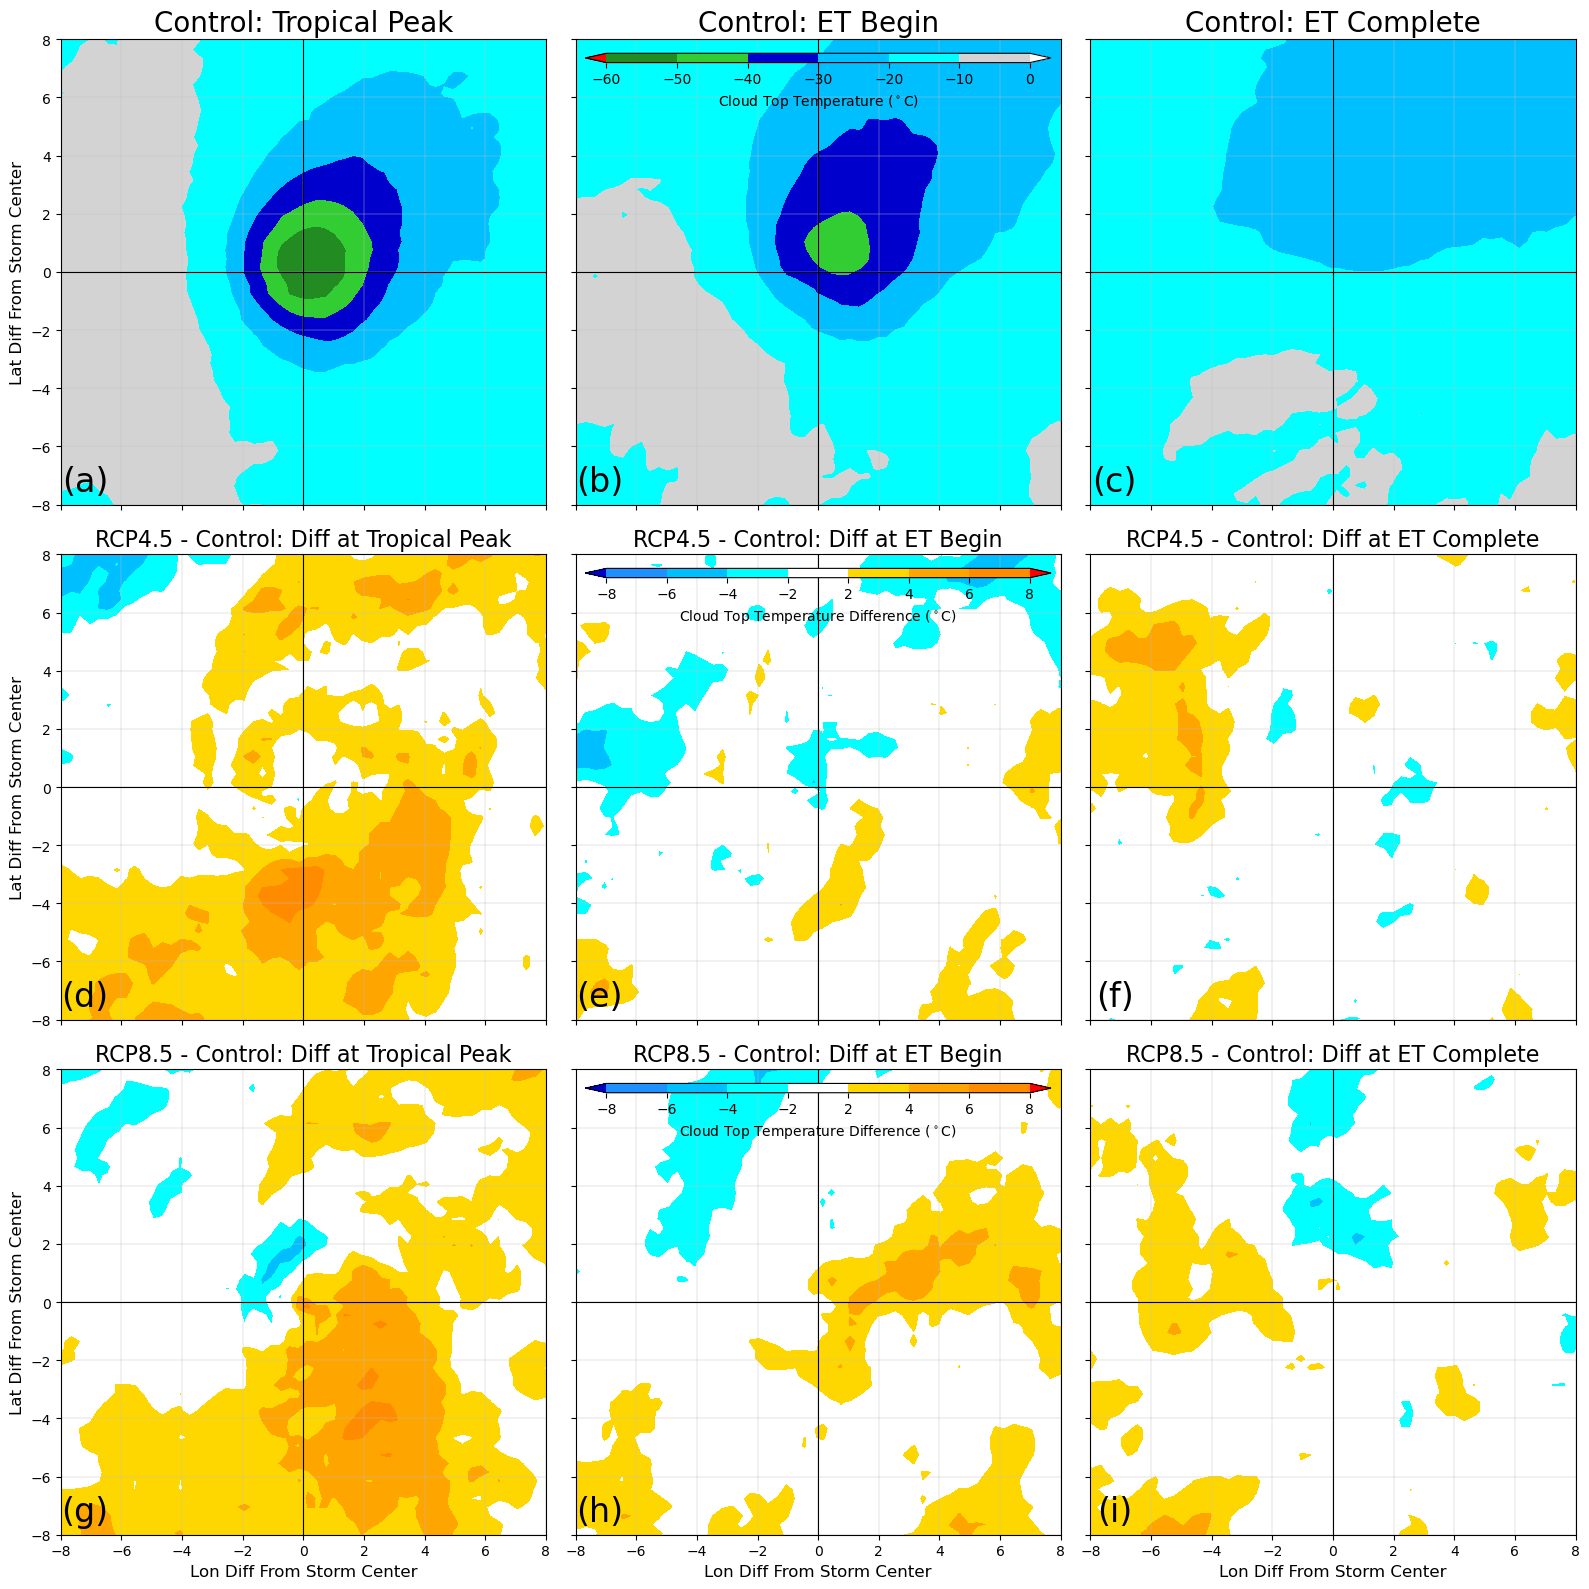

In [62]:
# Plot Mean Cloud Top Temperature Difference Snapshots
Var = "Cloud Top Temperature"
Values = [Control_Temp_Cloud_Snap_Mean, RCP45_Temp_Cloud_Snap_Mean, RCP85_Temp_Cloud_Snap_Mean]
Bounds = Temp_Cloud_Bounds
Colours = Temp_Cloud_Colours
Diff_Bounds = Temp_Cloud_Diff_Bounds
Diff_Colours = Temp_Cloud_Diff_Colours
Savefig = True
Figname = 'Temp_Cloud_Snaps_Diff.png'
Snap_Diff_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Colours, \
Diff_Bounds, Diff_Colours, Savefig, Figname)

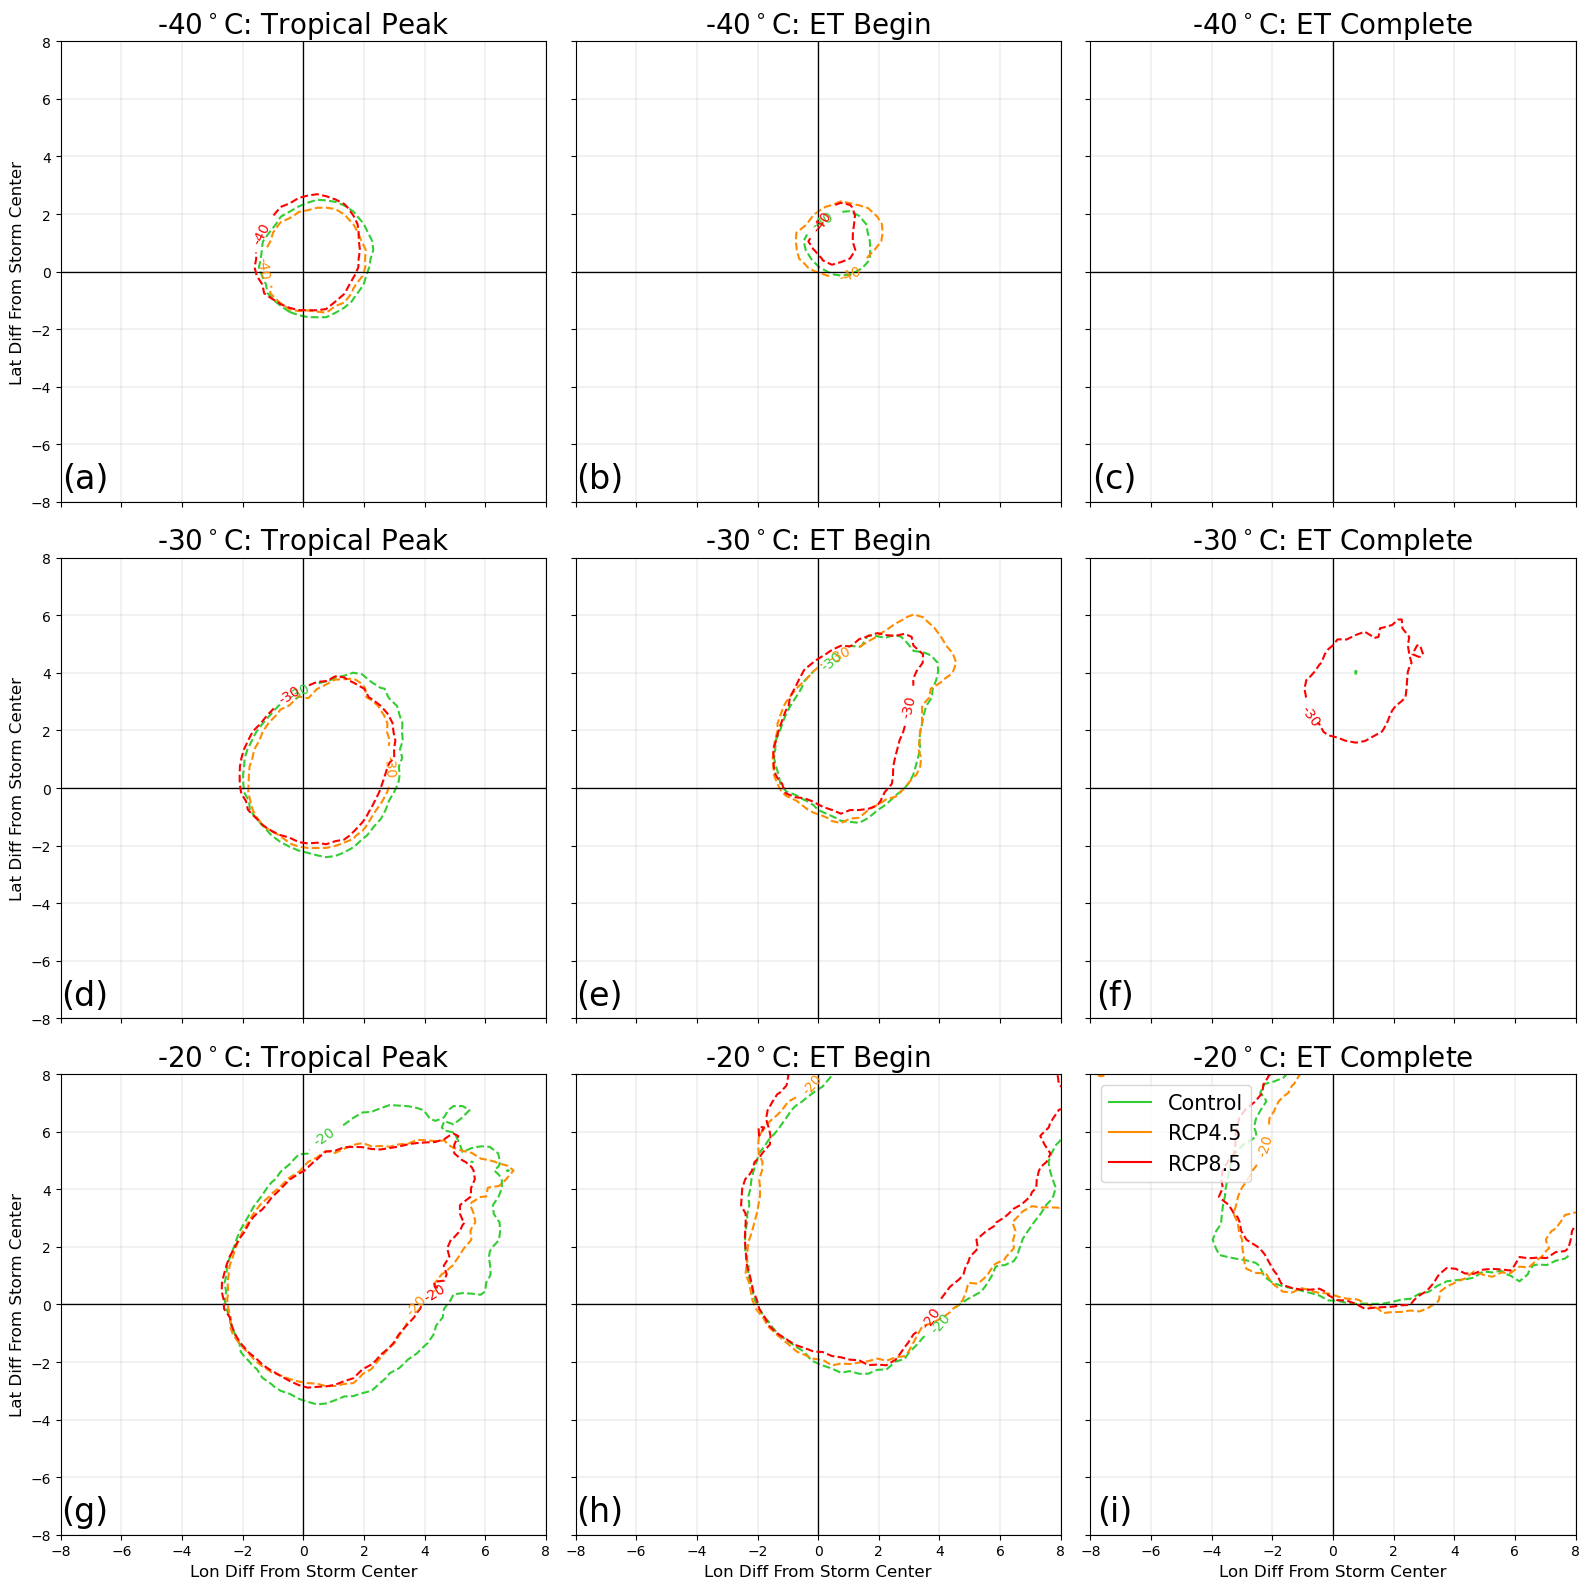

In [121]:
# Plot Mean Cloud Top Temperature Contour Line Snapshots
Var = "Cloud Top Temperature"
Values = [Control_Temp_Cloud_Snap_Mean, RCP45_Temp_Cloud_Snap_Mean, RCP85_Temp_Cloud_Snap_Mean]
Bounds = Temp_Cloud_Line_Bounds
Savefig = True
Figname = 'Temp_Cloud_Snaps_Lines.png'
Snap_Line_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Savefig, Figname)

In [64]:
# Calculate Mean Surface Temperature Snapshots
Var = "Surface Temperature"
Percentile = False
Control_Temp_Sfc_Snap_Mean = Snaps_Combine(Var, Control_Subset_Codes, Control_Data, Control_ET, \
Control_Compo, Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc, Percentile)
RCP45_Temp_Sfc_Snap_Mean = Snaps_Combine(Var, RCP45_Subset_Codes, RCP45_Data, RCP45_ET, \
RCP45_Compo, RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc, Percentile)
RCP85_Temp_Sfc_Snap_Mean = Snaps_Combine(Var, RCP85_Subset_Codes, RCP85_Data, RCP85_ET, \
RCP85_Compo, RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc, Percentile)

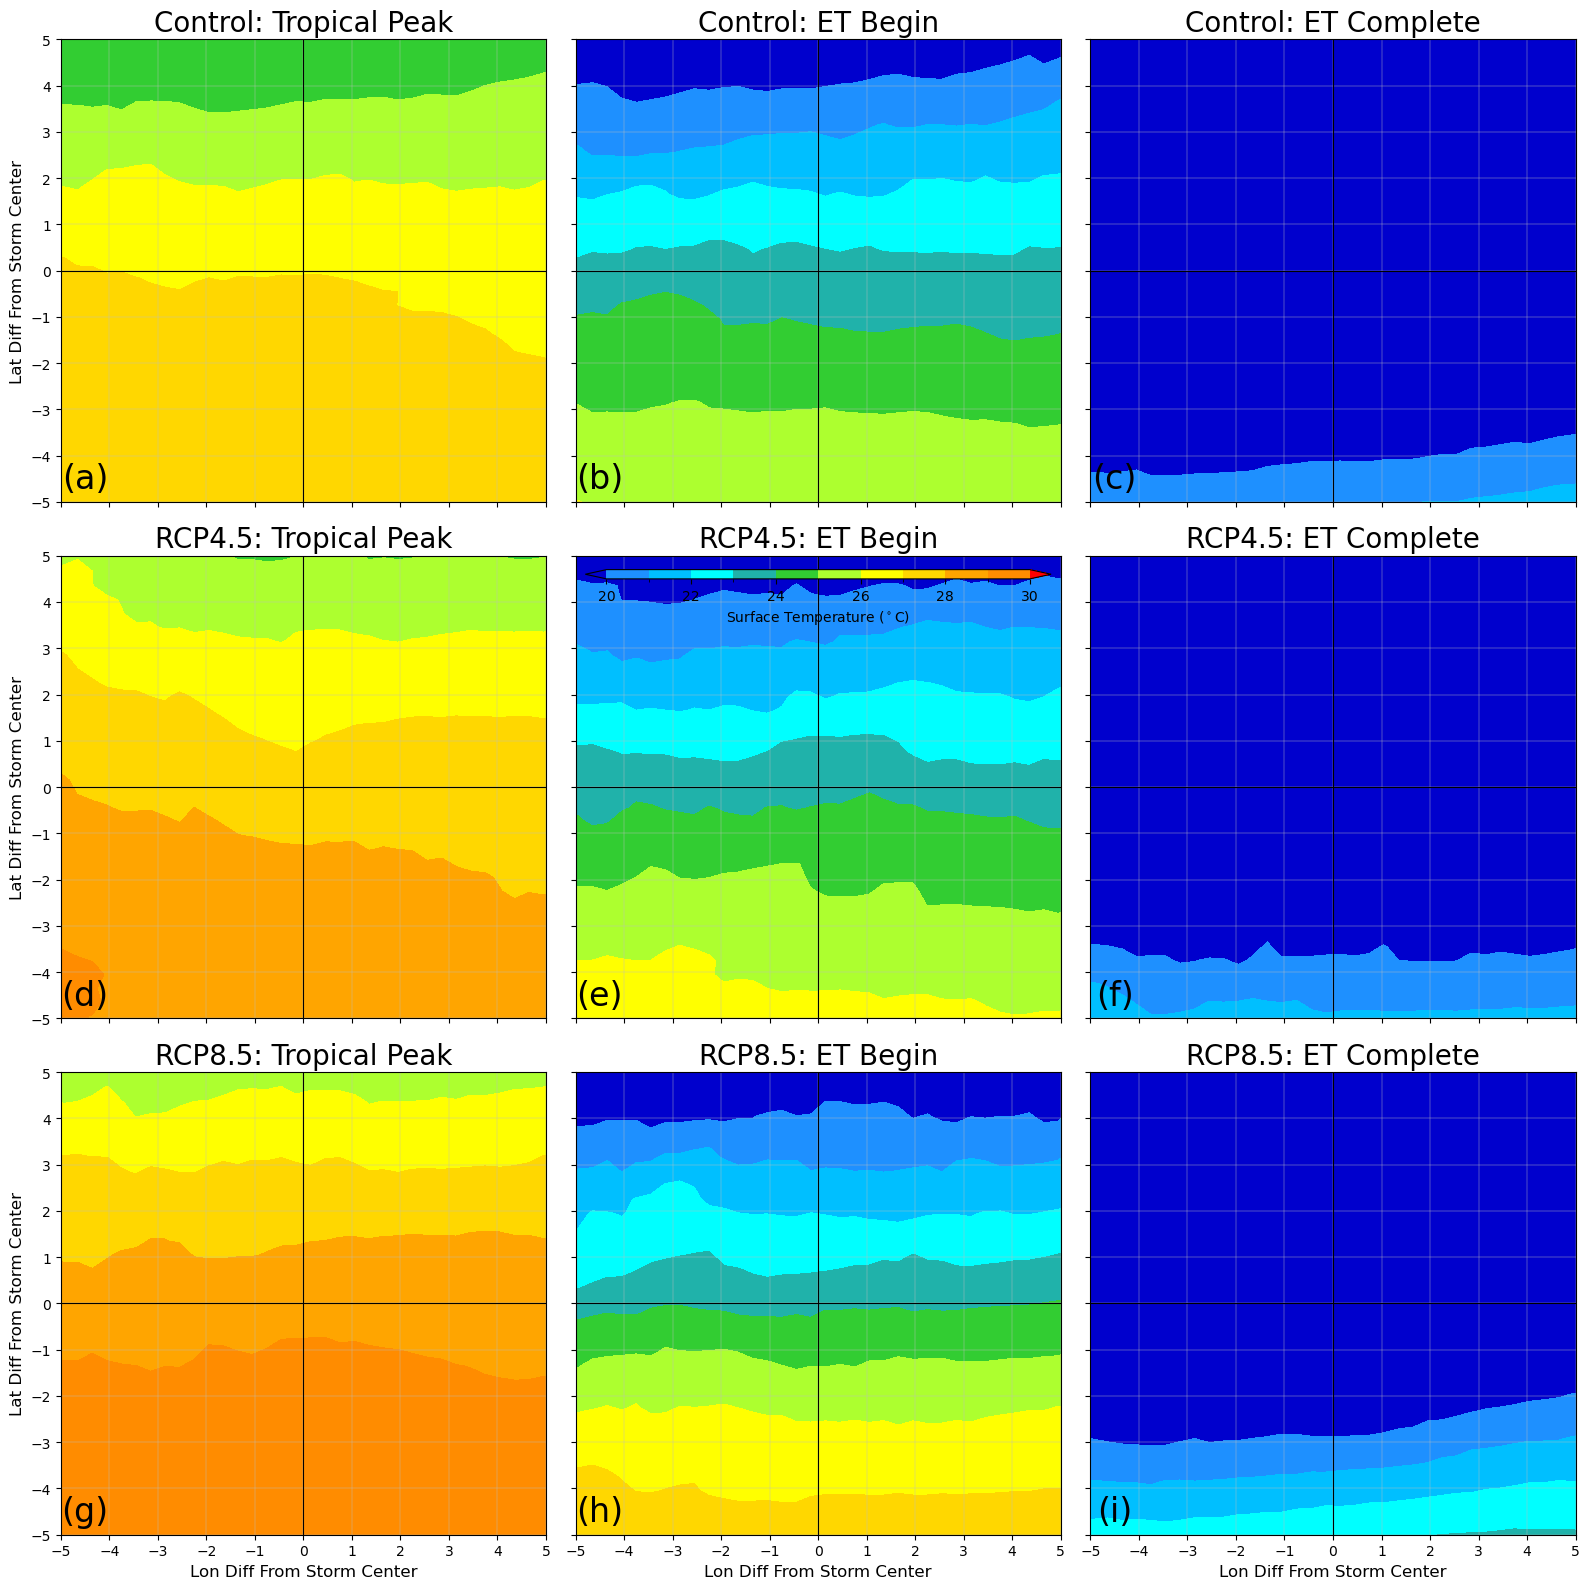

In [65]:
# Plot Mean Surface Temperature Snapshots
Var = "Surface Temperature"
Values = [Control_Temp_Sfc_Snap_Mean, RCP45_Temp_Sfc_Snap_Mean, RCP85_Temp_Sfc_Snap_Mean]
Bounds = Temp_Sfc_Bounds
Colours = Temp_Sfc_Colours
Savefig = True
Figname = 'Temp_Sfc_Snaps_Colours.png'
Snap_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Colours, Savefig, Figname)

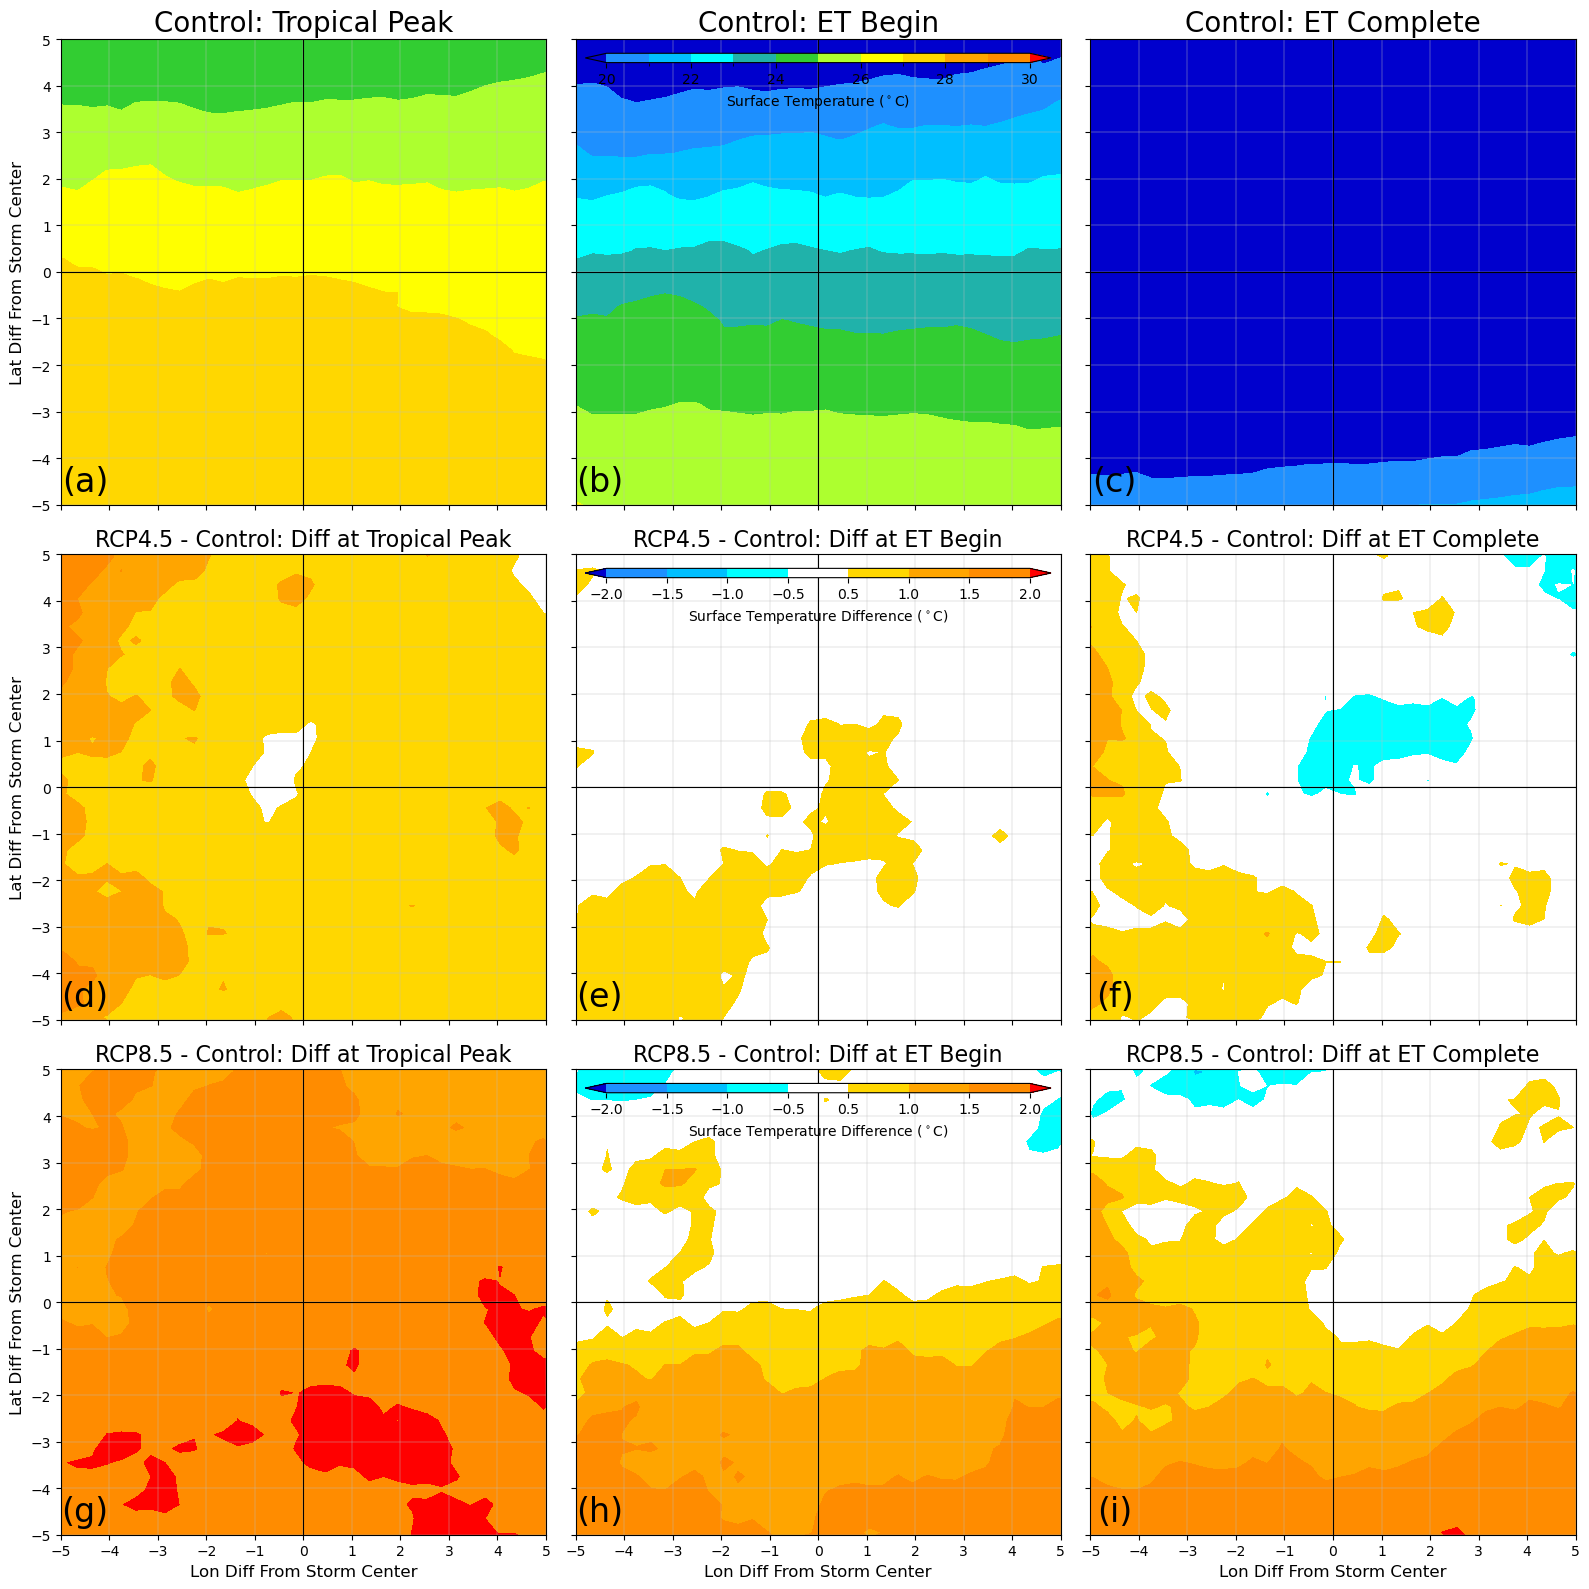

In [66]:
# Plot Mean Surface Temperature Difference Snapshots
Var = "Surface Temperature"
Values = [Control_Temp_Sfc_Snap_Mean, RCP45_Temp_Sfc_Snap_Mean, RCP85_Temp_Sfc_Snap_Mean]
Bounds = Temp_Sfc_Bounds
Colours = Temp_Sfc_Colours
Diff_Bounds = Temp_Sfc_Diff_Bounds
Diff_Colours = Temp_Sfc_Diff_Colours
Savefig = True
Figname = 'Temp_Sfc_Snaps_Diff.png'
Snap_Diff_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Colours, \
Diff_Bounds, Diff_Colours, Savefig, Figname)

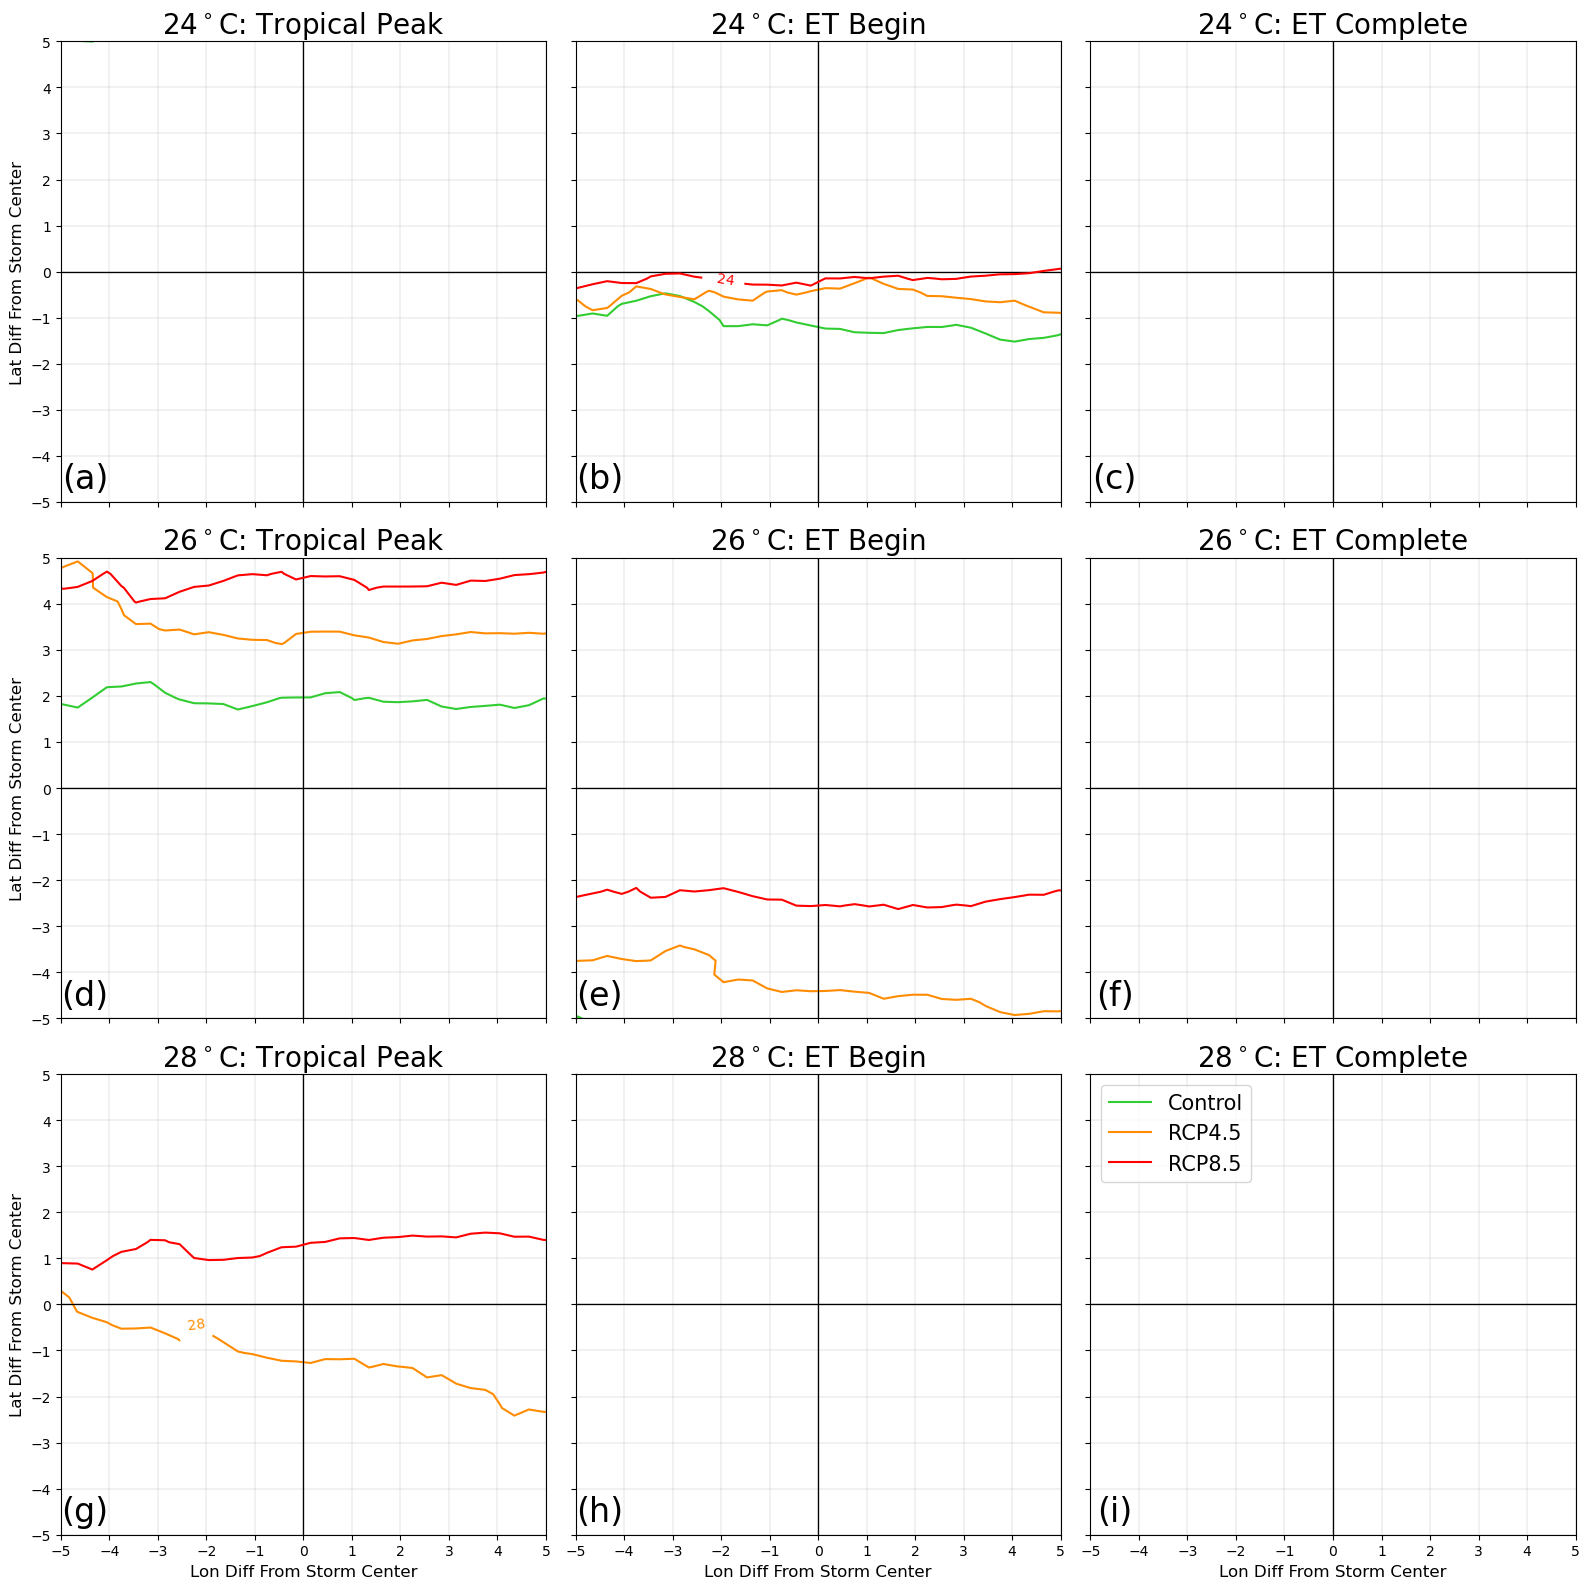

In [122]:
# Plot Mean Surface Temperature Contour Line Snapshots
Var = "Surface Temperature"
Values = [Control_Temp_Sfc_Snap_Mean, RCP45_Temp_Sfc_Snap_Mean, RCP85_Temp_Sfc_Snap_Mean]
Bounds = Temp_Sfc_Line_Bounds
Savefig = True
Figname = 'Temp_Sfc_Snaps_Lines.png'
Snap_Line_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Savefig, Figname)

In [68]:
# Calculate Mean 850hPa Temperature Snapshots
Var = "850hPa Temperature"
Percentile = False
Control_Temp_850hPa_Snap_Mean = Snaps_Combine(Var, Control_Subset_Codes, Control_Data, Control_ET, \
Control_Compo, Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc, Percentile)
RCP45_Temp_850hPa_Snap_Mean = Snaps_Combine(Var, RCP45_Subset_Codes, RCP45_Data, RCP45_ET, \
RCP45_Compo, RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc, Percentile)
RCP85_Temp_850hPa_Snap_Mean = Snaps_Combine(Var, RCP85_Subset_Codes, RCP85_Data, RCP85_ET, \
RCP85_Compo, RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc, Percentile)

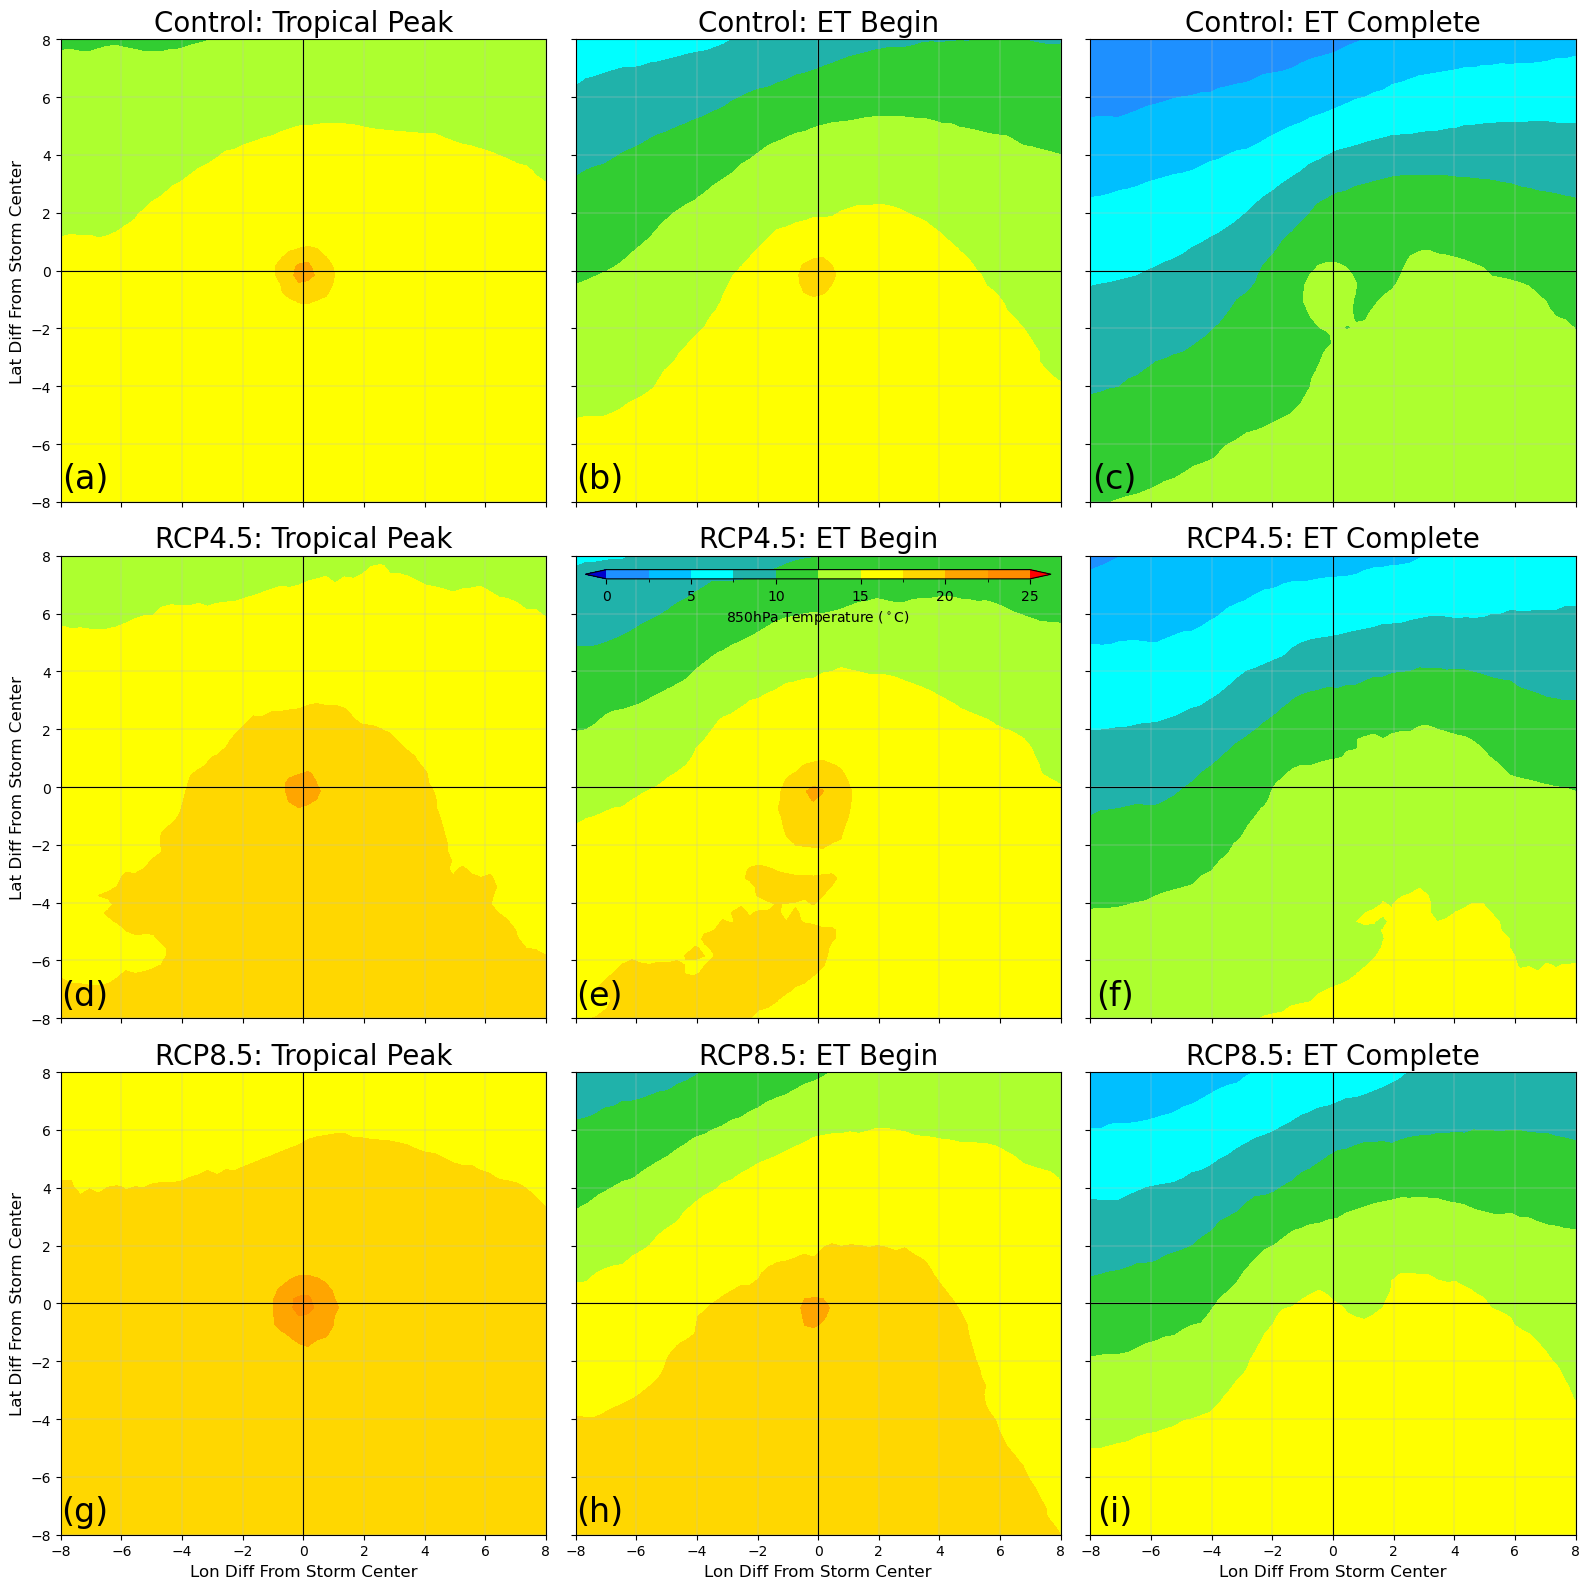

In [69]:
# Plot Mean 850hPa Temperature Snapshots
Var = "850hPa Temperature"
Values = [Control_Temp_850hPa_Snap_Mean, RCP45_Temp_850hPa_Snap_Mean, RCP85_Temp_850hPa_Snap_Mean]
Bounds = Temp_850hPa_Bounds
Colours = Temp_850hPa_Colours
Savefig = True
Figname = 'Temp_850hPa_Snaps_Colours.png'
Snap_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Colours, Savefig, Figname)

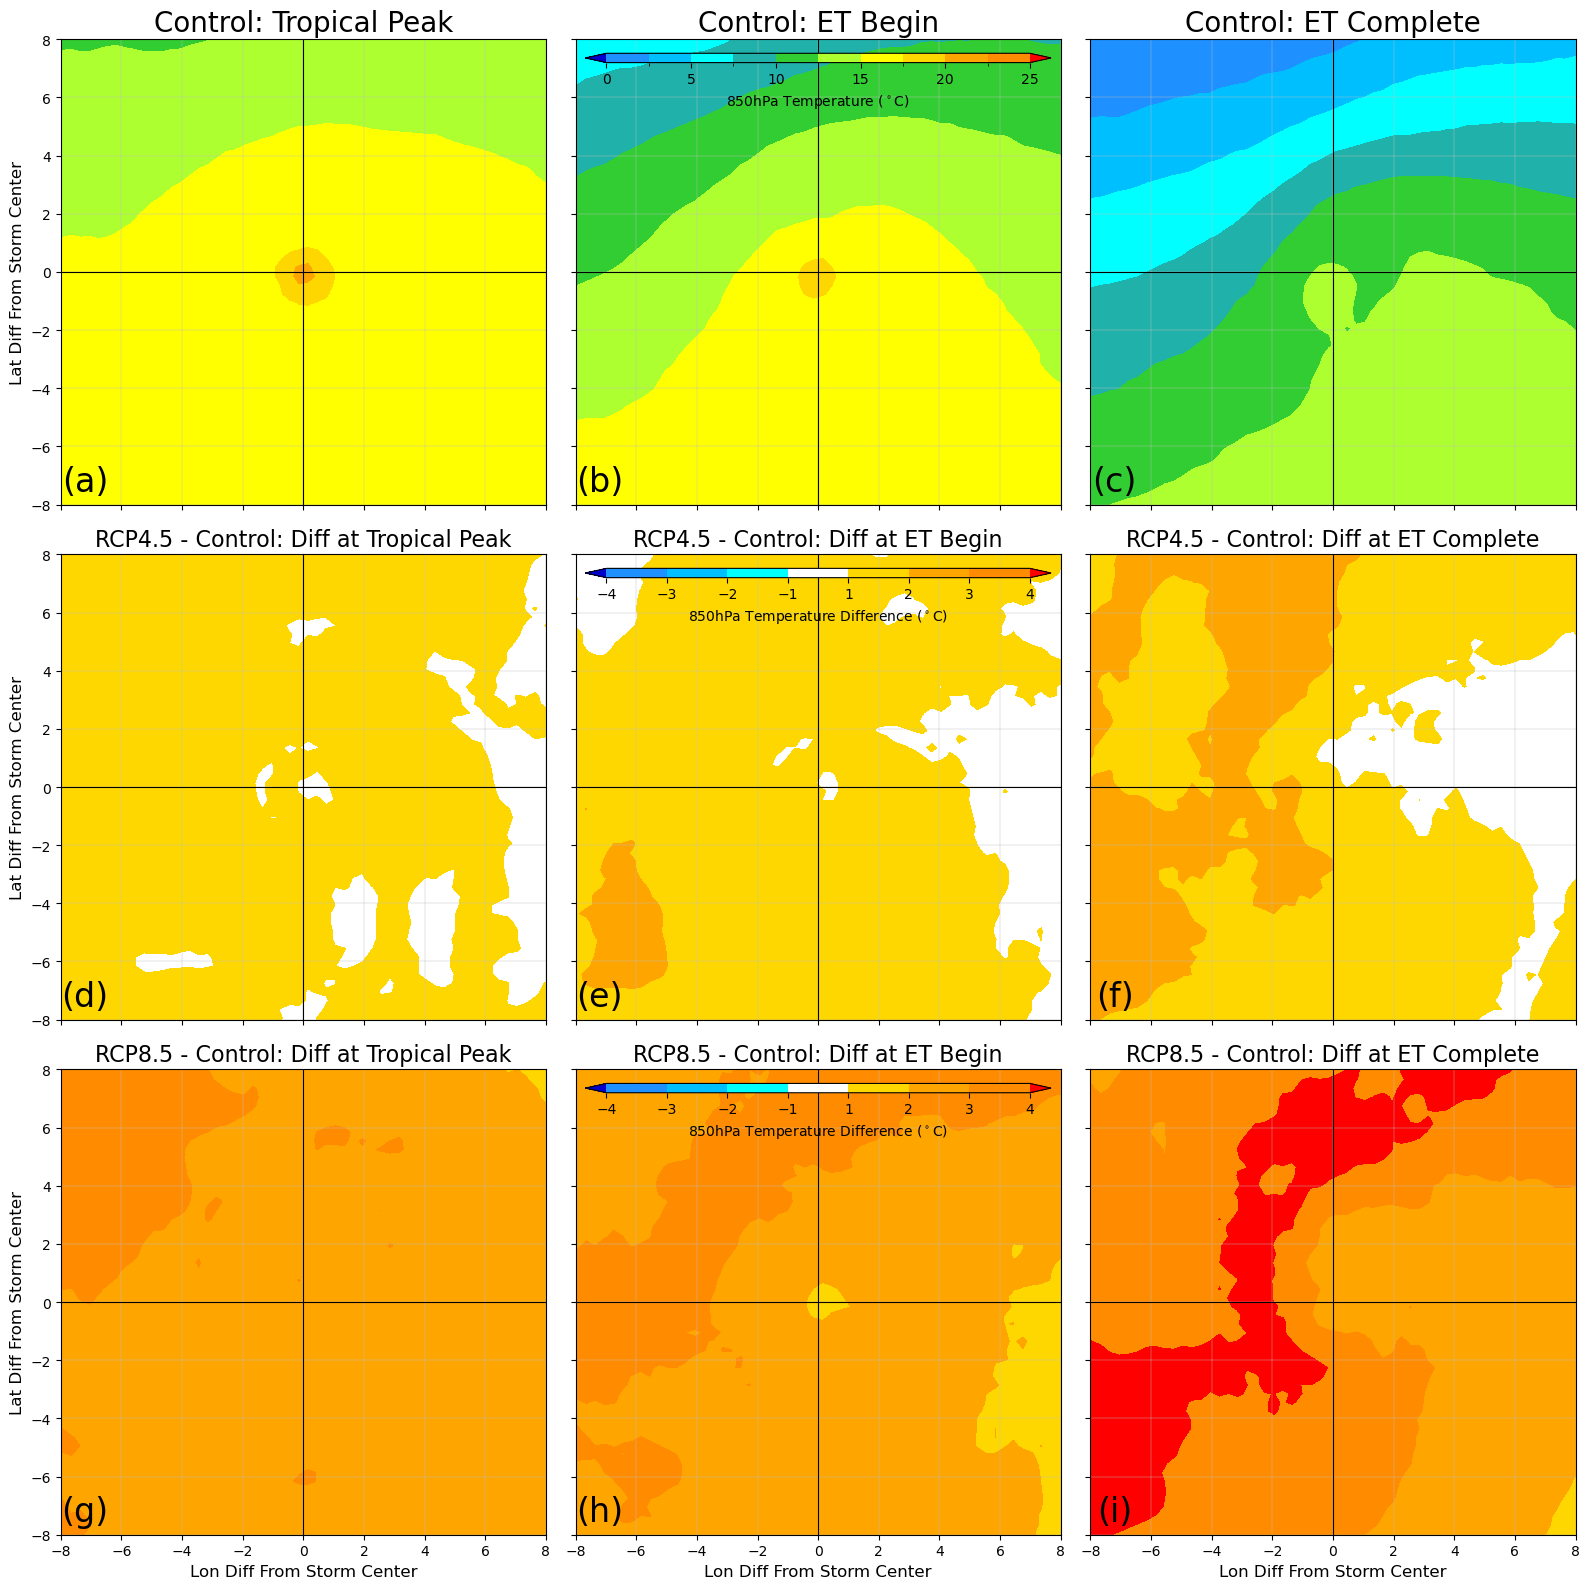

In [70]:
# Plot Mean 850hPa Temperature Difference Snapshots
Var = "850hPa Temperature"
Values = [Control_Temp_850hPa_Snap_Mean, RCP45_Temp_850hPa_Snap_Mean, RCP85_Temp_850hPa_Snap_Mean]
Bounds = Temp_850hPa_Bounds
Colours = Temp_850hPa_Colours
Diff_Bounds = Temp_850hPa_Diff_Bounds
Diff_Colours = Temp_850hPa_Diff_Colours
Savefig = True
Figname = 'Temp_850hPa_Snaps_Diff.png'
Snap_Diff_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Colours, \
Diff_Bounds, Diff_Colours, Savefig, Figname)

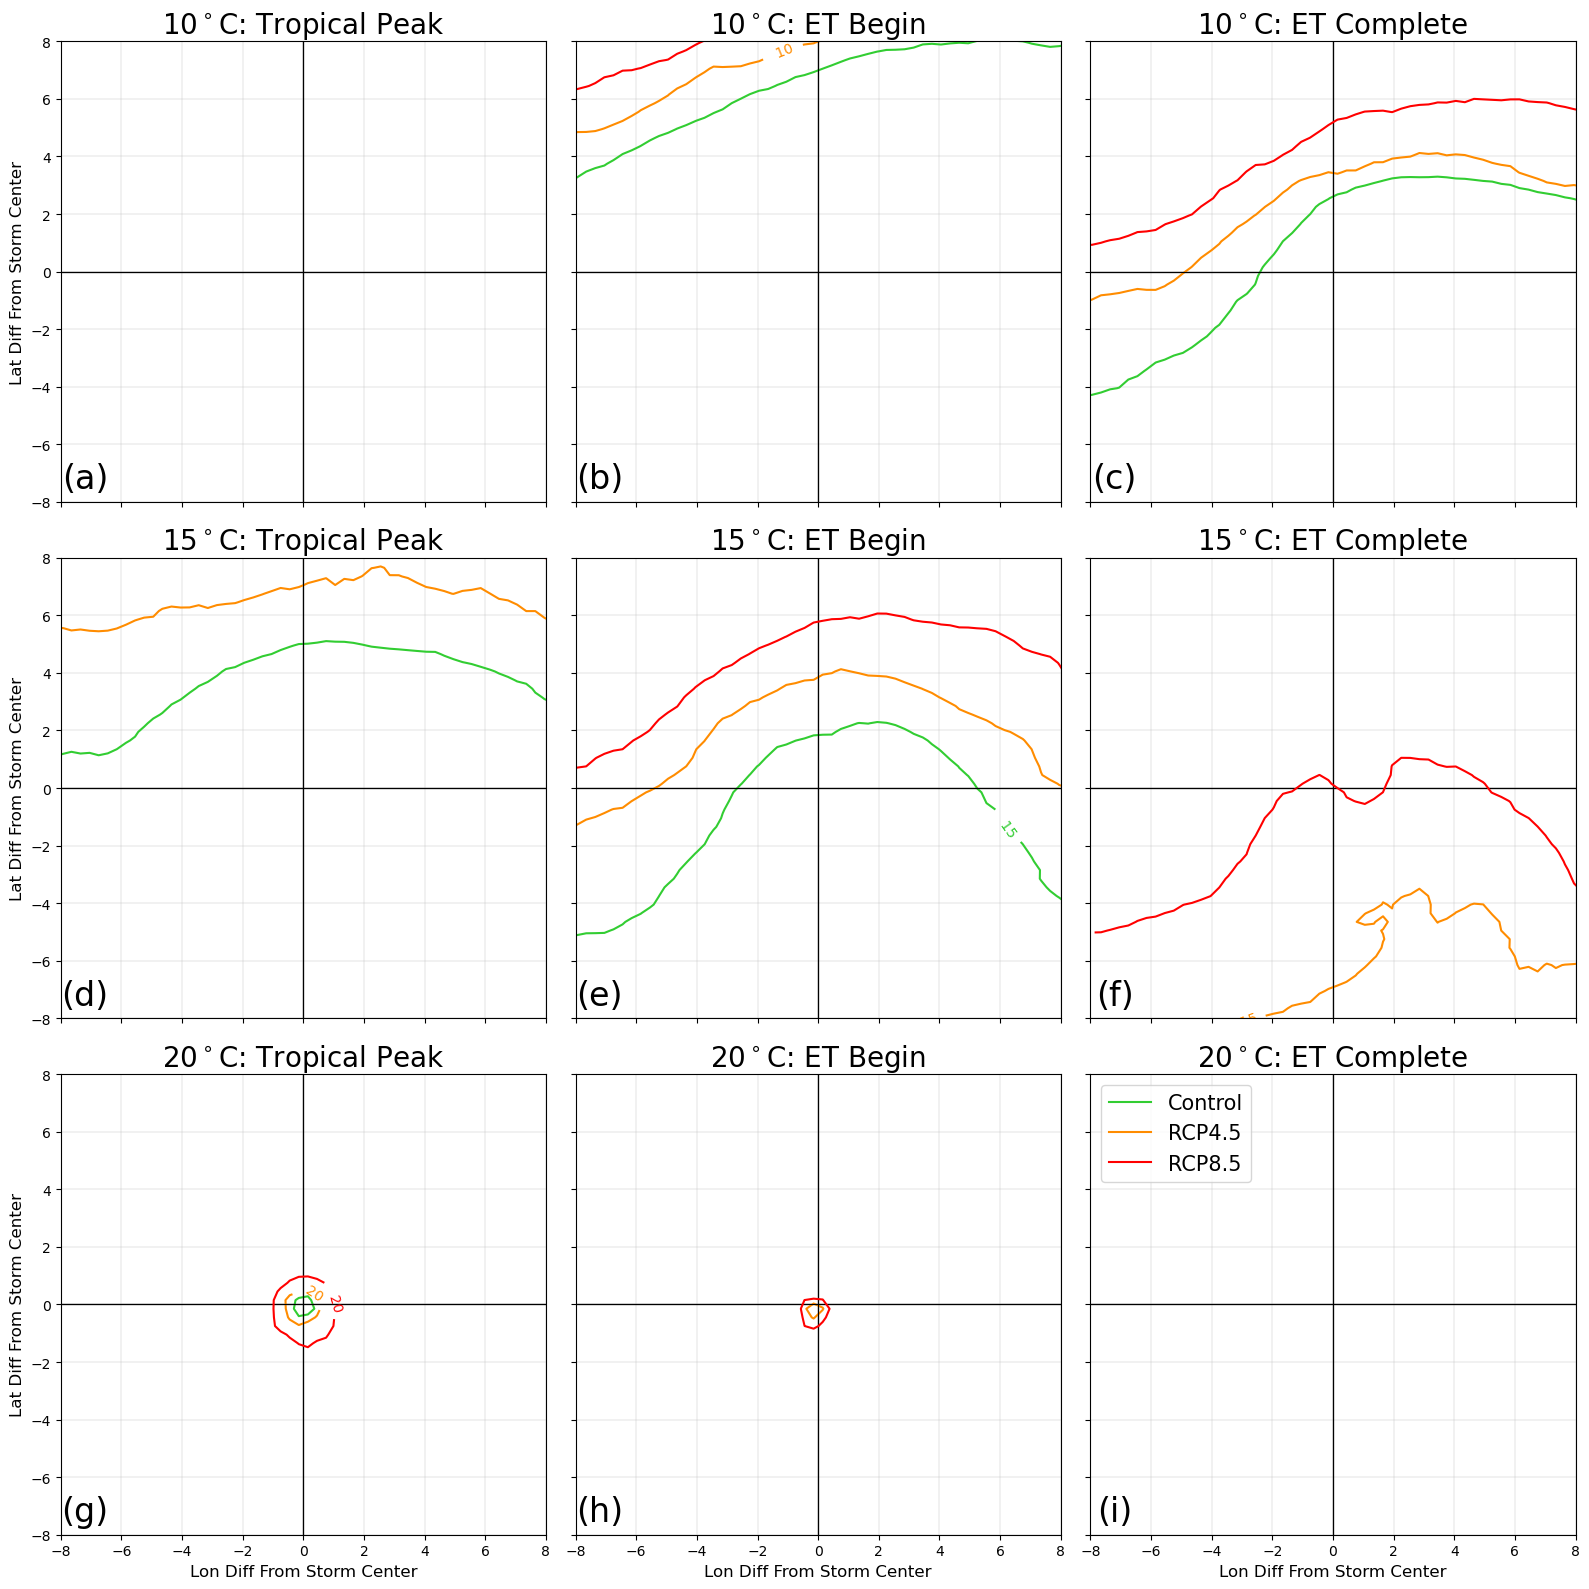

In [123]:
# Plot Mean 850hPa Temperature Contour Line Snapshots
Var = "850hPa Temperature"
Values = [Control_Temp_850hPa_Snap_Mean, RCP45_Temp_850hPa_Snap_Mean, RCP85_Temp_850hPa_Snap_Mean]
Bounds = Temp_850hPa_Line_Bounds
Savefig = True
Figname = 'Temp_850hPa_Snaps_Lines.png'
Snap_Line_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Savefig, Figname)

In [72]:
# Calculate Mean 500hPa Temperature Snapshots
Var = "500hPa Temperature"
Percentile = False
Control_Temp_500hPa_Snap_Mean = Snaps_Combine(Var, Control_Subset_Codes, Control_Data, Control_ET, \
Control_Compo, Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc, Percentile)
RCP45_Temp_500hPa_Snap_Mean = Snaps_Combine(Var, RCP45_Subset_Codes, RCP45_Data, RCP45_ET, \
RCP45_Compo, RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc, Percentile)
RCP85_Temp_500hPa_Snap_Mean = Snaps_Combine(Var, RCP85_Subset_Codes, RCP85_Data, RCP85_ET, \
RCP85_Compo, RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc, Percentile)

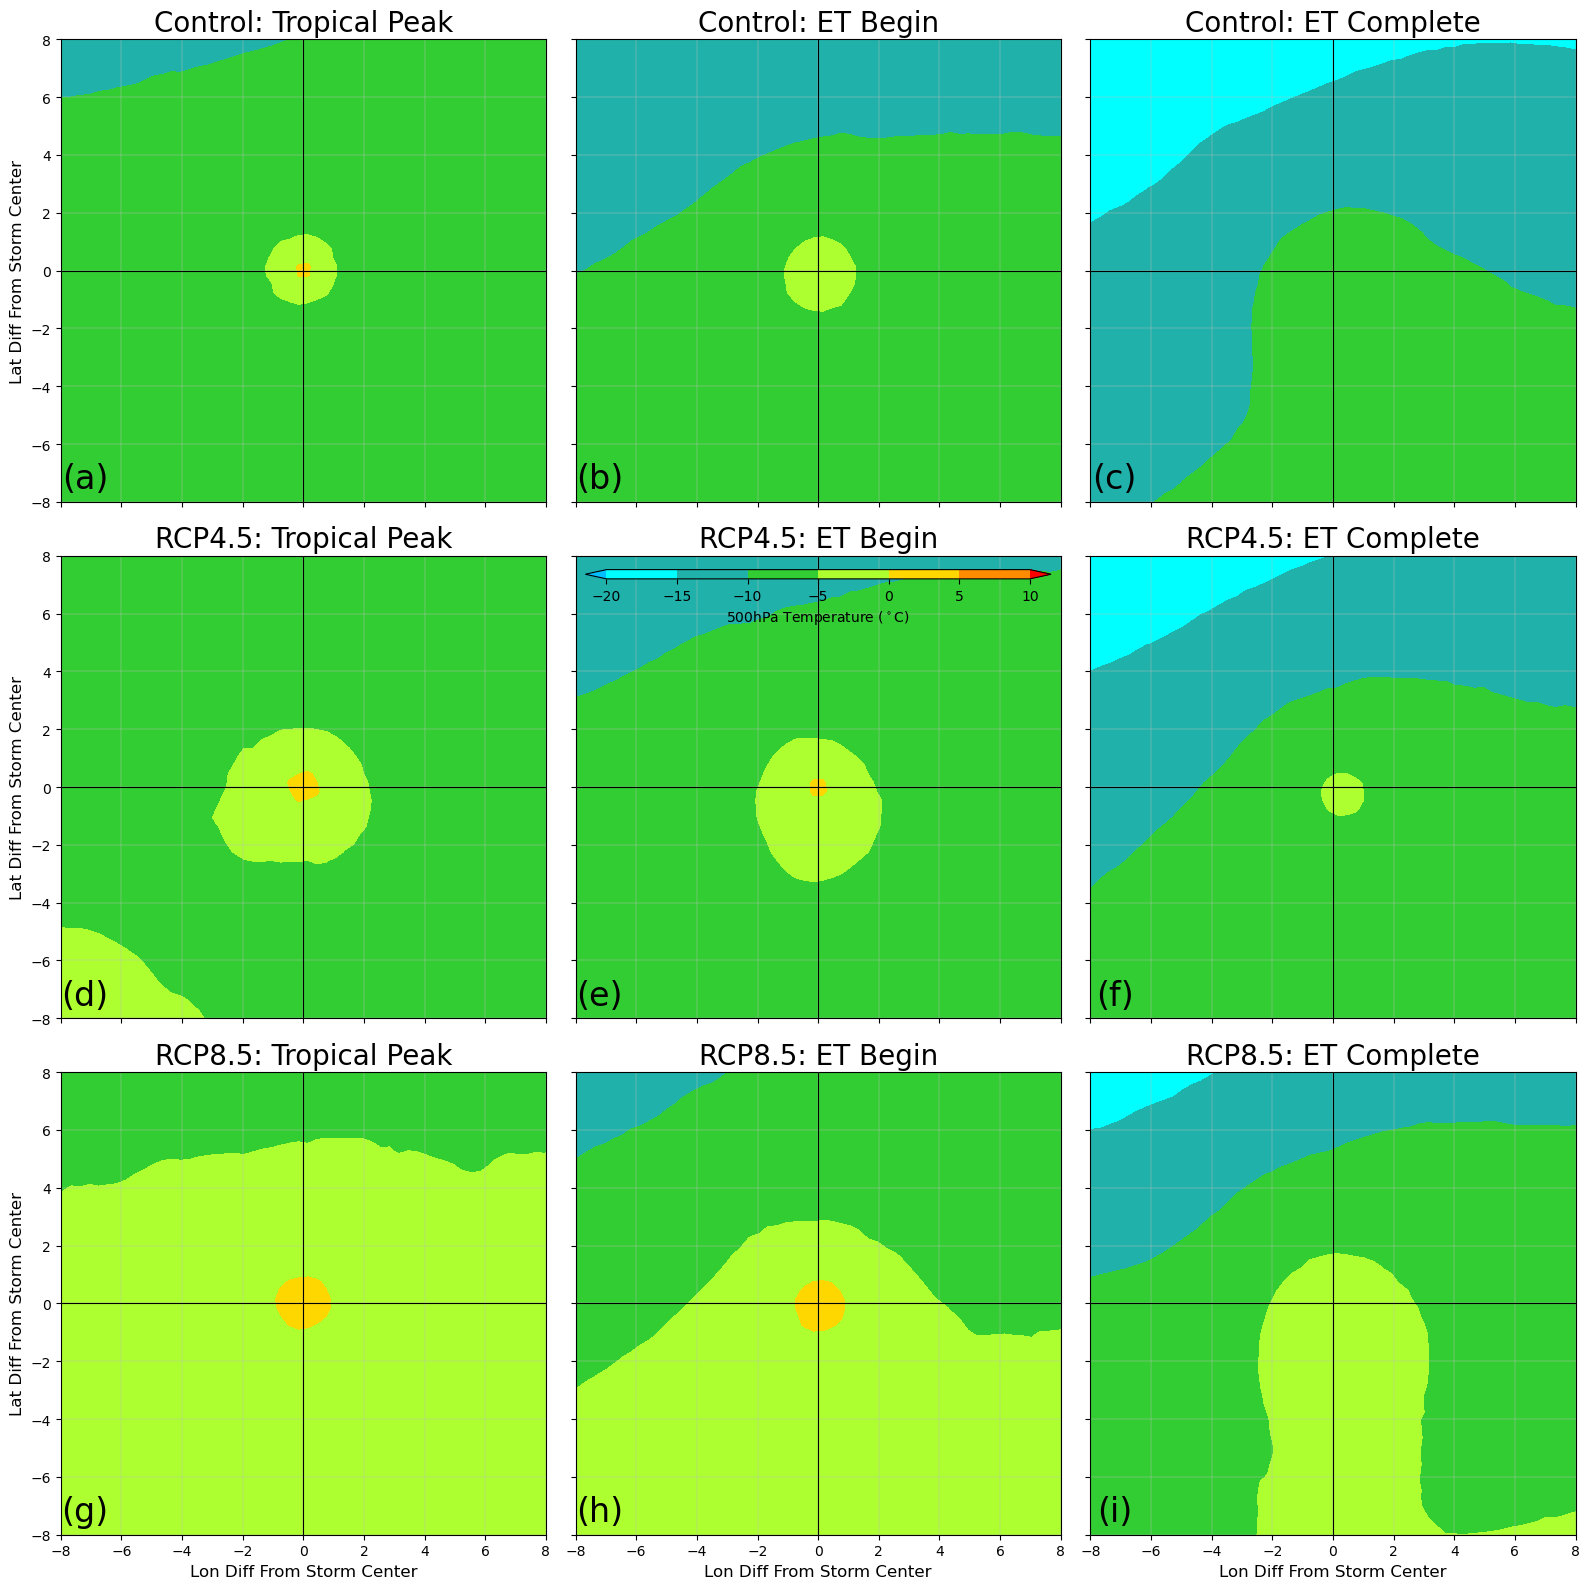

In [73]:
# Plot Mean 500hPa Temperature Snapshots
Var = "500hPa Temperature"
Values = [Control_Temp_500hPa_Snap_Mean, RCP45_Temp_500hPa_Snap_Mean, RCP85_Temp_500hPa_Snap_Mean]
Bounds = Temp_500hPa_Bounds
Colours = Temp_500hPa_Colours
Savefig = True
Figname = 'Temp_500hPa_Snaps_Colours.png'
Snap_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Colours, Savefig, Figname)

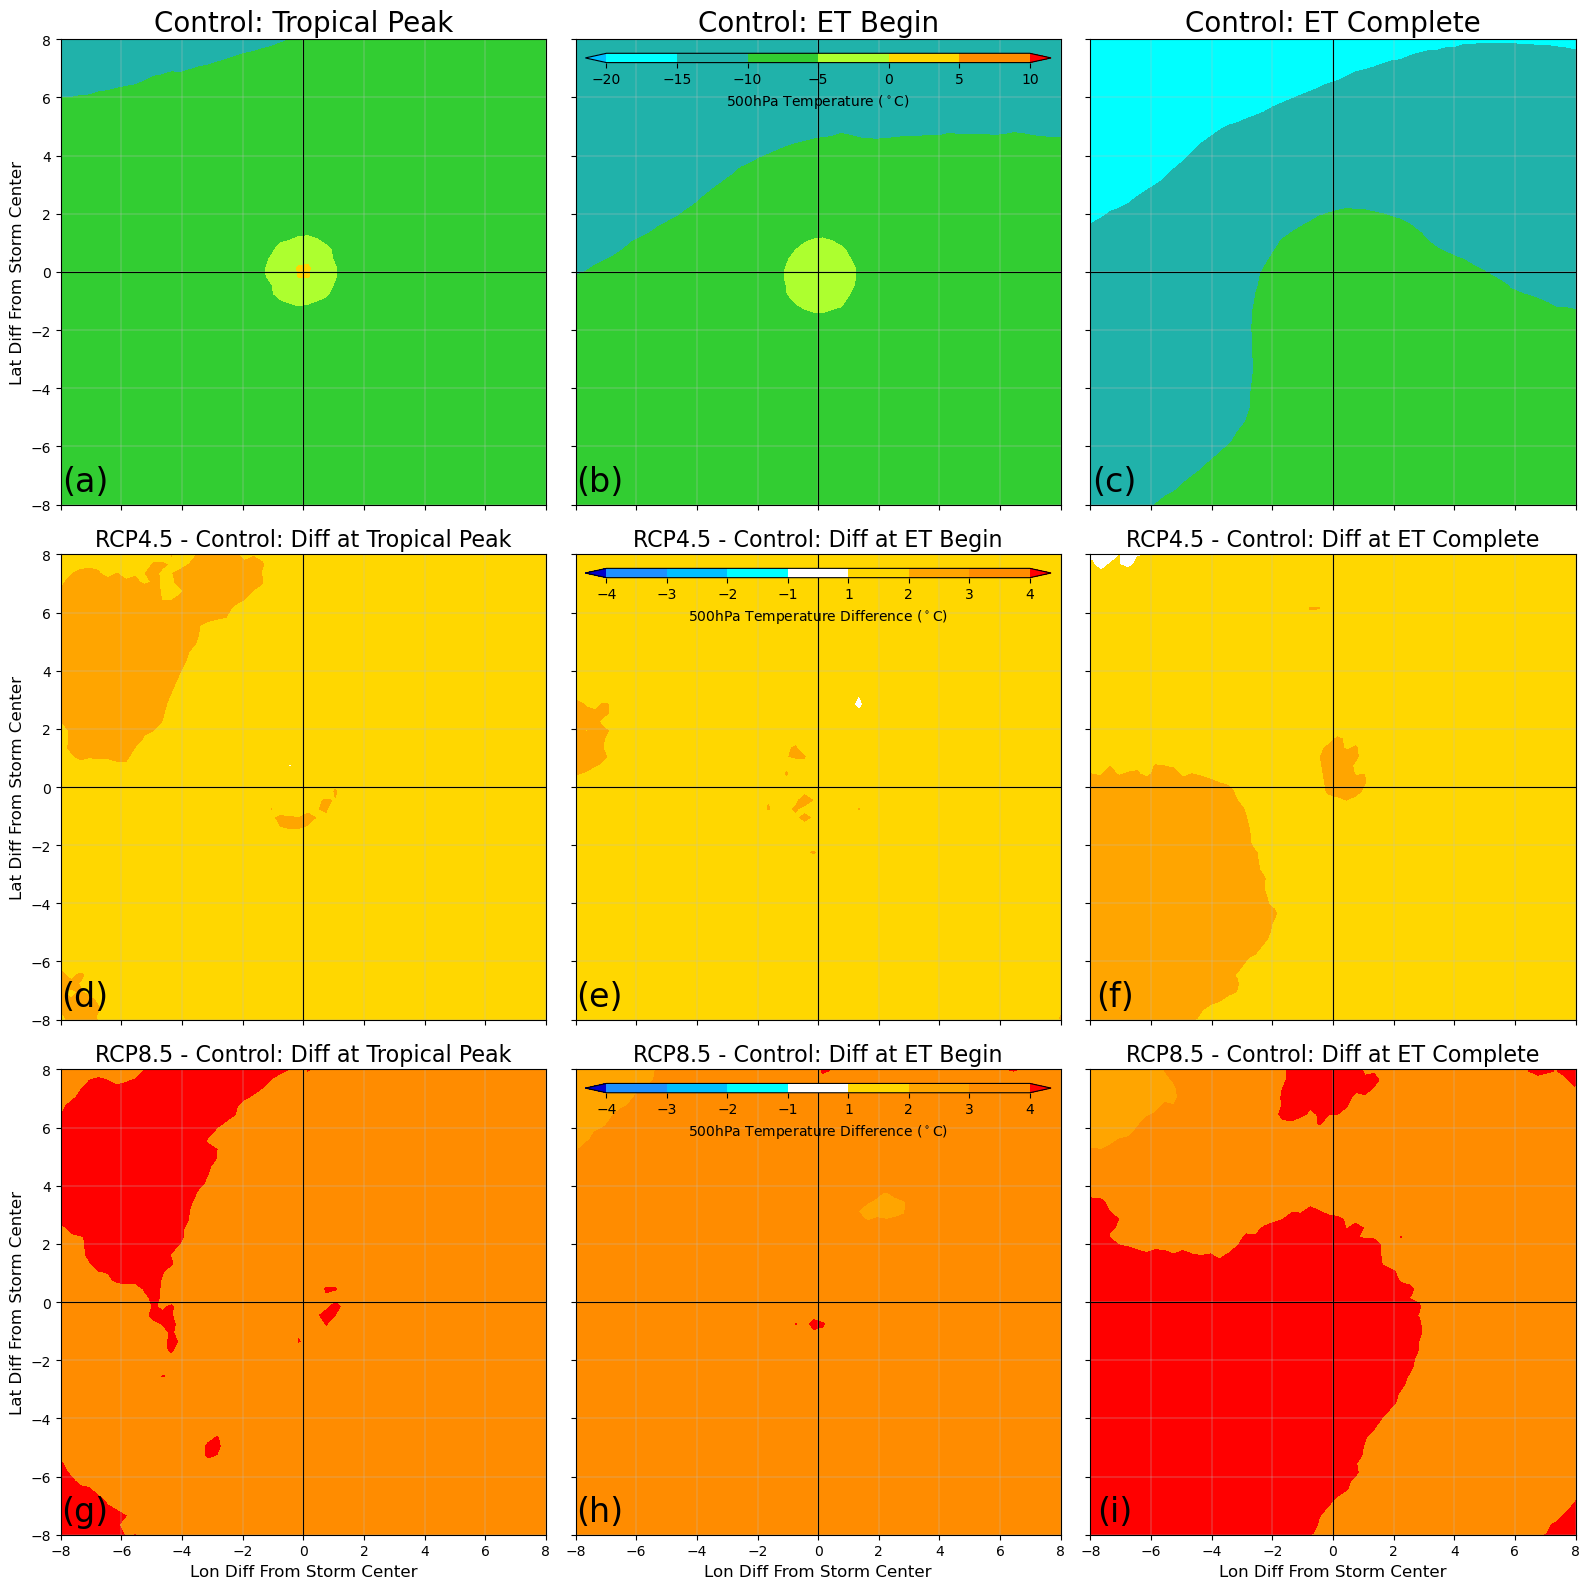

In [74]:
# Plot Mean 500hPa Temperature Difference Snapshots
Var = "500hPa Temperature"
Values = [Control_Temp_500hPa_Snap_Mean, RCP45_Temp_500hPa_Snap_Mean, RCP85_Temp_500hPa_Snap_Mean]
Bounds = Temp_500hPa_Bounds
Colours = Temp_500hPa_Colours
Diff_Bounds = Temp_500hPa_Diff_Bounds
Diff_Colours = Temp_500hPa_Diff_Colours
Savefig = True
Figname = 'Temp_500hPa_Snaps_Diff.png'
Snap_Diff_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Colours, \
Diff_Bounds, Diff_Colours, Savefig, Figname)

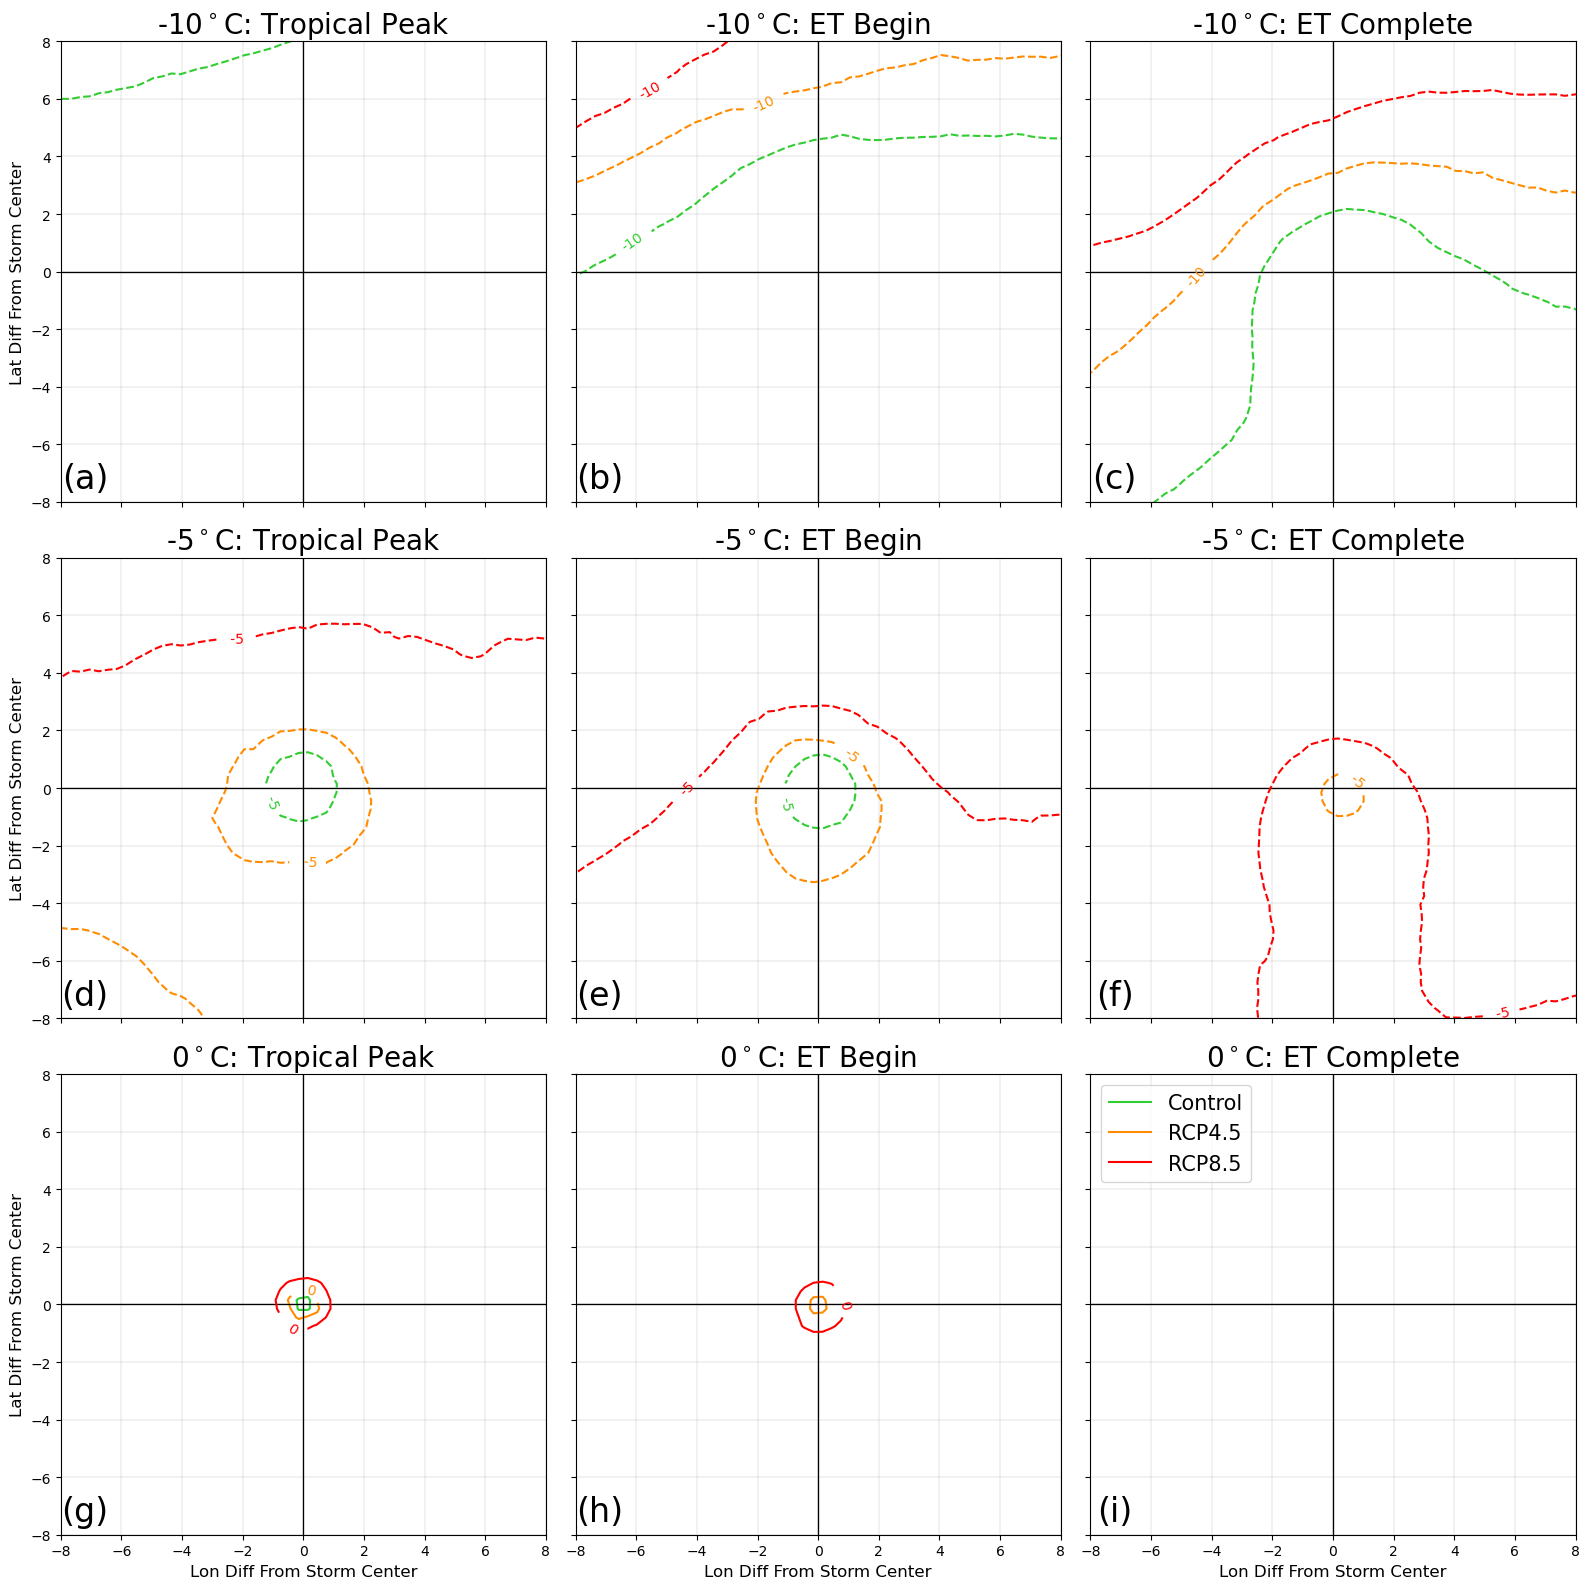

In [124]:
# Plot Mean 500hPa Temperature Contour Line Snapshots
Var = "500hPa Temperature"
Values = [Control_Temp_500hPa_Snap_Mean, RCP45_Temp_500hPa_Snap_Mean, RCP85_Temp_500hPa_Snap_Mean]
Bounds = Temp_500hPa_Line_Bounds
Savefig = True
Figname = 'Temp_500hPa_Snaps_Lines.png'
Snap_Line_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Savefig, Figname)

In [76]:
# Calculate Mean 200hPa Temperature Snapshots
Var = "200hPa Temperature"
Percentile = False
Control_Temp_200hPa_Snap_Mean = Snaps_Combine(Var, Control_Subset_Codes, Control_Data, Control_ET, \
Control_Compo, Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc, Percentile)
RCP45_Temp_200hPa_Snap_Mean = Snaps_Combine(Var, RCP45_Subset_Codes, RCP45_Data, RCP45_ET, \
RCP45_Compo, RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc, Percentile)
RCP85_Temp_200hPa_Snap_Mean = Snaps_Combine(Var, RCP85_Subset_Codes, RCP85_Data, RCP85_ET, \
RCP85_Compo, RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc, Percentile)

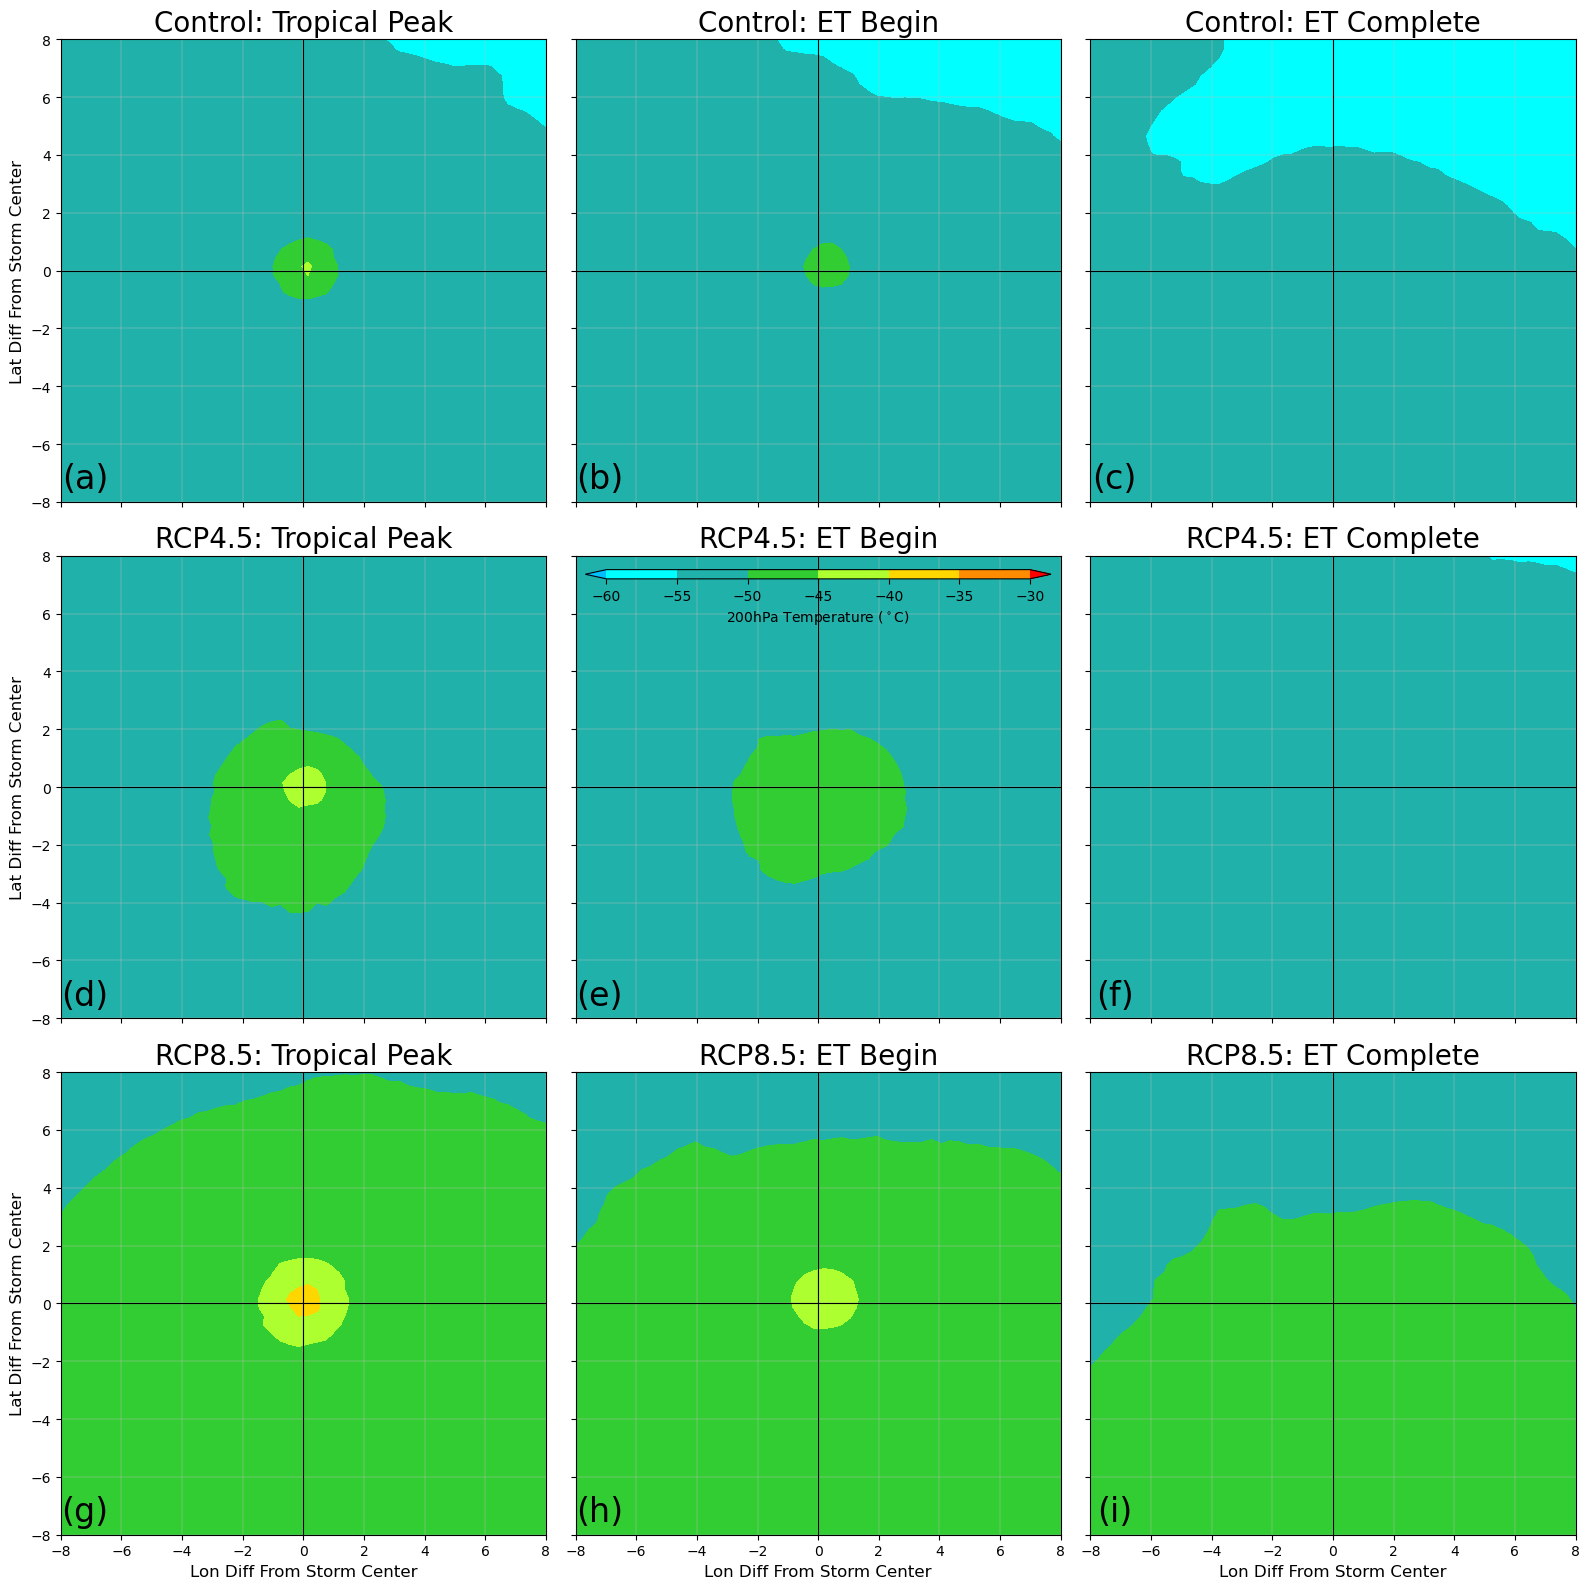

In [77]:
# Plot Mean 200hPa Temperature Snapshots
Var = "200hPa Temperature"
Values = [Control_Temp_200hPa_Snap_Mean, RCP45_Temp_200hPa_Snap_Mean, RCP85_Temp_200hPa_Snap_Mean]
Bounds = Temp_200hPa_Bounds
Colours = Temp_200hPa_Colours
Savefig = True
Figname = 'Temp_200hPa_Snaps_Colours.png'
Snap_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Colours, Savefig, Figname)

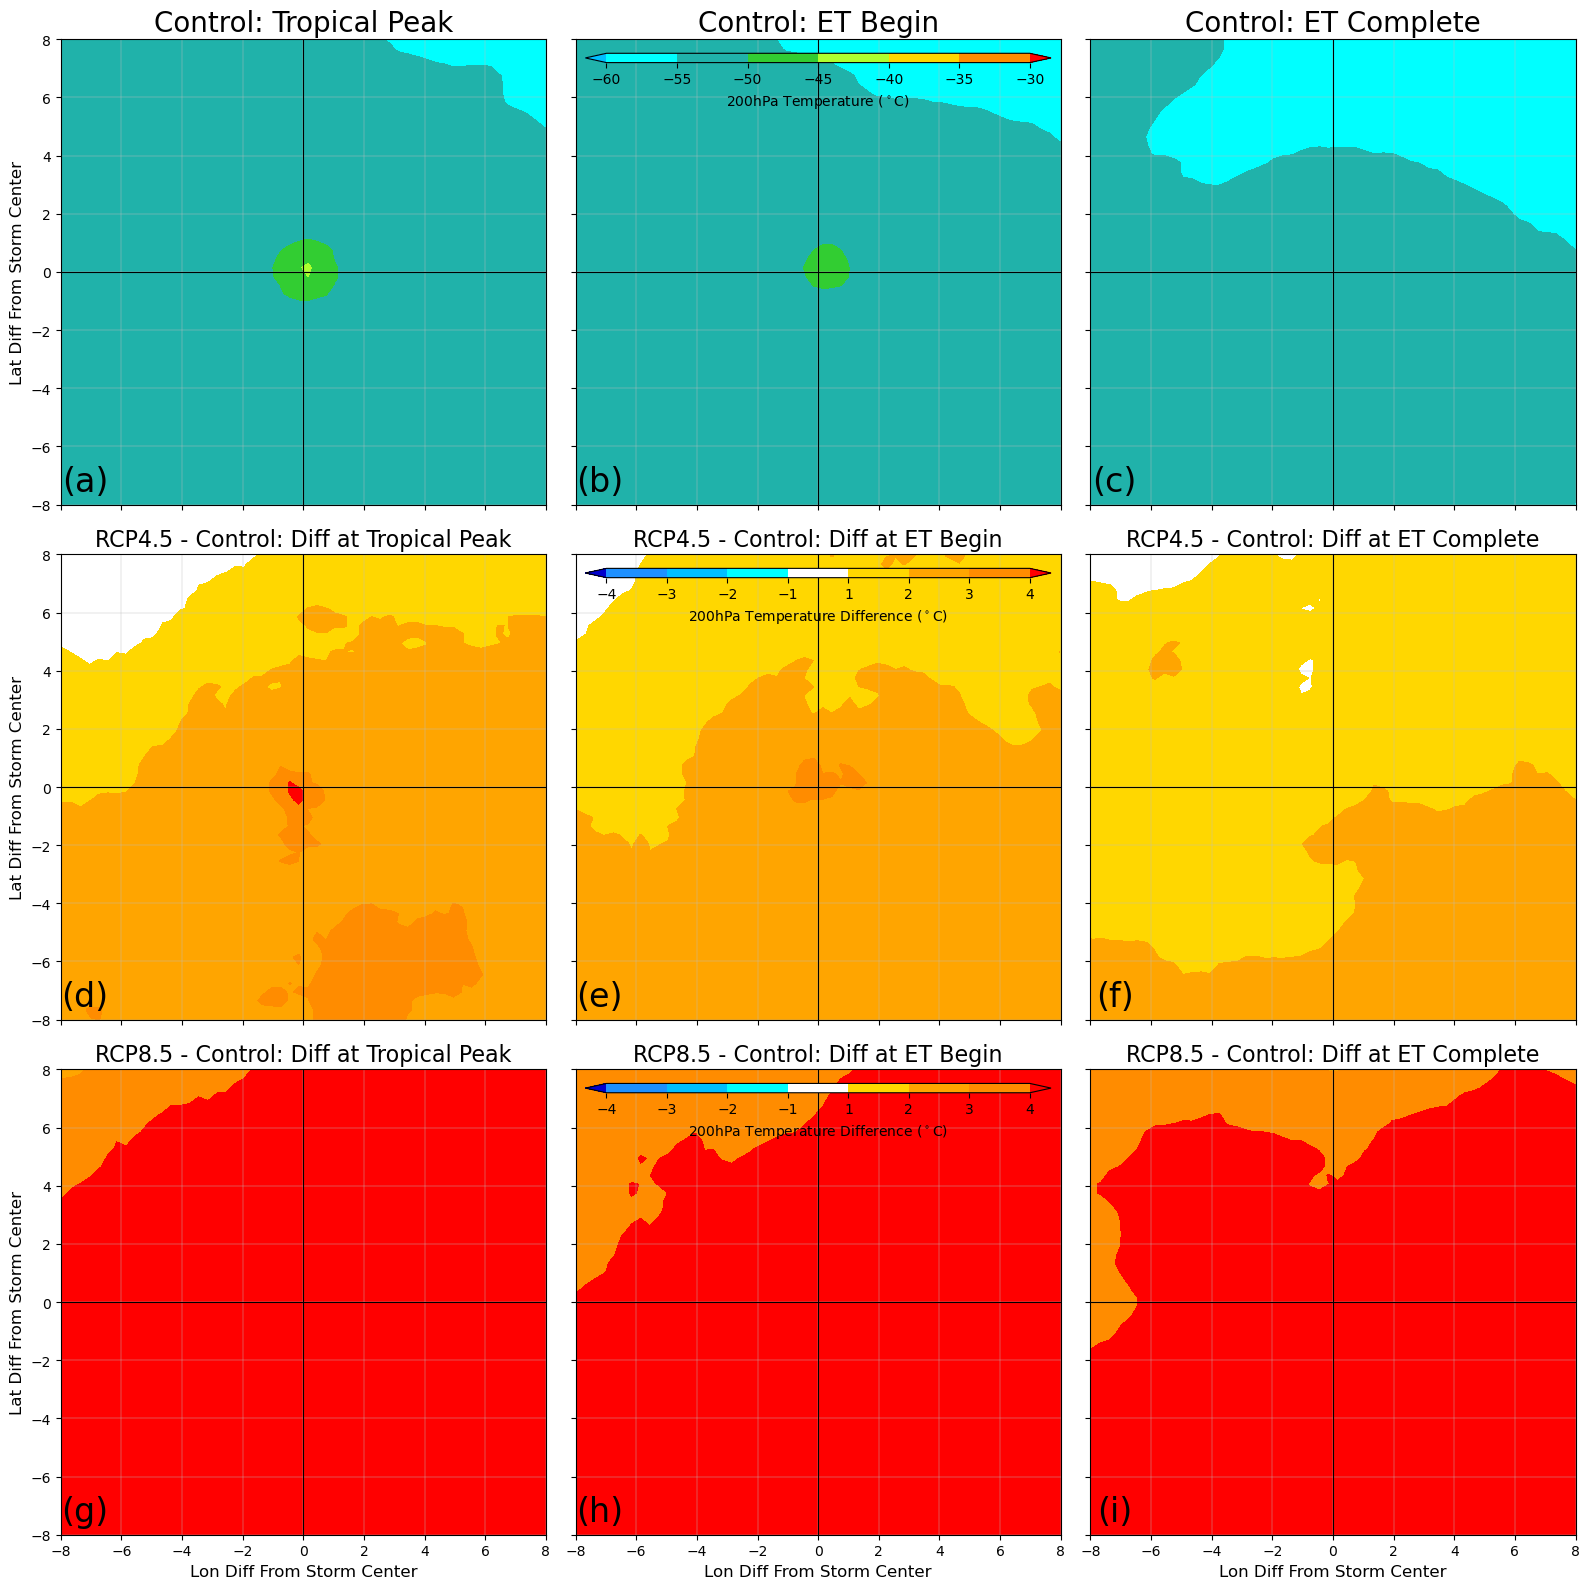

In [78]:
# Plot Mean Precip Water Difference Snapshots
Var = "200hPa Temperature"
Values = [Control_Temp_200hPa_Snap_Mean, RCP45_Temp_200hPa_Snap_Mean, RCP85_Temp_200hPa_Snap_Mean]
Bounds = Temp_200hPa_Bounds
Colours = Temp_200hPa_Colours
Diff_Bounds = Temp_200hPa_Diff_Bounds
Diff_Colours = Temp_200hPa_Diff_Colours
Savefig = True
Figname = 'Temp_200hPa_Snaps_Diff.png'
Snap_Diff_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Colours, \
Diff_Bounds, Diff_Colours, Savefig, Figname)

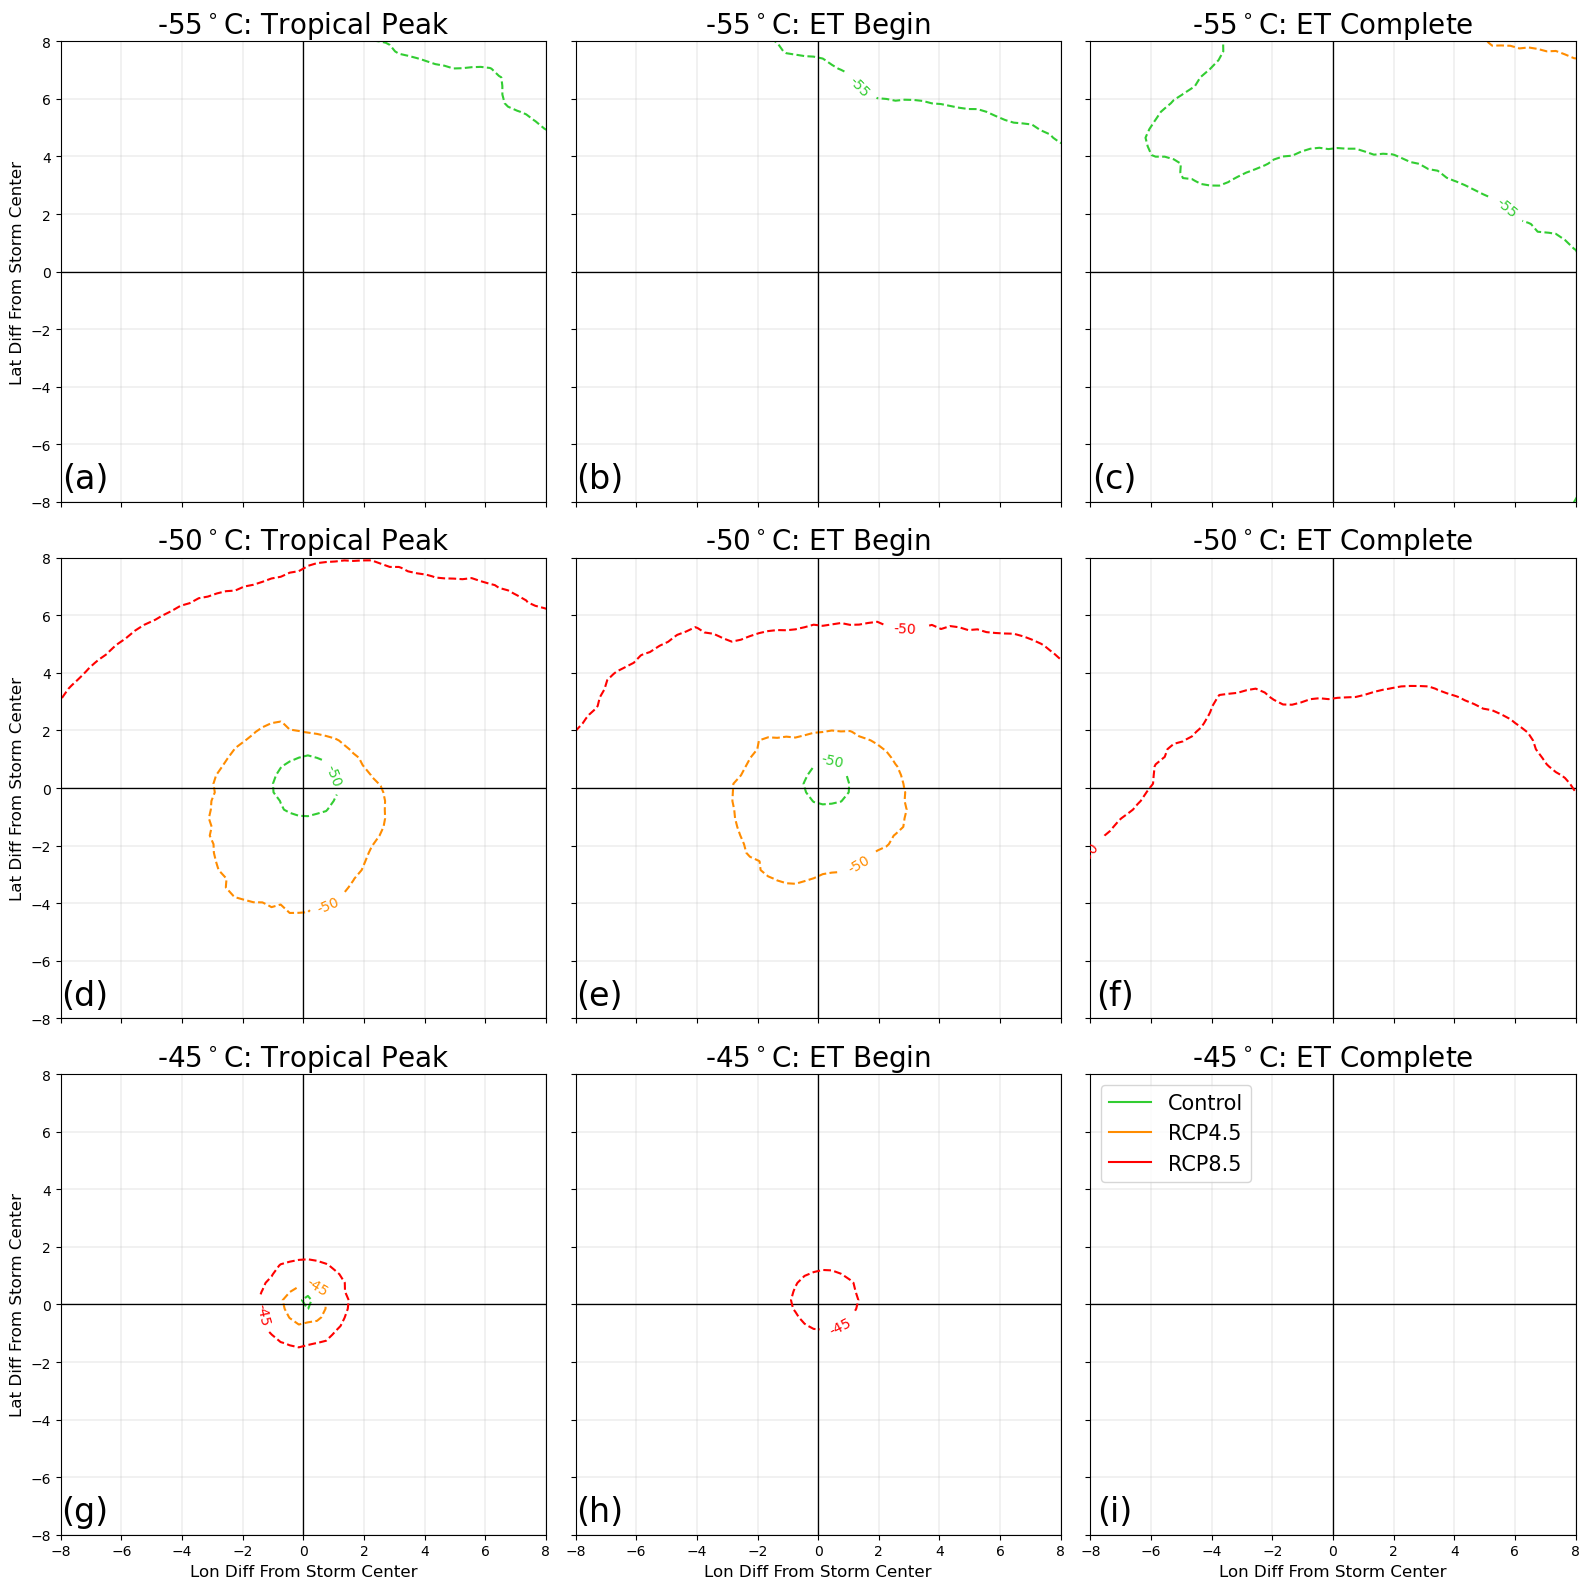

In [125]:
# Plot Mean 200hPa Temperature Contour Line Snapshots
Var = "200hPa Temperature"
Values = [Control_Temp_200hPa_Snap_Mean, RCP45_Temp_200hPa_Snap_Mean, RCP85_Temp_200hPa_Snap_Mean]
Bounds = Temp_200hPa_Line_Bounds
Savefig = True
Figname = 'Temp_200hPa_Snaps_Lines.png'
Snap_Line_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Savefig, Figname)

In [80]:
# Calculate Mean 200hPa Zonal Wind Snapshots
Var = "200hPa Zonal Wind"
Percentile = False
Control_U_200hPa_Snap_Mean = Snaps_Combine(Var, Control_Subset_Codes, Control_Data, Control_ET, \
Control_Compo, Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc, Percentile)
RCP45_U_200hPa_Snap_Mean = Snaps_Combine(Var, RCP45_Subset_Codes, RCP45_Data, RCP45_ET, \
RCP45_Compo, RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc, Percentile)
RCP85_U_200hPa_Snap_Mean = Snaps_Combine(Var, RCP85_Subset_Codes, RCP85_Data, RCP85_ET, \
RCP85_Compo, RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc, Percentile)

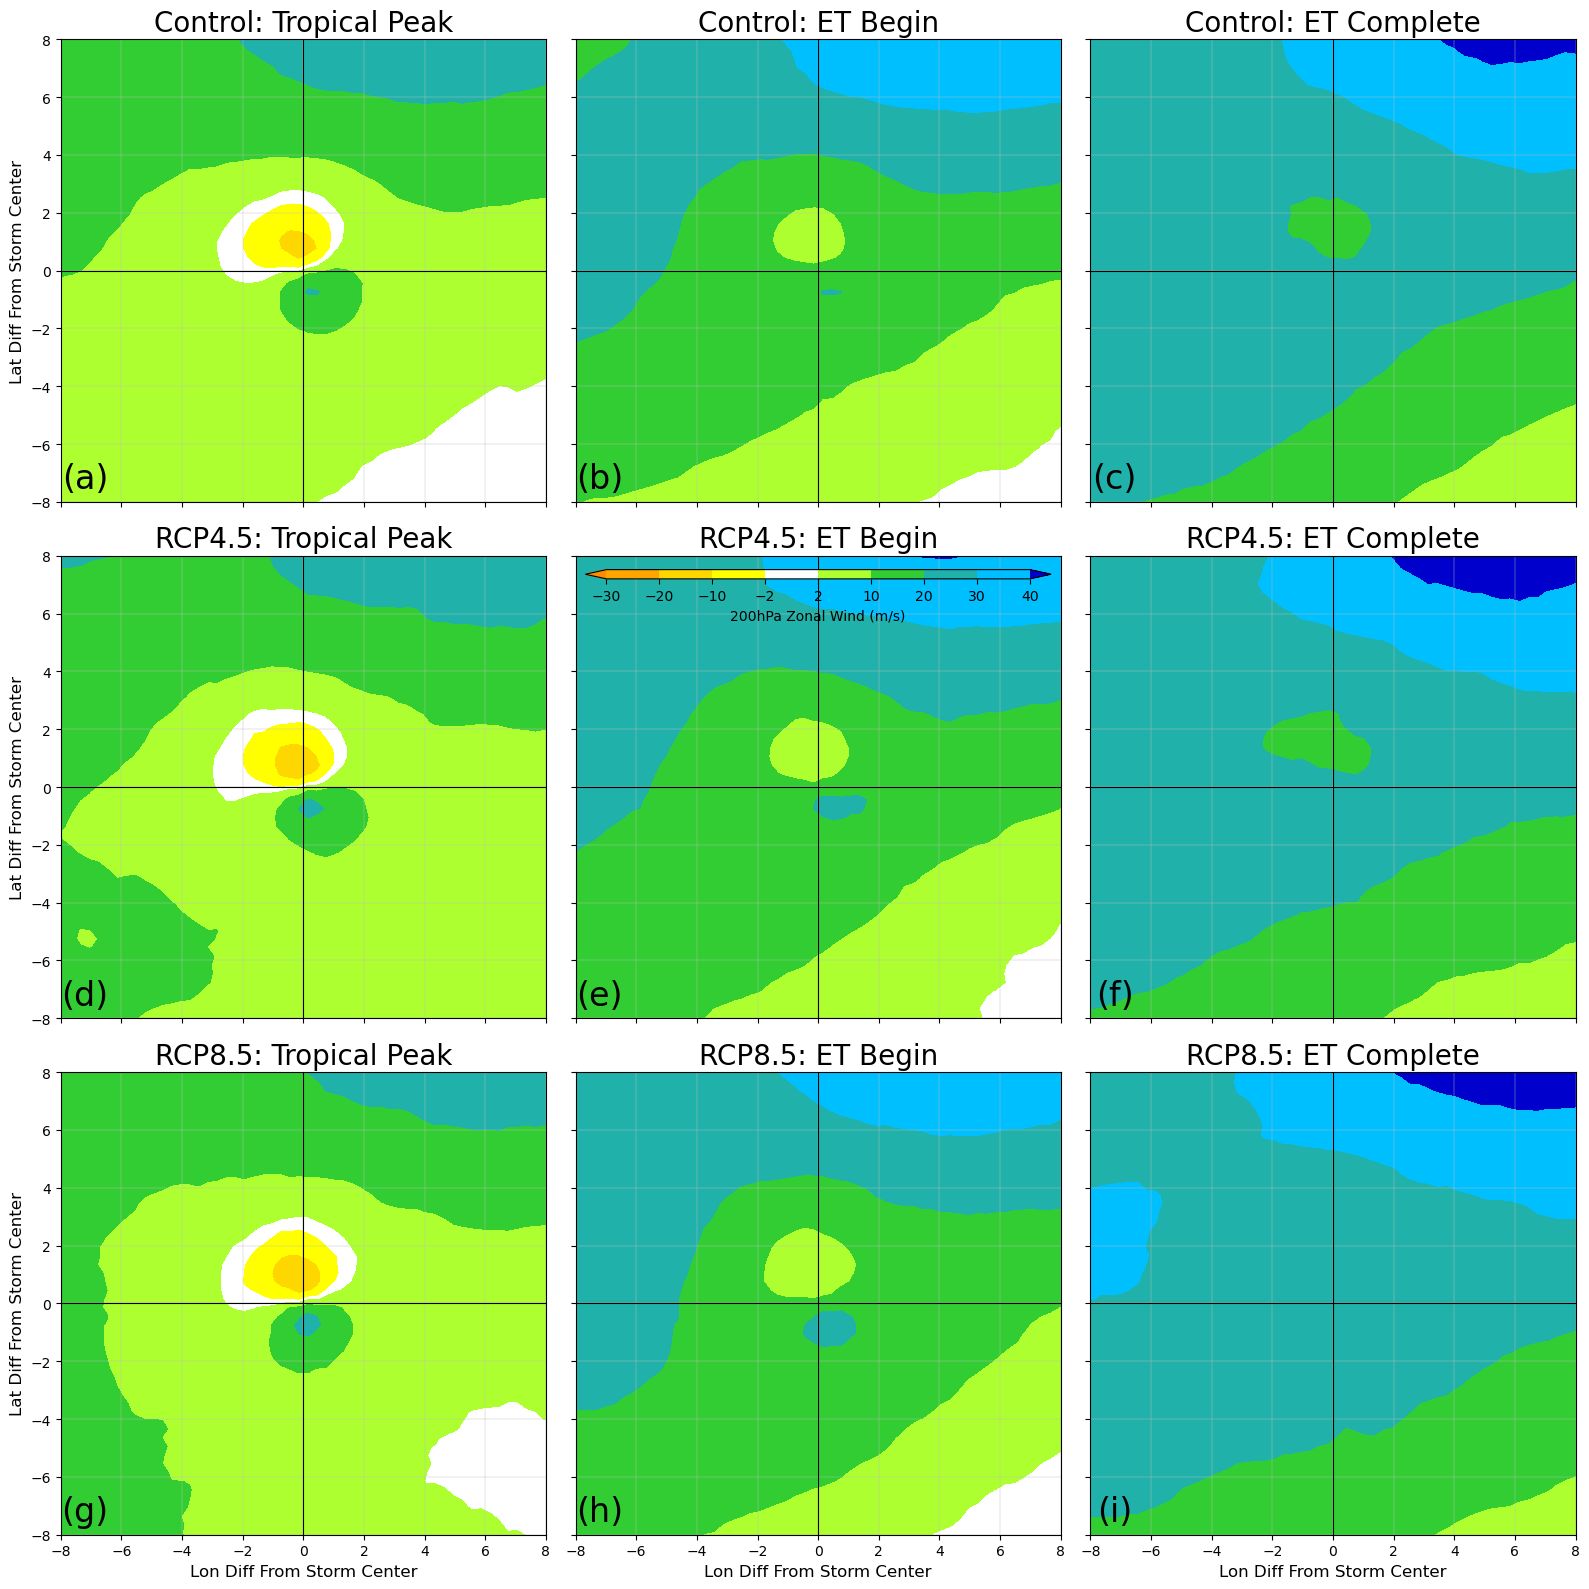

In [81]:
# Plot Mean 200hPa Zonal Wind Snapshots
Var = "200hPa Zonal Wind"
Values = [Control_U_200hPa_Snap_Mean, RCP45_U_200hPa_Snap_Mean, RCP85_U_200hPa_Snap_Mean]
Bounds = U_200hPa_Bounds
Colours = U_200hPa_Colours
Savefig = True
Figname = 'U_200hPa_Snaps_Colours.png'
Snap_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Colours, Savefig, Figname)

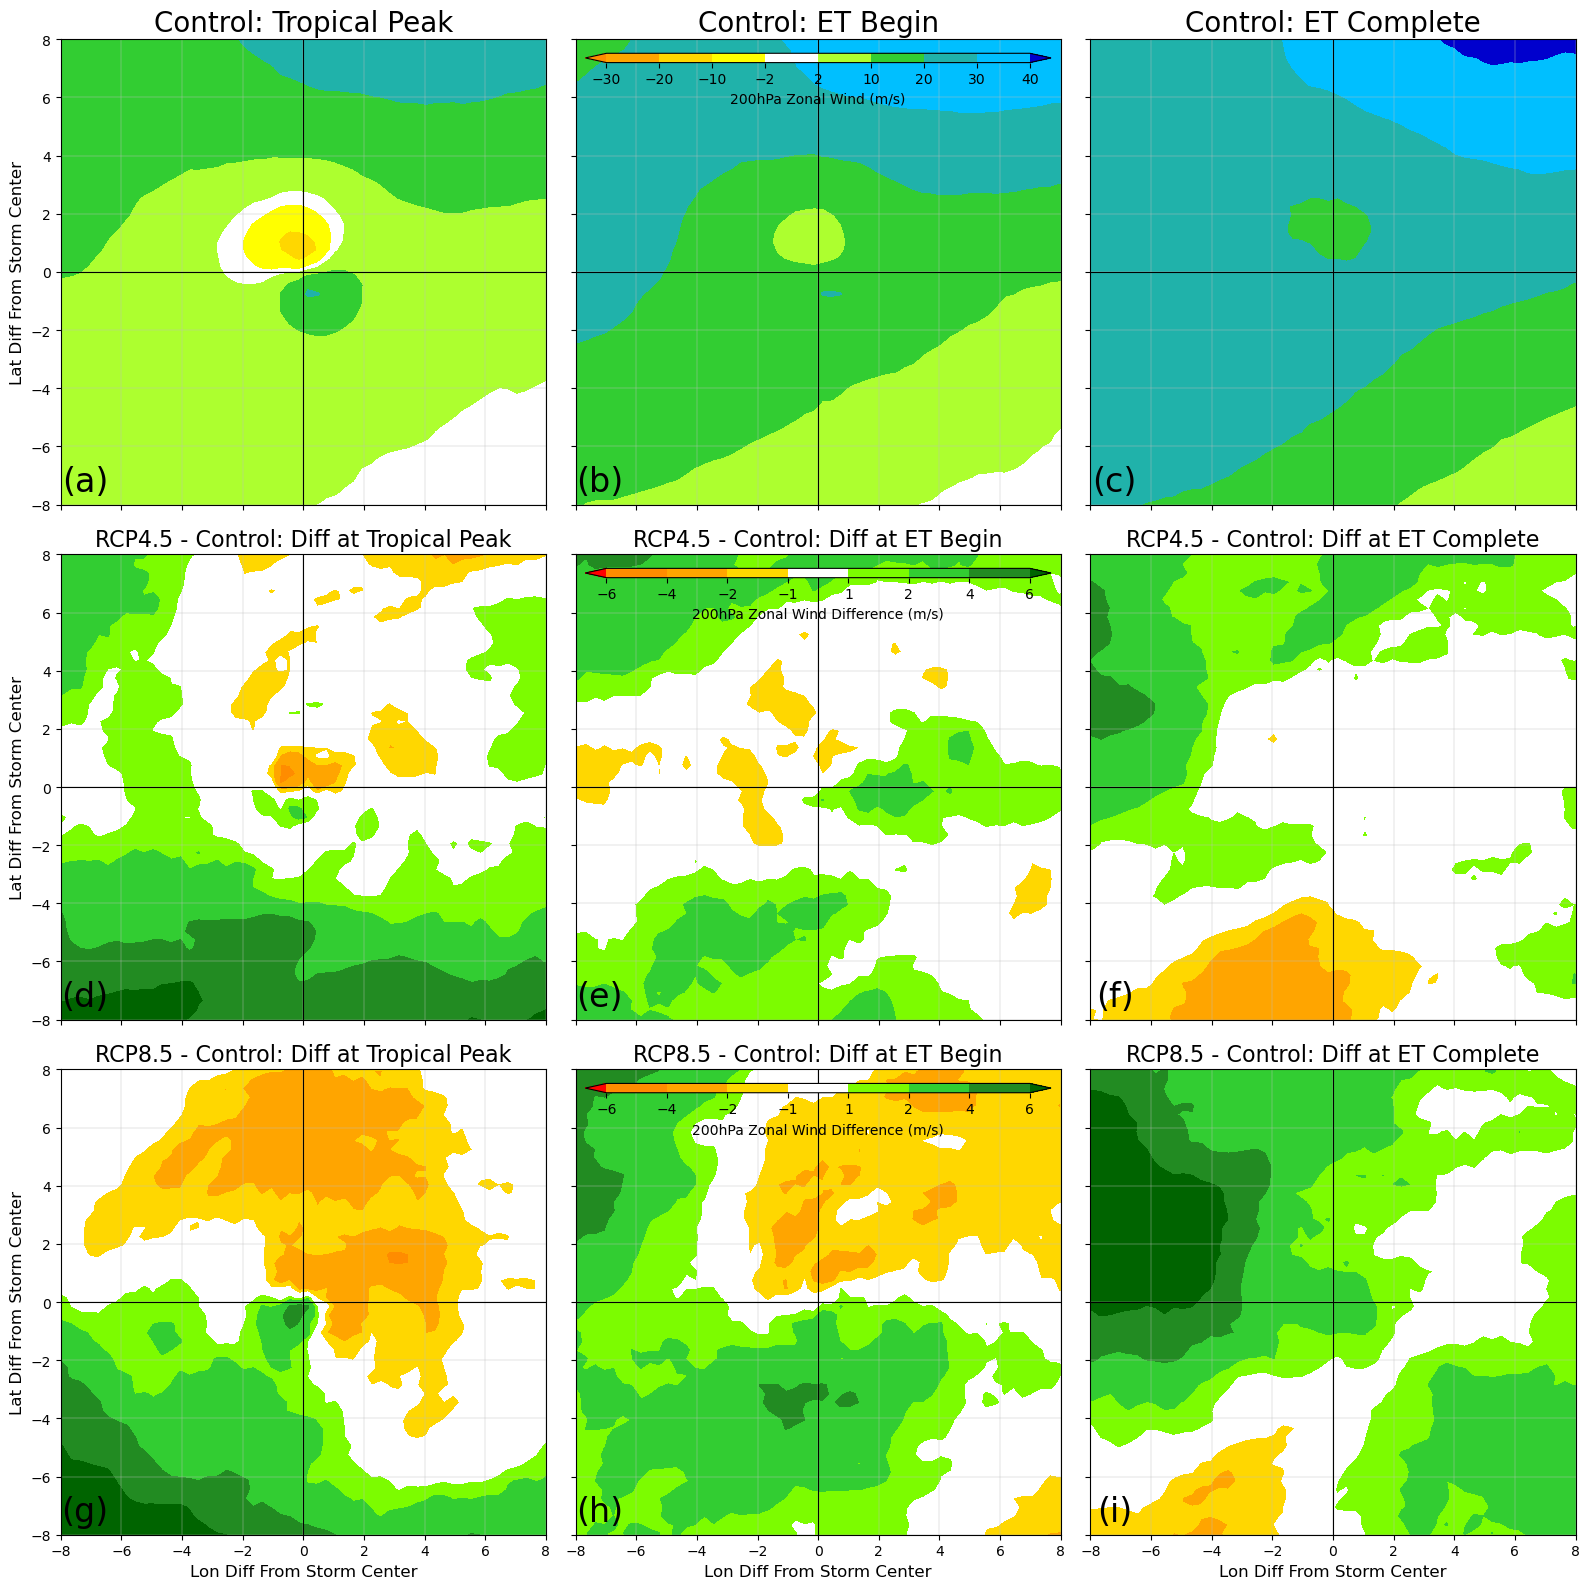

In [82]:
# Plot Mean 200hPa Zonal Wind Difference Snapshots
Var = "200hPa Zonal Wind"
Values = [Control_U_200hPa_Snap_Mean, RCP45_U_200hPa_Snap_Mean, RCP85_U_200hPa_Snap_Mean]
Bounds = U_200hPa_Bounds
Colours = U_200hPa_Colours
Diff_Bounds = U_200hPa_Diff_Bounds
Diff_Colours = U_200hPa_Diff_Colours
Savefig = True
Figname = 'U_200hPa_Snaps_Diff.png'
Snap_Diff_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Colours, \
Diff_Bounds, Diff_Colours, Savefig, Figname)

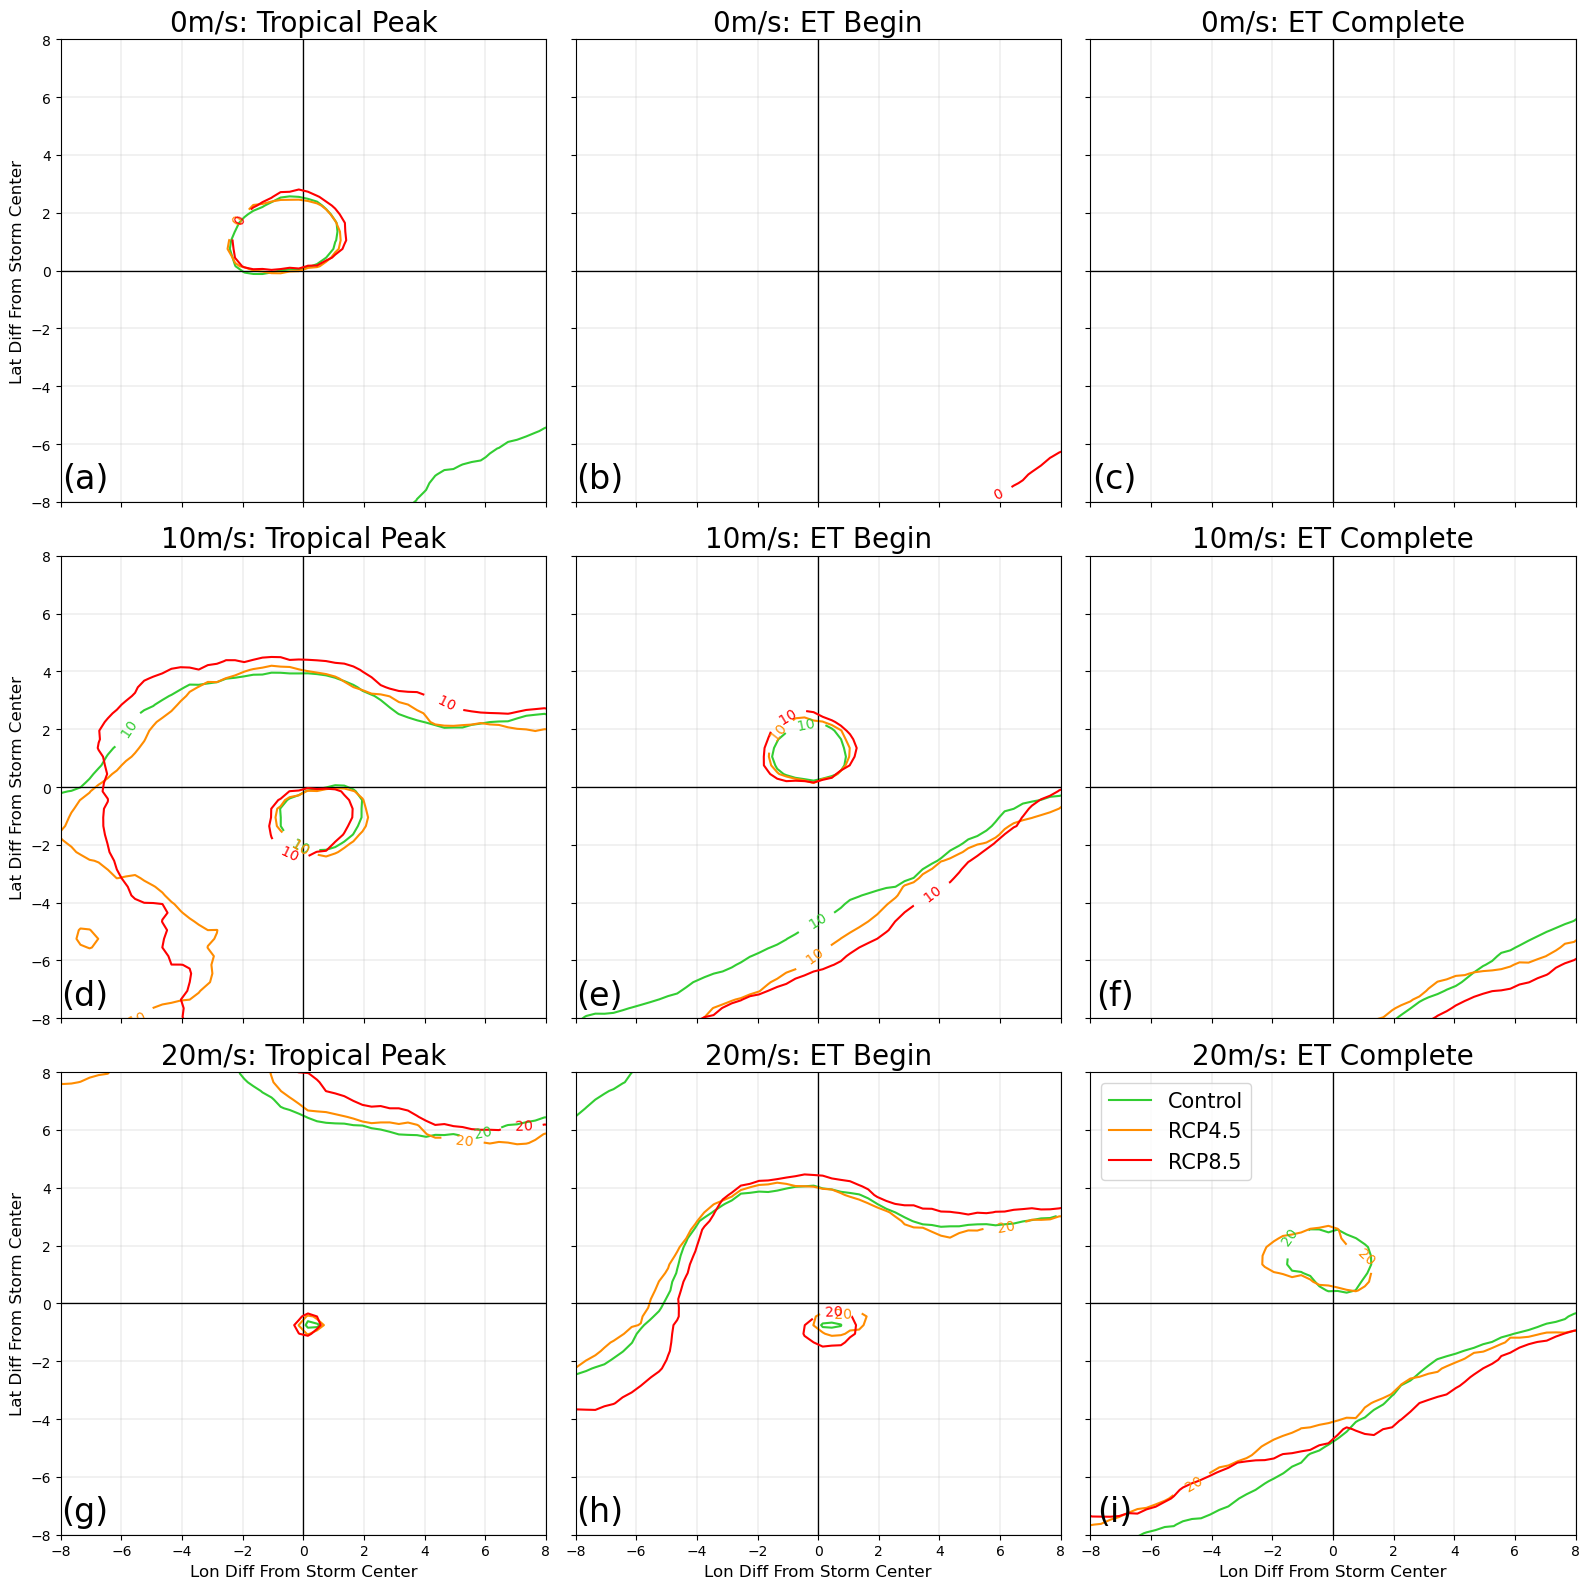

In [128]:
# Plot Mean 200hPa Zonal Wind Contour Line Snapshots
Var = "200hPa Zonal Wind"
Values = [Control_U_200hPa_Snap_Mean, RCP45_U_200hPa_Snap_Mean, RCP85_U_200hPa_Snap_Mean]
Bounds = U_200hPa_Line_Bounds
Savefig = True
Figname = 'U_200hPa_Snaps_Lines.png'
Snap_Line_Plots(Var, Values, Control_A_Compo_nc, Time_Labels, Bounds, Savefig, Figname)